# Network Analysis of Vagrant Developers
<a href="#TODO's">TODO</a><br>
<a href="#Imports">Imports</a><br>
<a href="#Functions">Functions</a><br>
<a href="#Analysis">Analysis</a><br>
<a href="#Linear-Regression"><b>Analysis</b> - Linear-Regression</a><br>
<a href="#Graph-Based-Analysis-using-Logistic-Regression,-Random-Forest-Classifer,-and-XGBoost-classifier"><b>Analysis</b> - Graph-Based Analysis using Logistic Regression, Random Forest Classifer, and XGBoost classifier</a><br>
<a href="#Cross-Validation"><b>Analysis</b> - Cross Validation</a><br>
<a href="#Rebalancing-data"><b>Analysis</b> - Data Rebalancing</a>

## TODO's

<ul>
<li>Implement a new dataframe to store the results from each section. (refer to last cell)</li>
</ul>

## Imports

In [1]:
import pandas as pd
import numpy as np
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import json
import csv
import numpy
import os
import math
from xgboost import XGBClassifier
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, average_precision_score, accuracy_score, precision_recall_curve, plot_precision_recall_curve, auc, recall_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, LeaveOneOut, KFold, StratifiedKFold, RepeatedKFold, TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler 
import statsmodels.api as sm
from ast import literal_eval
from statistics import mean
from collections import Counter
import sys
import warnings
warnings.filterwarnings('ignore')

## Functions

In [2]:
def plot_prediction(model, x, y):
    '''
    Plots the predictions made using a linear regression model 
    given the set of dependent variable(s) and the independent variable
        model: Linear Regression Model
        x: Dependent Variable(s)
        y: Independent Variable
    returns: Independent Variable Predictions
    '''
    y_pred = model.predict(x)
    plt.scatter(x, y)
    plt.plot(x, y_pred, color='red')
    plt.show()
    
    return y_pred

# source: https://stackoverflow.com/questions/26319259/how-to-get-a-regression-summary-in-python-scikit-like-r-does
def regression_results(y_true, y_pred):
    '''
    Analyzes the results from the linear regression model prediction using different metrics, such r^2
    '''
    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    #mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)

    print('explained_variance: ', round(explained_variance,4))    
    #print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))
    
def Loo(model, x, y):
    '''
    Uses the LeaveOneOut cross-validation method provided by SkLearn
    '''
    loo = LeaveOneOut() 
    highestscore = (0, "")
    y_true, y_pred = list(), list()
    
    # Split the data
    for train_index, test_index in loo.split(x):
        x_train, x_test = x.loc[train_index], x.loc[test_index]
        y_train, y_test = y.loc[train_index], y.loc[test_index]
        
        # fit the model on the new data
        model.fit(x_train, y_train)
        
        #evaluate model
        predictions = model.predict_proba(x_test)
        yhat = model.predict(x_test) 
        
        # determine PRC_AUC score
        score = model.score(x_test, y_test) # NOTE: Removed the following due to errors: prc_val = average_precision_score(y_test, yhat)#predictions[:,1])
        if score > highestscore[0]:
            highestscore = (model.score(x_test, y_test), f"TRAIN: {train_index} | TEST: {test_index}")

        #y_true.append(y_test[0])
        #y_pred.append(yhat[0])
            
    print(highestscore[1])
    print("\nModel Score: {}\n".format(highestscore[0]))
    #acc = accuracy_score(y_true, y_pred)
    #print('Accuracy: %.3f' % acc)
    
    
def Loo_short(model, x, y):
    '''
    Uses the shortened version of the LeaveOneOut cross-validation method provided by SkLearn by using cross_val_score
    '''
    cv = LeaveOneOut()
    # to see list of scoring methods, go to: https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
    scores = cross_val_score(model, x, y, scoring='average_precision', cv=cv)
    print("Mean Average-Precision Recall Score: {}".format(mean(scores)))
    
def Rkf(model, x, y, threshold=None):
    '''
    Uses the RepeatedKFold cross-validation method provided by SkLearn
    '''
    kf = RepeatedKFold(n_splits=10, n_repeats=3, random_state=42) 
    #kf.get_n_splits(x)
    #print(kf)
    highestscore = (0, 0, "", 0, 0, 0, 0)
    predictions = None
    precision = None
    recall = None
    yhat = None
    for train_index, test_index in kf.split(x):
        x_train, x_test = x.loc[train_index], x.loc[test_index]
        y_train, y_test = y.loc[train_index], y.loc[test_index]
        
        # if there is only one value (i.e. only 1's or only 0's)
        if(len(set(y_train.values.tolist())) <= 1):
            continue
        
        # fit the model on the new data
        model.fit(x_train, y_train)
        
        #evaluate model
        if threshold is not None:
            predictions = (model.predict_proba(x_test)[:,1] >= threshold).astype(int)
            yhat = (model.predict_proba(x_test)[:,1] >= threshold).astype(int)
            precision, recall, _ = precision_recall_curve(y_test, predictions)
        else:
            predictions = model.predict_proba(x_test)
            # uses default threshold
            yhat = model.predict(x_test)
            precision, recall, _ = precision_recall_curve(y_test, predictions[:, 1])
        
        fscore = (2 * (np.array(precision, dtype=float) * np.array(recall, dtype=float)) / (np.array(precision, dtype=float) + np.array(recall, dtype=float)))
        fscore[np.isnan(fscore)] = 0 
        # locate the index of the largest f score
        ix = np.argmax(fscore)
        
        yhat = model.predict(x_test) 
        
        # Get the auc up to the best threshold point
        pr_auc = auc(recall[ix:], precision[ix:])
        
        # determine PRC_AUC score
        prc_val = average_precision_score(y_test, yhat)#predictions[:,1])
        highestscore = (prc_val, model.score(x_test, y_test), f"TRAIN: {train_index} | TEST: {test_index}", y_test, yhat, pr_auc, predictions)

        #y_true.append(y_test[0])
        #y_pred.append(yhat[0])
            
    print(highestscore[2])
    print("\nModel Score: {}".format(highestscore[1]))
    print("\nAverage Precision-Recall Score: {}".format(highestscore[0]))
    print("PRC-AUC Score: {}".format(highestscore[5]))
    precision = precision_score(highestscore[3], highestscore[4])
    print("Precision: ", precision)
    recall = recall_score(highestscore[3], highestscore[4])
    print("Recall: ", recall)
    f1 = f1_score(highestscore[3], highestscore[4])
    print("F1: ", f1_score(highestscore[3], highestscore[4]))
    print("Classification Report:\n")
    print(classification_report(highestscore[3], highestscore[4]))
    acc = accuracy_score(highestscore[3], highestscore[4])
    print('Accuracy: %.3f' % acc)
    
    # Return model score, average precision score, y_test, PRC-AUC, and Predictions
    return highestscore[1], acc, highestscore[0], highestscore[3], highestscore[5], highestscore[6], precision, recall, f1
    
def Rkf_short(model, x, y):    
    '''
    Uses the shortened version of the RepeatedKFold cross-validation method provided by SkLearn by using cross_val_score
    '''
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=42)
    scores = cross_val_score(model, x, y, scoring='average_precision', cv=cv)
    print("Mean Average-Precision Recall Score: {}".format(mean(scores)))
    
def Skf(model, x, y, threshold = None):
    '''
    Uses the StratifiedKFold cross-validation method provided by SkLearn
    '''
    skf = StratifiedKFold(n_splits=10, random_state=None)
    highestscore = (0, 0, "", 0, 0, 0, 0)
    predictions = None
    precision = None
    recall = None
    yhat = None
    for train_index, test_index in skf.split(x, y):
        x_train, x_test = x.loc[train_index], x.loc[test_index]
        y_train, y_test = y.loc[train_index], y.loc[test_index]
        
        # if there is only one value (i.e. only 1's or only 0's)
        if(len(set(y_train.values.tolist())) <= 1):
            continue
        
        # fit the model on the new data
        model.fit(x_train, y_train)
        
        #evaluate model
        if threshold is not None:
            predictions = (model.predict_proba(x_test)[:,1] >= threshold).astype(int)
            yhat = (model.predict_proba(x_test)[:,1] >= threshold).astype(int)
            precision, recall, _ = precision_recall_curve(y_test, predictions)
        else:
            predictions = model.predict_proba(x_test)
            # uses default threshold
            yhat = model.predict(x_test)
            precision, recall, _ = precision_recall_curve(y_test, predictions[:, 1])
            
        fscore = (2 * (np.array(precision, dtype=float) * np.array(recall, dtype=float)) / (np.array(precision, dtype=float) + np.array(recall, dtype=float)))
        fscore[np.isnan(fscore)] = 0 
        # locate the index of the largest f score
        ix = np.argmax(fscore)
        
        yhat = model.predict(x_test) 
        
        # Get the auc up to the best threshold point
        pr_auc = auc(recall[ix:], precision[ix:])
        # determine PRC_AUC score
        prc_val = average_precision_score(y_test, yhat)#predictions[:,1])
        highestscore = (prc_val, model.score(x_test, y_test), f"TRAIN: {train_index} | TEST: {test_index}", y_test, yhat, pr_auc, predictions)

        #y_true.append(y_test[0])
        #y_pred.append(yhat[0])
            
    print(highestscore[2])
    print("\nModel Score: {}".format(highestscore[1]))
    print("\nAverage Precision-Recall Score: {}".format(highestscore[0]))
    print("PRC-AUC Score: {}".format(highestscore[5]))
    precision = precision_score(highestscore[3], highestscore[4])
    print("Precision: ", precision)
    recall = recall_score(highestscore[3], highestscore[4])
    print("Recall: ", recall)
    f1 = f1_score(highestscore[3], highestscore[4])
    print("F1: ", f1_score(highestscore[3], highestscore[4]))
    print("Classification Report:\n")
    print(classification_report(highestscore[3], highestscore[4]))
    acc = accuracy_score(highestscore[3], highestscore[4])
    print('Accuracy: %.3f' % acc)
    
    # Return model score, average precision score, y_test, PRC-AUC, and Predictions
    return highestscore[1], acc, highestscore[0], highestscore[3], highestscore[5], highestscore[6], precision, recall, f1
    
def Skf_short(model, x, y):
    '''
    Uses the shortened version of the StratifiedKFold cross-validation method provided by SkLearn by using cross_val_score
    '''
    cv = StratifiedKFold(n_splits=10, random_state=None)
    scores = cross_val_score(model, x, y, scoring='average_precision', cv=cv)
    print("Mean Average-Precision Recall Score: {}".format(mean(scores)))    

def Tss(model, x, y, threshold=None):
    '''
    Uses the TimeSeriesSplit cross-validation method provided by SkLearn
    '''
    tscv = TimeSeriesSplit(n_splits=5)
    highestscore = (0, 0, "", 0, 0, 0, 0)
    predictions = None
    precision = None
    rcall = None
    yhat = None
    
    for train_index, test_index in tscv.split(x):
        x_train, x_test = x.loc[train_index], x.loc[test_index]
        y_train, y_test = y.loc[train_index], y.loc[test_index]
        
        # if there is only one value (i.e. only 1's or only 0's)
        if(len(set(y_train.values.tolist())) <= 1):
            continue

        model.fit(x_train, y_train)
        
        #evaluate model
        if threshold is not None:
            predictions = (model.predict_proba(x_test)[:,1] >= threshold).astype(int)
            yhat = (model.predict_proba(x_test)[:,1] >= threshold).astype(int)
            precision, recall, _ = precision_recall_curve(y_test, predictions)
        else:
            predictions = model.predict_proba(x_test)
            # uses default threshold
            yhat = model.predict(x_test)
            precision, recall, _ = precision_recall_curve(y_test, predictions[:, 1])
        
        fscore = (2 * (np.array(precision, dtype=float) * np.array(recall, dtype=float)) / (np.array(precision, dtype=float) + np.array(recall, dtype=float)))
        fscore[np.isnan(fscore)] = 0 
        # locate the index of the largest f score
        ix = np.argmax(fscore)
        
        yhat = model.predict(x_test) 
        
        # Get the auc up to the best threshold point
        pr_auc = auc(recall[ix:], precision[ix:])

        # determine PRC_AUC score
        prc_val = average_precision_score(y_test, yhat)#predictions[:,1])
        highestscore = (prc_val, model.score(x_test, y_test), f"TRAIN: {train_index} | TEST: {test_index}", y_test, yhat, pr_auc, predictions)

        #y_true.append(y_test[0])
        #y_pred.append(yhat[0])
            
    print("\nModel Score: {}".format(highestscore[1]))
    print("\nAverage Precision-Recall Score: {}".format(highestscore[0]))
    print("PRC-AUC Score: {}".format(highestscore[5]))
    precision = precision_score(highestscore[3], highestscore[4])
    print("Precision: ", precision)
    recall = recall_score(highestscore[3], highestscore[4])
    print("Recall: ", recall)
    f1 = f1_score(highestscore[3], highestscore[4])
    print("F1: ", f1_score(highestscore[3], highestscore[4]))
    print("Classification Report:\n")
    print(classification_report(highestscore[3], highestscore[4]))
    acc = accuracy_score(highestscore[3], highestscore[4])
    print('Accuracy: %.3f' % acc)
    
    # Return model score, average precision score, y_test, PRC-AUC, and Predictions
    return highestscore[1], acc, highestscore[0], highestscore[3], highestscore[5], highestscore[6], precision, recall, f1

def Tss_short(model, x, y):
    '''
    Uses the shortened version of the TimeSeriesSplit cross-validation method provided by SkLearn by using cross_val_score
    '''
    cv = TimeSeriesSplit(n_splits=10)
    scores = cross_val_score(model, x, y, scoring='average_precision', cv=cv)
    print("Mean Average-Precision Recall Score: {}".format(mean(scores))) 
    
def Compare_Model_Scores(test_x1, test_x2, y_test, predictions1, predictions2, prediction_probs1, prediction_probs2, model1, model2):
    '''
    This method provides different metrics about the predictions associated with an independent test variable.
    These metrics include: PRC-AUC scores, ROC-AUC scores, and the classification report provided by sklearn
    
    print("Predictions for model 1: ")
    print(prediction_probs1)
    print("\nPredictions for model 2: ")
    print(prediction_probs2)
    '''
    
    #recall1, recall2, precision1, precision2, thresholds_list = get_precision_recall(test_x1, test_x2, y_test, model1, model2)
    
    # ovr: One-vs-rest
    # ovo: One-vs-one
    print("\nScores for model 1")
    print("------------------")
    # Temporarily removed to retrieve precision & recall by hand
    
    precision1, recall1, thresholds1 = precision_recall_curve(y_test, prediction_probs1[:, 1]) 
    #retrieve probability of being 1(in second column of probs_y)
    
    pr_auc1 = auc(recall1, precision1)
    roc_val1 = roc_auc_score(y_test, prediction_probs1[:, 1], multi_class='ovr')
    print('Roc_Auc Score: {}'.format(roc_val1))
    prc_val1 = average_precision_score(y_test, prediction_probs1[:, 1])
    print("Average Precision-Recall Score: {}".format(prc_val1))
    print(f"PRC-AUC for model 1: {pr_auc1}")
    acc1 = accuracy_score(y_test, predictions1)
    print('Accuracy: %.3f' % acc1)

    '''
    Classification Report breakdown from https://datascience.stackexchange.com/questions/64441/how-to-interpret-classification-report-of-scikit-learn:
    The recall means "how many of this class you find over the whole number of element of this class"

    The precision will be "how many are correctly classified among that class"

    The f1-score is the harmonic mean between precision & recall

    The support is the number of occurence of the given class in your dataset (so you have 37.5K of class 0 and 37.5K of class 1, which is a really well balanced dataset.
    '''

    prec_1 = precision_score(y_test, predictions1)
    print("Precision score for model 1: ", prec_1)
    rec_1 = recall_score(y_test, predictions1)
    print("Recall score for model 1: ", rec_1)
    f1_1 = f1_score(y_test, predictions1)
    print("F1 score for model 1: ", f1_1)
    print("Classification Report:\n")
    print(classification_report(y_test, predictions1))

    print("\nScores for model 2")
    print("------------------")
    
    # Temporarily removed to retrieve precision & recall by hand
    precision2, recall2, thresholds2 = precision_recall_curve(y_test, prediction_probs2[:, 1])
    
    pr_auc2 = auc(recall2, precision2)
    roc_val2 = roc_auc_score(y_test, prediction_probs2[:, 1], multi_class='ovr')
    print('Roc_Auc Score: {}'.format(roc_val2))
    prc_val2 = average_precision_score(y_test, prediction_probs2[:, 1])
    print("Average Precision-Recall Score: {}".format(prc_val2))
    print(f"PRC-AUC for model 2: {pr_auc2}")
    
    prec_2 = precision_score(y_test, predictions2)
    print("Precision score for model 2: ", prec_2)
    rec_2 = recall_score(y_test, predictions2)
    print("Recall score for model 2: ", rec_2)
    f1_2 = f1_score(y_test, predictions2)
    print("F1 score for model 2: ", f1_2)
    print("Classification Report:\n")
    print(classification_report(y_test, predictions2))
    acc2 = accuracy_score(y_test, predictions2)
    print('Accuracy: %.3f' % acc2)
    
    return acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2, prec_1, prec_2, rec_1, rec_2, f1_1, f1_2
    
def Compare_Model_Scores_Best_Threshold(test_x1, test_x2, y_test, predictions1, predictions2, prediction_probs1, prediction_probs2, model1, model2):
    '''
    This method provides different metrics about the predictions associated with an independent test variable.
    These metrics include: PRC-AUC scores, ROC-AUC scores, and the classification report provided by sklearn
    '''


    
    # ovr: One-vs-rest
    # ovo: One-vs-one
    print("\nScores for model 1")
    print("------------------")
    precision1, recall1, thresholds1 = precision_recall_curve(y_test, prediction_probs1[:,1])
    fscore1 = (2 * (np.array(precision1, dtype=float) * np.array(recall1, dtype=float)) / (np.array(precision1, dtype=float) + np.array(recall1, dtype=float)))
    fscore1[np.isnan(fscore1)] = 0 
    # locate the index of the largest f score
    ix1 = np.argmax(fscore1)
    
    pr_auc1 = auc(recall1[ix1:], precision1[ix1:])
    roc_val1 = roc_auc_score(y_test, prediction_probs1[:, 1], multi_class='ovr')
    print('Roc_Auc Score: {}'.format(roc_val1))
    prc_val1 = average_precision_score(y_test, prediction_probs1[:, 1])
    print("Average Precision-Recall Score: {}".format(prc_val1))
    print(f"PRC-AUC for model 1: {pr_auc1}")
    
    # Measure the accuracy of the results by comparing the test data with the predictions using the best threshold
    acc1 = accuracy_score(y_test, predictions1)
    print('Accuracy: %.3f' % acc1)

    '''
    Classification Report breakdown from https://datascience.stackexchange.com/questions/64441/how-to-interpret-classification-report-of-scikit-learn:
    The recall means "how many of this class you find over the whole number of element of this class"

    The precision will be "how many are correctly classified among that class"

    The f1-score is the harmonic mean between precision & recall

    The support is the number of occurence of the given class in your dataset (so you have 37.5K of class 0 and 37.5K of class 1, which is a really well balanced dataset.
    '''

    prec_1 = precision_score(y_test, predictions1)
    print("Precision score for model 1: ", prec_1)
    rec_1 = recall_score(y_test, predictions1)
    print("Recall score for model 1: ", rec_1)
    f1_1 = f1_score(y_test, predictions1)
    print("F1 score for model 1: ", f1_1)
    print("Classification Report:\n")
    print(classification_report(y_test, predictions1))

    print("\nScores for model 2")
    print("------------------")
    # Temporarily removed to retrieve precision & recall by hand
    precision2, recall2, thresholds2 = precision_recall_curve(y_test, prediction_probs2[:, 1])
    fscore2 = (2 * (np.array(precision2, dtype=float) * np.array(recall2, dtype=float)) / (np.array(precision2, dtype=float) + np.array(recall2, dtype=float)))
    fscore2[np.isnan(fscore2)] = 0  
    ix2 = np.argmax(fscore2)
    
    pr_auc2 = auc(recall2[ix2:], precision2[ix2:])
    roc_val2 = roc_auc_score(y_test, prediction_probs2[:, 1], multi_class='ovr')
    print('Roc_Auc Score: {}'.format(roc_val2))
    prc_val2 = average_precision_score(y_test, prediction_probs2[:, 1])
    print("Average Precision-Recall Score: {}".format(prc_val2))
    print(f"PRC-AUC for model 2: {pr_auc2}")
    prec_2 = precision_score(y_test, predictions2)
    print("Precision score for model 2: ", prec_2)
    rec_2 = recall_score(y_test, predictions2)
    print("Recall score for model 2: ", rec_2)
    f1_2 = f1_score(y_test, predictions2)
    print("F1 score for model 2: ", f1_2)
    print("Classification Report:\n")
    print(classification_report(y_test, predictions2))
    
    # Measure the accuracy of the results by comparing the test data with the predictions using the best threshold
    acc2 = accuracy_score(y_test, predictions2)
    print('Accuracy: %.3f' % acc2)
    
    return acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2, prec_1, prec_2, rec_1, rec_2, f1_1, f1_2

def plot_thresholds(model1, model2, test_x1, test_y1, test_x2, test_y2, prediction_probs1, prediction_probs2, title):
    '''Predict test_y values and probabilities based on fitted logistic for both models''' 

    # recall1, recall2, precision1, precision2, threshold_list = get_precision_recall(test_x1, test_x2, test_y1, model1, model2)
    
    precision1, recall1, thresholds1 = precision_recall_curve(test_y1, prediction_probs1[:, 1]) 
    precision2, recall2, thresholds2 = precision_recall_curve(test_y2, prediction_probs2[:, 1])
    
    # convert to f1 score
    # from: https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/
    fscore1 = (2 * (np.array(precision1, dtype=float) * np.array(recall1, dtype=float)) / (np.array(precision1, dtype=float) + np.array(recall1, dtype=float)))
    fscore2 = (2 * (np.array(precision2, dtype=float) * np.array(recall2, dtype=float)) / (np.array(precision2, dtype=float) + np.array(recall2, dtype=float)))
    fscore1[np.isnan(fscore1)] = 0 
    fscore2[np.isnan(fscore2)] = 0 
    
    # locate the index of the largest f score
    ix1 = np.argmax(fscore1)
    ix2 = np.argmax(fscore2)
    #print(f"F score 1: {fscore1} with ix: {ix1}")
    #print(f"F score 2: {fscore2} with ix: {ix2}")
    print('Best Threshold=%f, F1-Score=%.3f for model 1' % (thresholds1[ix1], fscore1[ix1]))
    print('Best Threshold=%f, F1-Score=%.3f for model 2' % (thresholds2[ix2], fscore2[ix2]))
    
    
    fig = plt.figure()
    
    plt.title(f"PRC for {title}")
    # use marker = "." to see each threshhold value
    plt.plot(recall1[:-1], precision1[:-1], "b", label=f"Model 1\n-----------\n • PRC-AUC score: {auc(recall1[ix1:], precision1[ix1:]):.2f}\n • Best Threshold: {round(thresholds1[ix1], 2):.2f}\n • Best F1-Score: {round(fscore1[ix1], 2):.2f}\n")
    plt.plot(recall2[:-1], precision2[:-1], "r--", label=f"Model 2\n-----------\n • PRC-AUC score: {auc(recall2[ix2:], precision2[ix2:]):.2f}\n • Best Threshold: {round(thresholds2[ix2], 2):.2f}\n • Best F1-Score: {round(fscore2[ix2], 2):.2f}")
    plt.scatter([recall1[ix1], recall2[ix2]], [precision1[ix1], precision2[ix2]], marker='o', color='black', label='Best threshold')
    #plt.annotate('Model 1 Best Threshold=%.2f, Best F1-Score=%.2f' % (thresholds1[ix1], fscore1[ix1]), (0.38, 0.35), fontsize=8)
    #plt.annotate('Model 2 Best Threshold=%.2f, Best F1-Score=%.2f' % (thresholds2[ix2], fscore2[ix2]), (0.38, 0.3), fontsize=8)
    
    x1 = np.array(recall1[ix1:], dtype=float)
    x2 = np.array(recall2[ix2:], dtype=float)
    y1 = np.array(precision1[ix1:], dtype=float)
    y2 = np.array(precision2[ix2:], dtype=float)
    y1_opp = np.array(precision1[ix2:], dtype=float)
    
    #plt.fill_between(x1, y1, color='b', alpha=0.5)
    # where=y1_opp<=y2
    #plt.fill_between(x2, y2, color='r', alpha=0.3)
    
    plt.ylabel("Precision")
    plt.xlabel("Recall")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    plt.ylim([0,1])
    plt.xlim([0,1])
    
    plt.grid()
    plt.show()
    
    return thresholds1[ix1], thresholds2[ix2], fig
    
def simple_threshold_plot(classifier, x_test, y_test):
    predictions = classifier.predict(x_test)
    prc_val = average_precision_score(y_test, predictions)
    disp = plot_precision_recall_curve(classifier, x_test, y_test)
    disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(prc_val))
    
def get_precision_recall(test_x1, test_x2, test_y, model1, model2):
    '''
    Get the the preicison and recall values for every data point with each type of threshold
    '''
    
    recall1, recall2, precision1, precision2 = list(), list(), list(), list()
    
    # Could also create thresholds using: thresholds = arange(0, 1, 0.001)
    # threshold_list = [0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,.7,.75,.8,.85,.9,.95,.99]
    threshold_list = np.arange(0.001, 1, 0.001)
    for threshold in threshold_list:
        #pred_y1=model1.predict(test_x1) 
        probs_y1=(model1.predict_proba(test_x1)[:,1] >= threshold).astype(int)
        #pred_y2=model2.predict(test_x2) 
        probs_y2=(model2.predict_proba(test_x2)[:,1] >= threshold).astype(int)
        # probs_y is a 2-D array of probability of being labeled as 0 (first column of array) 
        # vs 1 (2nd column in array)
        precision1.append(precision_score(test_y, probs_y1, average='binary'))
        recall1.append(recall_score(test_y, probs_y1, average='binary'))
        precision2.append(precision_score(test_y, probs_y2, average='binary'))
        recall2.append(recall_score(test_y, probs_y2, average='binary'))
        
    return recall1, recall2, precision1, precision2, threshold_list

def get_precision_recall_best_thresh(test_x1, test_x2, test_y, model1, model2, best_thresh1=None, best_thresh2=None):
    '''
    Get the the preicison and recall values for every data point with the best threshold
    '''
    limit1, limit2 = 1, 1
    if best_thresh1 != None:
        limit1 = best_thresh1
    if best_thresh2 != None:
        limit2 = best_thresh2
    
    recall1, recall2, precision1, precision2 = list(), list(), list(), list()
    
    # Could also create thresholds using: thresholds = arange(0, 1, 0.001)
    # threshold_list = [0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,.7,.75,.8,.85,.9,.95,.99]
    threshold_list = np.arange(0.001, limit1, 0.001)
    for threshold in threshold_list:
        #pred_y1=model1.predict(test_x1) 
        probs_y1=(model1.predict_proba(test_x1)[:,1] >= threshold).astype(int)
        # probs_y is a 2-D array of probability of being labeled as 0 (first column of array) 
        # vs 1 (2nd column in array)
        precision1.append(precision_score(test_y, probs_y1, average='binary'))
        recall1.append(recall_score(test_y, probs_y1, average='binary'))
        
    threshold_list = np.arange(0.001, limit2, 0.001)
    for threshold in threshold_list:
        #pred_y2=model2.predict(test_x2) 
        probs_y2=(model2.predict_proba(test_x2)[:,1] >= threshold).astype(int)
        # probs_y is a 2-D array of probability of being labeled as 0 (first column of array) 
        # vs 1 (2nd column in array)
        precision2.append(precision_score(test_y, probs_y2, average='binary'))
        recall2.append(recall_score(test_y, probs_y2, average='binary'))
    return recall1, recall2, precision1, precision2, threshold_list

## Analysis

### Linear Regression

In [3]:
# Make sure the data is from all dates
df = pd.read_csv("../Neo4j_output/Centrality_Output.csv")
# Replace NaN with 0 to include developers who did not introduce any bugs
df['Number_of_Bugs'] = df['Number_of_Bugs'].fillna(0)
print(df)

                    Name   PageRank    Betweenness  Closeness  Harmonic  \
0             Seth Vargo  24.098295  172342.464826   0.917656  0.955134   
1     Mitchell Hashimoto  24.093374  263957.868091   0.879363  0.931406   
2          Chris Roberts  21.082051  177846.949345   0.842297  0.906385   
3               tfanning  19.974389   59072.500908   0.847842  0.910267   
4             Brian Cain  19.631400  131598.446530   0.818503  0.889129   
...                  ...        ...            ...        ...       ...   
1155               winky   0.153670       0.000000   0.487179  0.492091   
1156           Yufan Lou   0.153324       0.000000   0.459010  0.471096   
1157       Aidan Feldman   0.152928       0.000000   0.488000  0.492954   
1158        Steven Leung   0.152204       0.000000   0.498066  0.499569   
1159             Murathe   0.150903       0.000000   0.487795  0.492522   

        Degree  Number_of_Bugs  
0     108731.0           233.0  
1     786949.0           865.0  


#### Predictions with sklearn

In [4]:
linear_regressor = LinearRegression()

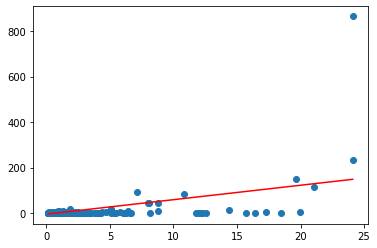

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.248
Model:                            OLS   Adj. R-squared:                  0.247
Method:                 Least Squares   F-statistic:                     380.9
Date:                Wed, 01 Jun 2022   Prob (F-statistic):           1.47e-73
Time:                        02:20:15   Log-Likelihood:                -5312.7
No. Observations:                1160   AIC:                         1.063e+04
Df Residuals:                    1158   BIC:                         1.064e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.4607      0.761     -5.859      0.0

In [5]:
x = df['PageRank'].values.reshape(-1, 1)
y = df['Number_of_Bugs'].values.reshape(-1, 1)
model = linear_regressor.fit(x, y)
y_pred = plot_prediction(model, x, y)

x = sm.add_constant(x)
model = sm.OLS(y, x).fit()
predictions = model.predict(x)
print_model = model.summary()
print(print_model)

In [6]:
regression_results(y, y_pred)

explained_variance:  0.2475
r2:  0.2475
MAE:  4.8982
MSE:  556.645
RMSE:  23.5933


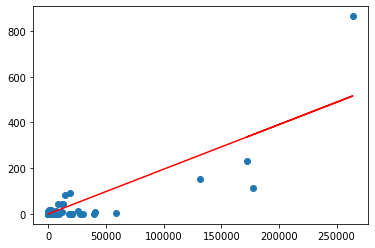

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.711
Model:                            OLS   Adj. R-squared:                  0.711
Method:                 Least Squares   F-statistic:                     2846.
Date:                Wed, 01 Jun 2022   Prob (F-statistic):          3.09e-314
Time:                        02:20:15   Log-Likelihood:                -4758.1
No. Observations:                1160   AIC:                             9520.
Df Residuals:                    1158   BIC:                             9530.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.4835      0.432     -1.120      0.2

In [7]:
x = df['Betweenness'].values.reshape(-1, 1)
y = df['Number_of_Bugs'].values.reshape(-1, 1)
model = linear_regressor.fit(x, y)
y_pred = plot_prediction(model, x, y)

x = sm.add_constant(x)
model = sm.OLS(y, x).fit()
predictions = model.predict(x)
print_model = model.summary()
print(print_model)

In [8]:
regression_results(y, y_pred)

explained_variance:  0.7108
r2:  0.7108
MAE:  2.1069
MSE:  213.94
RMSE:  14.6267


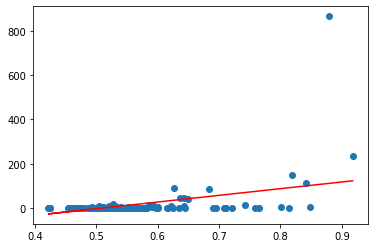

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.192
Model:                            OLS   Adj. R-squared:                  0.191
Method:                 Least Squares   F-statistic:                     274.3
Date:                Wed, 01 Jun 2022   Prob (F-statistic):           1.84e-55
Time:                        02:20:15   Log-Likelihood:                -5354.3
No. Observations:                1160   AIC:                         1.071e+04
Df Residuals:                    1158   BIC:                         1.072e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -153.1468      9.375    -16.335      0.0

In [9]:
x = df['Closeness'].values.reshape(-1, 1)
y = df['Number_of_Bugs'].values.reshape(-1, 1)
model = linear_regressor.fit(x, y)
y_pred = plot_prediction(model, x, y)

x = sm.add_constant(x)
model = sm.OLS(y, x).fit()
predictions = model.predict(x)
print_model = model.summary()
print(print_model)

In [10]:
regression_results(y, y_pred)

explained_variance:  0.1915
r2:  0.1915
MAE:  5.8539
MSE:  598.0523
RMSE:  24.4551


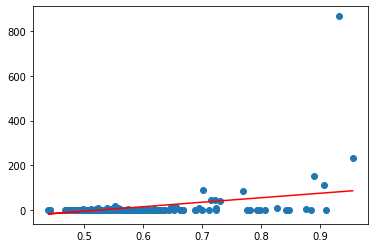

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.145
Model:                            OLS   Adj. R-squared:                  0.144
Method:                 Least Squares   F-statistic:                     196.1
Date:                Wed, 01 Jun 2022   Prob (F-statistic):           2.85e-41
Time:                        02:20:15   Log-Likelihood:                -5386.9
No. Observations:                1160   AIC:                         1.078e+04
Df Residuals:                    1158   BIC:                         1.079e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -104.1860      7.597    -13.715      0.0

In [11]:
x = df['Harmonic'].values.reshape(-1, 1)
y = df['Number_of_Bugs'].values.reshape(-1, 1)
model = linear_regressor.fit(x, y)
y_pred = plot_prediction(model, x, y)

x = sm.add_constant(x)
model = sm.OLS(y, x).fit()
predictions = model.predict(x)
print_model = model.summary()
print(print_model)

In [12]:
regression_results(y, y_pred)

explained_variance:  0.1448
r2:  0.1448
MAE:  5.983
MSE:  632.6194
RMSE:  25.1519


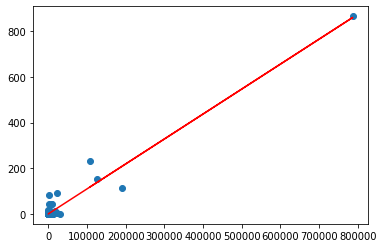

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.951
Model:                            OLS   Adj. R-squared:                  0.951
Method:                 Least Squares   F-statistic:                 2.266e+04
Date:                Wed, 01 Jun 2022   Prob (F-statistic):               0.00
Time:                        02:20:16   Log-Likelihood:                -3724.0
No. Observations:                1160   AIC:                             7452.
Df Residuals:                    1158   BIC:                             7462.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1904      0.177      1.078      0.2

In [13]:
x = df['Degree'].values.reshape(-1, 1)
y = df['Number_of_Bugs'].values.reshape(-1, 1)
model = linear_regressor.fit(x, y)
y_pred = plot_prediction(model, x, y)

x = sm.add_constant(x)
model = sm.OLS(y, x).fit()
predictions = model.predict(x)
print_model = model.summary()
print(print_model)

In [14]:
regression_results(y, y_pred)

explained_variance:  0.9514
r2:  0.9514
MAE:  1.0246
MSE:  35.9721
RMSE:  5.9977


In [15]:
x = df[['PageRank', 'Betweenness', 'Closeness', 'Harmonic', 'Degree']]
y = df['Number_of_Bugs']
#model = linear_regressor.fit(x, y)
#y_pred = plot_prediction(model, x, y)

x = sm.add_constant(x)
model = sm.OLS(y, x).fit()
predictions = model.predict(x)
print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:         Number_of_Bugs   R-squared:                       0.952
Model:                            OLS   Adj. R-squared:                  0.952
Method:                 Least Squares   F-statistic:                     4607.
Date:                Wed, 01 Jun 2022   Prob (F-statistic):               0.00
Time:                        02:20:16   Log-Likelihood:                -3712.9
No. Observations:                1160   AIC:                             7438.
Df Residuals:                    1154   BIC:                             7468.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -9.3917      7.621     -1.232      

### Graph-Based Analysis using Logistic Regression, Random Forest Classifer, and XGBoost classifier

    XGB_precision_1  XGB_precision_2  XGB_recall_1  XGB_recall_2  XGB_f1_1  \
0          0.709659         0.709659      0.734340      0.734340  0.721789   
1          0.615680         0.615696      0.905202      0.905266  0.732884   
2          0.765923         0.766037      0.605349      0.605367  0.676234   
3               NaN              NaN           NaN           NaN       NaN   
4          0.630116         0.630116      0.656201      0.656201  0.642894   
5          0.626955         0.628680      0.865232      0.859243  0.727069   
6          0.995389         0.995389      1.000000      1.000000  0.997689   
7               NaN              NaN           NaN           NaN       NaN   
8          0.768702         0.768702      0.973736      0.973736  0.859156   
9          0.964876         0.944457      0.830597      0.830797  0.892715   
10         0.673374         0.673374      0.794518      0.794518  0.728947   
11         0.660557         0.660554      0.879611      0.879597

Original_Logistic_Regression model 1

Scores for model 1
------------------
Roc_Auc Score: 0.4177332844475333
Average Precision-Recall Score: 0.40575071492583925
PRC-AUC for model 1: 0.411748730139388
Accuracy: 0.579
Precision score for model 1:  0.0
Recall score for model 1:  0.0
F1 score for model 1:  0.0
Classification Report:

              precision    recall  f1-score   support

           0       0.58      1.00      0.73      8680
           1       0.00      0.00      0.00      6319

    accuracy                           0.58     14999
   macro avg       0.29      0.50      0.37     14999
weighted avg       0.33      0.58      0.42     14999


Scores for model 2
------------------
Roc_Auc Score: 0.41729136143428164
Average Precision-Recall Score: 0.40444579128712926
PRC-AUC for model 2: 0.46270985560298034
Precision score for model 2:  0.0
Recall score for model 2:  0.0
F1 score for model 2:  0.0
Classification Report:

              precision    recall  f1-score   support

  

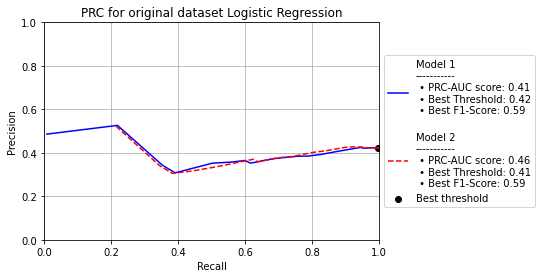

Best Threshold=0.393325, F1-Score=0.678 for model 1
Best Threshold=0.393635, F1-Score=0.678 for model 2


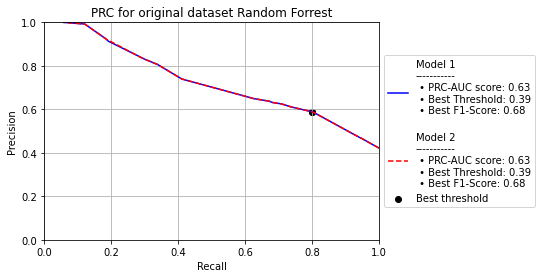

Best Threshold=0.389592, F1-Score=0.678 for model 1
Best Threshold=0.389599, F1-Score=0.678 for model 2


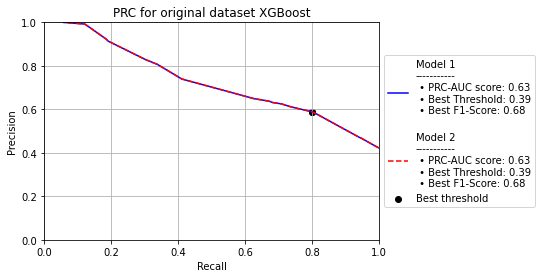

Original_Logistic_Regression_Best_Threshold model 1

Scores for model 1
------------------
Roc_Auc Score: 0.4177332844475333
Average Precision-Recall Score: 0.40575071492583925
PRC-AUC for model 1: 0.41114735821256493
Accuracy: 0.425
Precision score for model 1:  0.4229789516020914
Recall score for model 1:  0.9985757240069632
F1 score for model 1:  0.5942458916042755
Classification Report:

              precision    recall  f1-score   support

           0       0.89      0.01      0.02      8680
           1       0.42      1.00      0.59      6319

    accuracy                           0.43     14999
   macro avg       0.66      0.50      0.31     14999
weighted avg       0.69      0.43      0.26     14999


Scores for model 2
------------------
Roc_Auc Score: 0.41729136143428164
Average Precision-Recall Score: 0.40444579128712926
PRC-AUC for model 2: 0.46230910312585194
Precision score for model 2:  0.4226700589180504
Recall score for model 2:  0.9990504826713088
F1 score for mod

TRAIN: [    0     1     2 ... 57423 57424 57425] | TEST: [42448 42449 42450 ... 59992 59993 59994]

Model Score: 0.4192365394232372

Average Precision-Recall Score: 0.4191397132377459
PRC-AUC Score: 0.4632135897934601
Precision:  0.4191397132377459
Recall:  1.0
F1:  0.5906954887218046
Classification Report:

              precision    recall  f1-score   support

           0       1.00      0.00      0.00      3485
           1       0.42      1.00      0.59      2514

    accuracy                           0.42      5999
   macro avg       0.71      0.50      0.30      5999
weighted avg       0.76      0.42      0.25      5999

Accuracy: 0.419
Original_XGB_Classifier_skf model 1
TRAIN: [    0     1     2 ... 57423 57424 57425] | TEST: [42448 42449 42450 ... 59992 59993 59994]

Model Score: 0.4192365394232372

Average Precision-Recall Score: 0.4191397132377459
PRC-AUC Score: 0.6696996056292381
Precision:  0.4191397132377459
Recall:  1.0
F1:  0.5906954887218046
Classification Report:

 

TRAIN: [    0     1     2 ... 57423 57424 57425] | TEST: [42448 42449 42450 ... 59992 59993 59994]

Model Score: 0.4192365394232372

Average Precision-Recall Score: 0.4191397132377459
PRC-AUC Score: 0.31629315995855545
Precision:  0.4191397132377459
Recall:  1.0
F1:  0.5906954887218046
Classification Report:

              precision    recall  f1-score   support

           0       1.00      0.00      0.00      3485
           1       0.42      1.00      0.59      2514

    accuracy                           0.42      5999
   macro avg       0.71      0.50      0.30      5999
weighted avg       0.76      0.42      0.25      5999

Accuracy: 0.419
Row 14 model 2

Model Score: 0.14611461146114613

Average Precision-Recall Score: 0.8538853885388539
PRC-AUC Score: 0.9019823529062307
Precision:  0.0
Recall:  0.0
F1:  0.0
Classification Report:

              precision    recall  f1-score   support

           0       0.15      1.00      0.25      1461
           1       0.00      0.00      0

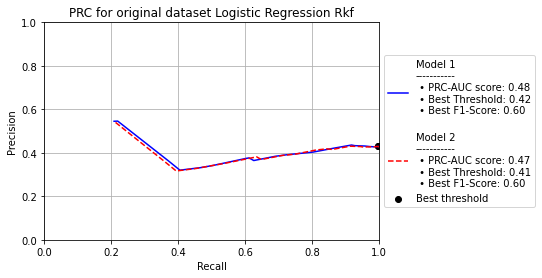

Best Threshold=0.324906, F1-Score=0.678 for model 1
Best Threshold=0.329077, F1-Score=0.678 for model 2


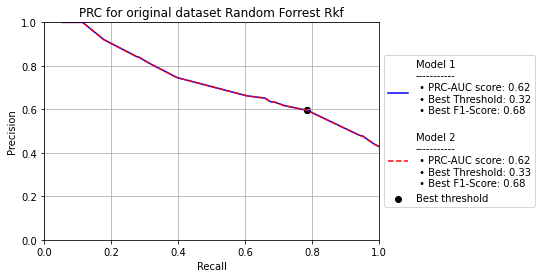

Best Threshold=0.330288, F1-Score=0.678 for model 1
Best Threshold=0.330232, F1-Score=0.678 for model 2


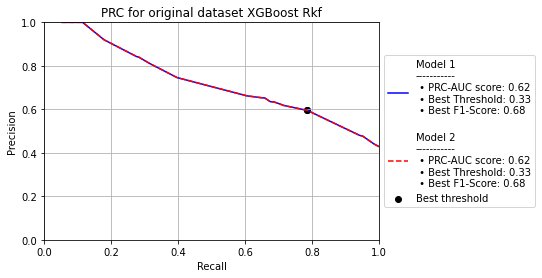

Best Threshold=0.418842, F1-Score=0.704 for model 1
Best Threshold=0.419032, F1-Score=0.613 for model 2


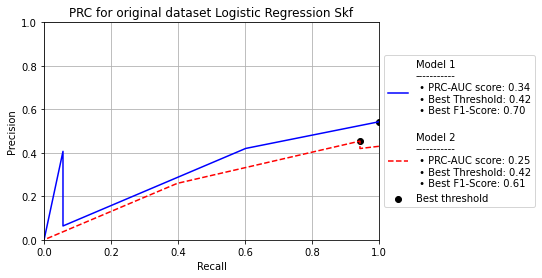

Best Threshold=0.922455, F1-Score=0.638 for model 1
Best Threshold=0.553364, F1-Score=0.592 for model 2


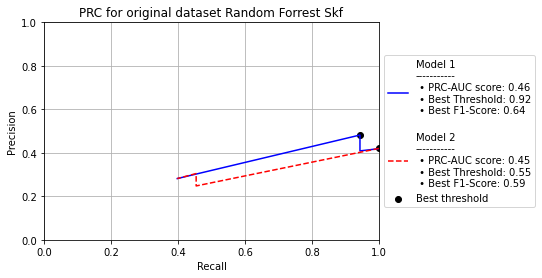

Best Threshold=0.999718, F1-Score=0.745 for model 1
Best Threshold=0.871136, F1-Score=0.659 for model 2


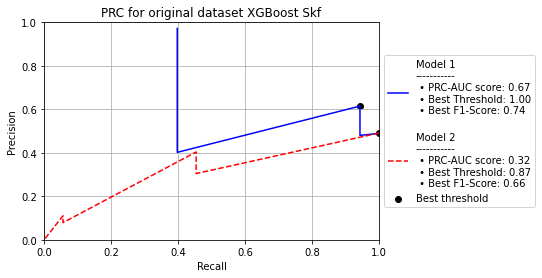

Best Threshold=0.328847, F1-Score=0.924 for model 1
Best Threshold=0.326432, F1-Score=0.925 for model 2


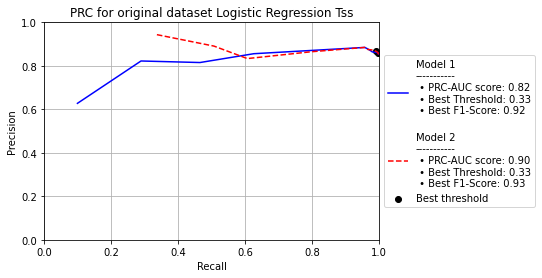

Best Threshold=0.000000, F1-Score=0.921 for model 1
Best Threshold=0.000000, F1-Score=0.921 for model 2


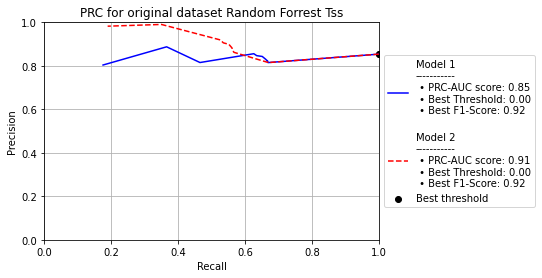

Best Threshold=0.000797, F1-Score=0.921 for model 1
Best Threshold=0.000318, F1-Score=0.921 for model 2


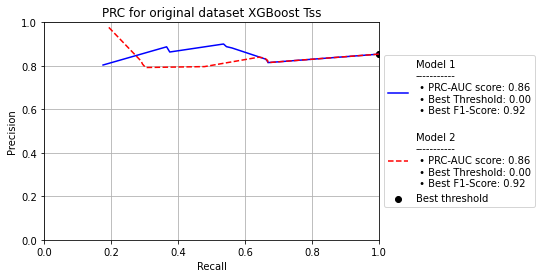

0    34852
1    25143
Name: Bug, dtype: int64
Row 18 model 1

Scores for model 1
------------------
Roc_Auc Score: 0.4213043997451773
Average Precision-Recall Score: 0.40391253454261944
PRC-AUC for model 1: 0.46291949868255083
Accuracy: 0.581
Precision score for model 1:  0.0
Recall score for model 1:  0.0
F1 score for model 1:  0.0
Classification Report:

              precision    recall  f1-score   support

           0       0.58      1.00      0.73      8714
           1       0.00      0.00      0.00      6285

    accuracy                           0.58     14999
   macro avg       0.29      0.50      0.37     14999
weighted avg       0.34      0.58      0.43     14999


Scores for model 2
------------------
Roc_Auc Score: 0.42115159011303965
Average Precision-Recall Score: 0.4027109365120537
PRC-AUC for model 2: 0.4618026420831732
Precision score for model 2:  0.0
Recall score for model 2:  0.0
F1 score for model 2:  0.0
Classification Report:

              precision    recall

TRAIN: [    0     1     2 ... 50283 50284 50285] | TEST: [   10    15    22 ... 50261 50265 50269]

Model Score: 0.49144789180588705

Average Precision-Recall Score: 0.49036676801267265
PRC-AUC Score: 0.7448289578361178
Precision:  0.4903787725339275
Recall:  0.9833468724614135
F1:  0.6544127584808758
Classification Report:

              precision    recall  f1-score   support

           0       0.55      0.02      0.04      2566
           1       0.49      0.98      0.65      2462

    accuracy                           0.49      5028
   macro avg       0.52      0.50      0.35      5028
weighted avg       0.52      0.49      0.34      5028

Accuracy: 0.491
TRAIN: [    0     1     2 ... 50283 50284 50285] | TEST: [   10    15    22 ... 50261 50265 50269]

Model Score: 0.4968178202068417

Average Precision-Recall Score: 0.4905826941038609
PRC-AUC Score: 0.4946720947120581
Precision:  0.49089935760171305
Recall:  0.7449228269699432
F1:  0.5918038076798967
Classification Report:

    

TRAIN: [    0     1     2 ... 50283 50284 50285] | TEST: [   10    15    22 ... 50261 50265 50269]

Model Score: 0.4968178202068417

Average Precision-Recall Score: 0.4905826941038609
PRC-AUC Score: 0.4902072789571657
Precision:  0.49089935760171305
Recall:  0.7449228269699432
F1:  0.5918038076798967
Classification Report:

              precision    recall  f1-score   support

           0       0.51      0.26      0.34      2566
           1       0.49      0.74      0.59      2462

    accuracy                           0.50      5028
   macro avg       0.50      0.50      0.47      5028
weighted avg       0.50      0.50      0.47      5028

Accuracy: 0.497
TRAIN: [    0     1     2 ... 47769 47770 47771] | TEST: [22629 22630 22631 ... 50283 50284 50285]

Model Score: 0.5037788385043755

Average Precision-Recall Score: 0.5018989138212941
PRC-AUC Score: 0.37663213597262074
Precision:  0.5025125628140703
Recall:  0.7557677008750995
F1:  0.6036536934074663
Classification Report:

     


Accuracy: 0.685

Scores for model 1
------------------
Roc_Auc Score: 0.4170015898982088
Average Precision-Recall Score: 0.4822247275289913
PRC-AUC for model 1: 0.531908400206869
Accuracy: 0.503
Precision score for model 1:  0.5029840468265809
Recall score for model 1:  1.0
F1 score for model 1:  0.6693138864495437
Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      8661
           1       0.50      1.00      0.67      8765

    accuracy                           0.50     17426
   macro avg       0.25      0.50      0.33     17426
weighted avg       0.25      0.50      0.34     17426


Scores for model 2
------------------
Roc_Auc Score: 0.4213640587633334
Average Precision-Recall Score: 0.4835618875649293
PRC-AUC for model 2: 0.5335295134798881
Precision score for model 2:  0.5031572904707233
Recall score for model 2:  1.0
F1 score for model 2:  0.669467252243651
Classification Report:

              precisio

TRAIN: [    0     1     2 ... 66216 66217 66218] | TEST: [42448 42449 42450 ... 69701 69702 69703]

Model Score: 0.33802008608321377

Average Precision-Recall Score: 0.43466985831922733
PRC-AUC Score: 0.4839952501620037
Precision:  0.4033224867271793
Recall:  0.6757532281205165
F1:  0.5051480051480052
Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      3485
           1       0.40      0.68      0.51      3485

    accuracy                           0.34      6970
   macro avg       0.20      0.34      0.25      6970
weighted avg       0.20      0.34      0.25      6970

Accuracy: 0.338

Model Score: 0.0047344409055694245

Average Precision-Recall Score: 0.9952655590944306
PRC-AUC Score: 0.9999487297370224
Precision:  0.0
Recall:  0.0
F1:  0.0
Classification Report:

              precision    recall  f1-score   support

           0       0.00      1.00      0.01        55
           1       0.00      0.00    


Model Score: 0.0047344409055694245

Average Precision-Recall Score: 0.9952655590944306
PRC-AUC Score: 0.9976327795472153
Precision:  0.0
Recall:  0.0
F1:  0.0
Classification Report:

              precision    recall  f1-score   support

           0       0.00      1.00      0.01        55
           1       0.00      0.00      0.00     11562

    accuracy                           0.00     11617
   macro avg       0.00      0.50      0.00     11617
weighted avg       0.00      0.00      0.00     11617

Accuracy: 0.005

Model Score: 0.49978479814065596

Average Precision-Recall Score: 0.9976204950612123
PRC-AUC Score: 0.9983786086219687
Precision:  1.0
Recall:  0.4974052932018682
F1:  0.6643562640790158
Classification Report:

              precision    recall  f1-score   support

           0       0.01      1.00      0.02        55
           1       1.00      0.50      0.66     11562

    accuracy                           0.50     11617
   macro avg       0.50      0.75      0.34

Row 59 model 1

Scores for model 1
------------------
Roc_Auc Score: 0.7510777419335078
Average Precision-Recall Score: 0.7458576273403424
PRC-AUC for model 1: 0.6498329137618958
Accuracy: 0.686
Precision score for model 1:  0.6537587578110207
Recall score for model 1:  0.7923121055651177
F1 score for model 1:  0.716397779737511
Classification Report:

              precision    recall  f1-score   support

           0       0.74      0.58      0.65      8711
           1       0.65      0.79      0.72      8715

    accuracy                           0.69     17426
   macro avg       0.70      0.69      0.68     17426
weighted avg       0.70      0.69      0.68     17426


Scores for model 2
------------------
Roc_Auc Score: 0.751078690345619
Average Precision-Recall Score: 0.7458697515509092
PRC-AUC for model 2: 0.6498429863613054
Precision score for model 2:  0.6537587578110207
Recall score for model 2:  0.7923121055651177
F1 score for model 2:  0.716397779737511
Classification Repo


Model Score: 0.6222776964792975

Average Precision-Recall Score: 1.0
PRC-AUC Score: 1.0000000000000002
Precision:  1.0
Recall:  0.6222776964792975
F1:  0.7671654462485408
Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.62      0.77     11617

    accuracy                           0.62     11617
   macro avg       0.50      0.31      0.38     11617
weighted avg       1.00      0.62      0.77     11617

Accuracy: 0.622
TRAIN: [    0     1     2 ... 69700 69701 69703] | TEST: [   17    61    68 ... 69658 69679 69702]

Model Score: 0.490961262553802

Average Precision-Recall Score: 0.49072861887869
PRC-AUC Score: 0.5140750921759152
Precision:  0.4907046476761619
Recall:  0.9558995327102804
F1:  0.6485040618189023
Classification Report:

              precision    recall  f1-score   support

           0       0.50      0.04      0.08      3546
           1       0.49      0

Performing analysis for: Ivy
                Name                                               File  \
3835   Maarten Coene       src/java/org/apache/ivy/core/IvyContext.java   
3836   Maarten Coene                                        CHANGES.txt   
3837   Maarten Coene  src/java/org/apache/ivy/plugins/resolver/Abstr...   
3838   Maarten Coene  src/java/org/apache/ivy/plugins/resolver/Basic...   
3839   Maarten Coene  src/java/org/apache/ivy/plugins/resolver/Repos...   
...              ...                                                ...   
24439             mm  src/example/configurations/multi-projects/filt...   
24440             mm  src/example/configurations/multi-projects/myap...   
24442             mb     src/java/fr/jayasoft/ivy/report/ivy-report.xsl   
24443             mb  src/java/fr/jayasoft/ivy/report/XmlReportOutpu...   
24444             mb     src/java/fr/jayasoft/ivy/report/ivy-report.xsl   

                      Bug  PageRank  Betweenness  Closeness  Harmonic 

Original_XGB model 1

Scores for model 1
------------------
Roc_Auc Score: 0.8917230874227365
Average Precision-Recall Score: 0.7205075327101281
PRC-AUC for model 1: 0.8467811194239913
Accuracy: 0.852
Precision score for model 1:  0.7297698589458055
Recall score for model 1:  0.9178338001867413
F1 score for model 1:  0.8130686517783291
Classification Report:

              precision    recall  f1-score   support

           0       0.95      0.82      0.88      3973
           1       0.73      0.92      0.81      2142

    accuracy                           0.85      6115
   macro avg       0.84      0.87      0.85      6115
weighted avg       0.87      0.85      0.86      6115


Scores for model 2
------------------
Roc_Auc Score: 0.8917912412049307
Average Precision-Recall Score: 0.7205645978984719
PRC-AUC for model 2: 0.8468344380990948
Precision score for model 2:  0.7297698589458055
Recall score for model 2:  0.9178338001867413
F1 score for model 2:  0.8130686517783291
Classifica

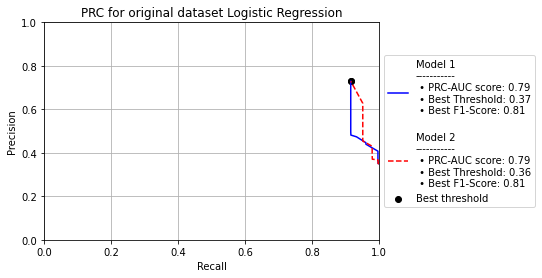

Best Threshold=0.722473, F1-Score=0.813 for model 1
Best Threshold=0.721891, F1-Score=0.813 for model 2


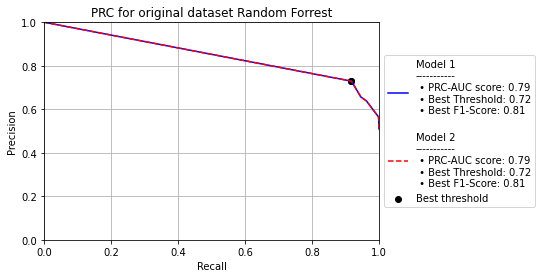

Best Threshold=0.721814, F1-Score=0.813 for model 1
Best Threshold=0.721814, F1-Score=0.813 for model 2


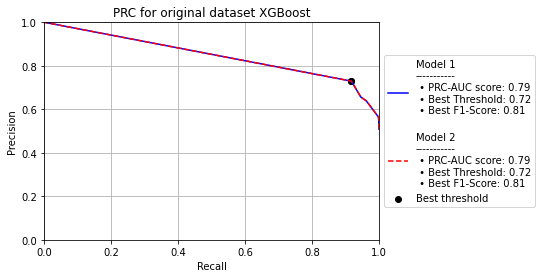

Original_Logistic_Regression_Best_Threshold model 1

Scores for model 1
------------------
Roc_Auc Score: 0.8611554110695372
Average Precision-Recall Score: 0.7044042245968
PRC-AUC for model 1: 0.7920214926119146
Accuracy: 0.852
Precision score for model 1:  0.729368029739777
Recall score for model 1:  0.9159663865546218
F1 score for model 1:  0.8120860927152318
Classification Report:

              precision    recall  f1-score   support

           0       0.95      0.82      0.88      3973
           1       0.73      0.92      0.81      2142

    accuracy                           0.85      6115
   macro avg       0.84      0.87      0.84      6115
weighted avg       0.87      0.85      0.85      6115


Scores for model 2
------------------
Roc_Auc Score: 0.8704025867415511
Average Precision-Recall Score: 0.7100337042438813
PRC-AUC for model 2: 0.7920214926119146
Precision score for model 2:  0.729368029739777
Recall score for model 2:  0.9159663865546218
F1 score for model 2:  0.8

TRAIN: [    0     1     2 ... 23579 23580 23581] | TEST: [14906 14907 14908 ... 24454 24455 24456]

Model Score: 0.3496932515337423

Average Precision-Recall Score: 0.34916836586760497
PRC-AUC Score: 0.667032998407863
Precision:  0.3490878938640133
Recall:  0.9767981438515081
F1:  0.51435552840562
Classification Report:

              precision    recall  f1-score   support

           0       0.39      0.01      0.02      1583
           1       0.35      0.98      0.51       862

    accuracy                           0.35      2445
   macro avg       0.37      0.49      0.27      2445
weighted avg       0.38      0.35      0.19      2445

Accuracy: 0.350
Original_XGB_Classifier_skf model 1
TRAIN: [    0     1     2 ... 23579 23580 23581] | TEST: [14906 14907 14908 ... 24454 24455 24456]

Model Score: 0.3496932515337423

Average Precision-Recall Score: 0.34916836586760497
PRC-AUC Score: 0.667032998407863
Precision:  0.3490878938640133
Recall:  0.9767981438515081
F1:  0.51435552840562

TRAIN: [    0     1     2 ... 23579 23580 23581] | TEST: [14906 14907 14908 ... 24454 24455 24456]

Model Score: 0.3496932515337423

Average Precision-Recall Score: 0.34916836586760497
PRC-AUC Score: 0.6658213258989347
Precision:  0.3490878938640133
Recall:  0.9767981438515081
F1:  0.51435552840562
Classification Report:

              precision    recall  f1-score   support

           0       0.39      0.01      0.02      1583
           1       0.35      0.98      0.51       862

    accuracy                           0.35      2445
   macro avg       0.37      0.49      0.27      2445
weighted avg       0.38      0.35      0.19      2445

Accuracy: 0.350
Row 14 model 2

Model Score: 0.0031894013738959764

Average Precision-Recall Score: 0.996810598626104
PRC-AUC Score: 0.9992611141815106
Precision:  0.0
Recall:  0.0
F1:  0.0
Classification Report:

              precision    recall  f1-score   support

           0       0.00      1.00      0.01        13
           1       0.00   

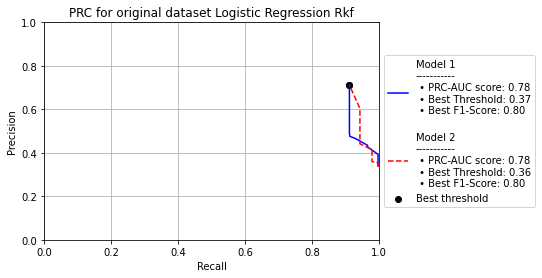

Best Threshold=0.724459, F1-Score=0.800 for model 1
Best Threshold=0.724782, F1-Score=0.800 for model 2


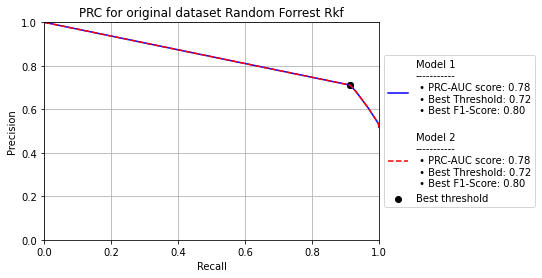

Best Threshold=0.724962, F1-Score=0.800 for model 1
Best Threshold=0.724972, F1-Score=0.800 for model 2


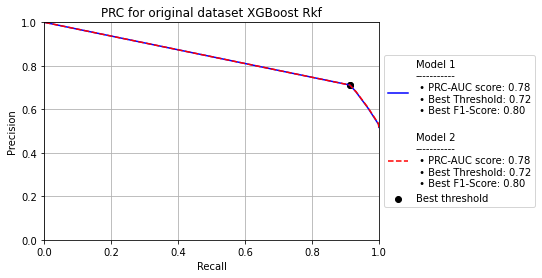

Best Threshold=0.123767, F1-Score=0.522 for model 1
Best Threshold=0.191439, F1-Score=0.522 for model 2


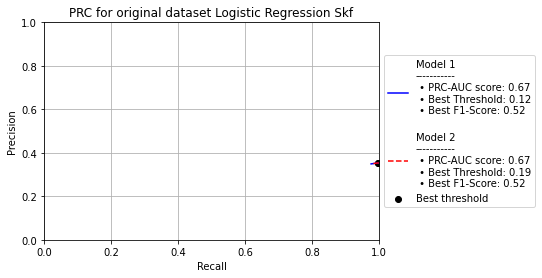

Best Threshold=0.000000, F1-Score=0.521 for model 1
Best Threshold=0.074199, F1-Score=0.522 for model 2


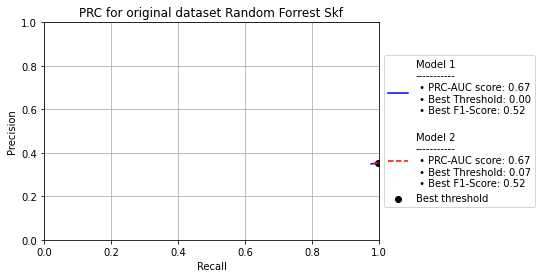

Best Threshold=0.000121, F1-Score=0.521 for model 1
Best Threshold=0.000741, F1-Score=0.522 for model 2


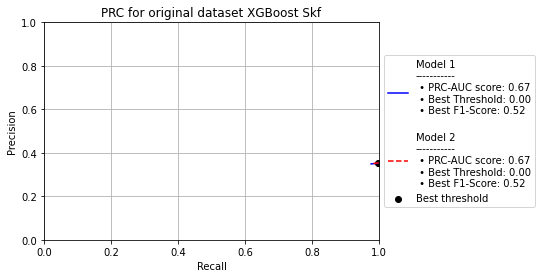

Best Threshold=0.117864, F1-Score=1.000 for model 1
Best Threshold=0.142959, F1-Score=1.000 for model 2


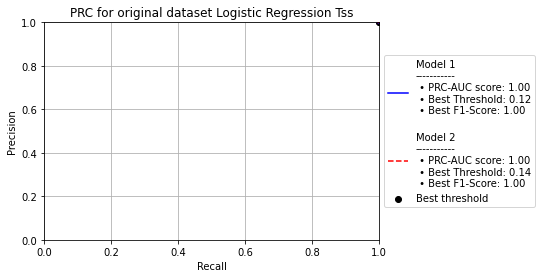

Best Threshold=0.000000, F1-Score=0.998 for model 1
Best Threshold=0.083297, F1-Score=1.000 for model 2


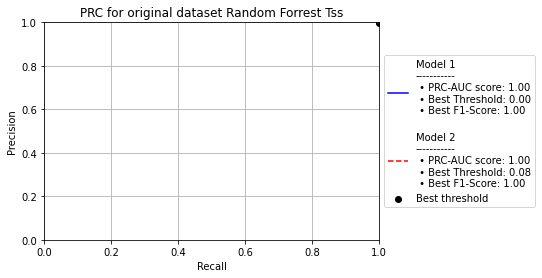

Best Threshold=0.000121, F1-Score=0.998 for model 1
Best Threshold=0.000707, F1-Score=1.000 for model 2


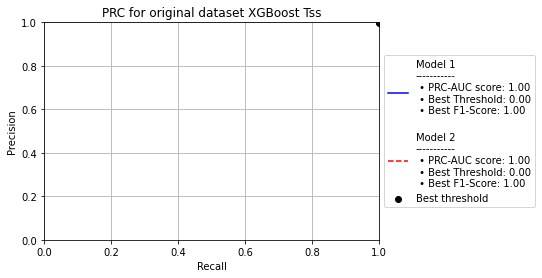

0    15835
1     8622
Name: Bug, dtype: int64
Row 18 model 1

Scores for model 1
------------------
Roc_Auc Score: 0.8631472609563026
Average Precision-Recall Score: 0.7110522602150702
PRC-AUC for model 1: 0.8354179690941542
Accuracy: 0.641
Precision score for model 1:  0.0
Recall score for model 1:  0.0
F1 score for model 1:  0.0
Classification Report:

              precision    recall  f1-score   support

           0       0.64      1.00      0.78      3921
           1       0.00      0.00      0.00      2194

    accuracy                           0.64      6115
   macro avg       0.32      0.50      0.39      6115
weighted avg       0.41      0.64      0.50      6115


Scores for model 2
------------------
Roc_Auc Score: 0.8757734513710504
Average Precision-Recall Score: 0.7178576056870449
PRC-AUC for model 2: 0.8434250437421046
Precision score for model 2:  0.0
Recall score for model 2:  0.0
F1 score for model 2:  0.0
Classification Report:

              precision    recall  f

TRAIN: [    0     1     2 ... 17241 17242 17243] | TEST: [   10    17    26 ... 17216 17219 17239]

Model Score: 0.4918793503480278

Average Precision-Recall Score: 0.5081206496519721
PRC-AUC Score: 0.7540603248259861
Precision:  0.0
Recall:  0.0
F1:  0.0
Classification Report:

              precision    recall  f1-score   support

           0       0.49      1.00      0.66       848
           1       0.00      0.00      0.00       876

    accuracy                           0.49      1724
   macro avg       0.25      0.50      0.33      1724
weighted avg       0.24      0.49      0.32      1724

Accuracy: 0.492
TRAIN: [    0     1     2 ... 17241 17242 17243] | TEST: [   10    17    26 ... 17216 17219 17239]

Model Score: 0.5081206496519721

Average Precision-Recall Score: 0.5141227540340727
PRC-AUC Score: 0.5101886908115476
Precision:  0.5281124497991968
Recall:  0.3002283105022831
F1:  0.38282387190684136
Classification Report:

              precision    recall  f1-score   suppo

TRAIN: [    0     1     2 ... 17241 17242 17243] | TEST: [   10    17    26 ... 17216 17219 17239]

Model Score: 0.4965197215777262

Average Precision-Recall Score: 0.5088444690401984
PRC-AUC Score: 0.5098607825261567
Precision:  0.5117647058823529
Recall:  0.19863013698630136
F1:  0.28618421052631576
Classification Report:

              precision    recall  f1-score   support

           0       0.49      0.80      0.61       848
           1       0.51      0.20      0.29       876

    accuracy                           0.50      1724
   macro avg       0.50      0.50      0.45      1724
weighted avg       0.50      0.50      0.45      1724

Accuracy: 0.497
TRAIN: [    0     1     2 ... 16379 16380 16381] | TEST: [ 7760  7761  7762 ... 17241 17242 17243]

Model Score: 0.5324825986078886

Average Precision-Recall Score: 0.5167905219857201
PRC-AUC Score: 0.8298694326918703
Precision:  0.5169082125603864
Recall:  0.9930394431554525
F1:  0.6799046862589355
Classification Report:

     

Recall score for model 1:  0.9252336448598131
F1 score for model 1:  0.8765254845656856
Classification Report:

              precision    recall  f1-score   support

           0       0.92      0.81      0.86      3959
           1       0.83      0.93      0.88      3959

    accuracy                           0.87      7918
   macro avg       0.87      0.87      0.87      7918
weighted avg       0.87      0.87      0.87      7918


Scores for model 2
------------------
Roc_Auc Score: 0.8921592828130164
Average Precision-Recall Score: 0.8263919571582611
PRC-AUC for model 2: 0.8635467912816884
Precision score for model 2:  0.8326892475562628
Recall score for model 2:  0.9252336448598131
F1 score for model 2:  0.8765254845656856
Classification Report:

              precision    recall  f1-score   support

           0       0.92      0.81      0.86      3959
           1       0.83      0.93      0.88      3959

    accuracy                           0.87      7918
   macro avg      

TRAIN: [    0     1     2 ... 30083 30084 30085] | TEST: [14906 14907 14908 ... 31667 31668 31669]

Model Score: 0.46447742342911275

Average Precision-Recall Score: 0.48298962105421783
PRC-AUC Score: 0.7500036052145823
Precision:  0.4815059445178336
Recall:  0.9204545454545454
F1:  0.632263660017346
Classification Report:

              precision    recall  f1-score   support

           0       0.09      0.01      0.02      1583
           1       0.48      0.92      0.63      1584

    accuracy                           0.46      3167
   macro avg       0.29      0.46      0.32      3167
weighted avg       0.29      0.46      0.32      3167

Accuracy: 0.464
TRAIN: [    0     1     2 ... 30083 30084 30085] | TEST: [14906 14907 14908 ... 31667 31668 31669]

Model Score: 0.45974107988632773

Average Precision-Recall Score: 0.48080621394201006
PRC-AUC Score: 0.32171579985236703
Precision:  0.47910496873971703
Recall:  0.9191919191919192
F1:  0.6298940082197708
Classification Report:

  

TRAIN: [    0     1     2 ... 30083 30084 30085] | TEST: [14906 14907 14908 ... 31667 31668 31669]

Model Score: 0.46353015472055575

Average Precision-Recall Score: 0.4825520589993351
PRC-AUC Score: 0.5673686680927668
Precision:  0.48100429468120254
Recall:  0.9191919191919192
F1:  0.6315332899587943
Classification Report:

              precision    recall  f1-score   support

           0       0.09      0.01      0.01      1583
           1       0.48      0.92      0.63      1584

    accuracy                           0.46      3167
   macro avg       0.28      0.46      0.32      3167
weighted avg       0.28      0.46      0.32      3167

Accuracy: 0.464

Model Score: 0.0

Average Precision-Recall Score: 1.0
PRC-AUC Score: 1.0
Precision:  0.0
Recall:  0.0
F1:  0.0
Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       0.0
           1       0.00      0.00      0.00    5278.0

    accuracy                  

Row 59 model 1

Scores for model 1
------------------
Roc_Auc Score: 0.8885853928680916
Average Precision-Recall Score: 0.8213393728109423
PRC-AUC for model 1: 0.8381087466950563
Accuracy: 0.863
Precision score for model 1:  0.8281535648994516
Recall score for model 1:  0.916772071844169
F1 score for model 1:  0.8702125105054628
Classification Report:

              precision    recall  f1-score   support

           0       0.91      0.81      0.86      3965
           1       0.83      0.92      0.87      3953

    accuracy                           0.86      7918
   macro avg       0.87      0.86      0.86      7918
weighted avg       0.87      0.86      0.86      7918


Scores for model 2
------------------
Roc_Auc Score: 0.888585711874934
Average Precision-Recall Score: 0.8213395895333304
PRC-AUC for model 2: 0.8381087466950563
Precision score for model 2:  0.8281535648994516
Recall score for model 2:  0.916772071844169
F1 score for model 2:  0.8702125105054628
Classification Repo


Model Score: 0.9262978400909435

Average Precision-Recall Score: 1.0
PRC-AUC Score: 1.0
Precision:  1.0
Recall:  0.9262978400909435
F1:  0.961738959378381
Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.93      0.96      5278

    accuracy                           0.93      5278
   macro avg       0.50      0.46      0.48      5278
weighted avg       1.00      0.93      0.96      5278

Accuracy: 0.926
TRAIN: [    0     1     2 ... 31666 31667 31668] | TEST: [    4     5    12 ... 31610 31645 31669]

Model Score: 0.787180296810862

Average Precision-Recall Score: 0.7087663166840005
PRC-AUC Score: 0.8491221699946386
Precision:  0.718369259606373
Recall:  0.9545454545454546
F1:  0.8197860962566845
Classification Report:

              precision    recall  f1-score   support

           0       0.93      0.61      0.74      1561
           1       0.72      0.95      0.82  

Performing analysis for: OpenJPA
                Name                                               File  \
3702   Mark Struberg                                            pom.xml   
3703   Mark Struberg                                    openjpa/pom.xml   
3704   Mark Struberg                           openjpa-features/pom.xml   
3705   Mark Struberg      openjpa-features/src/main/feature/feature.xml   
12652   Jody Grassel  openjpa-kernel/src/main/java/org/apache/openjp...   
...              ...                                                ...   
42108    Stephen Kim  openjpa-kernel/src/main/java/org/apache/openjp...   
42109    Stephen Kim  openjpa-kernel/src/main/java/org/apache/openjp...   
42110    Stephen Kim  openjpa-kernel/src/main/java/org/apache/openjp...   
42111    Stephen Kim  openjpa-kernel/src/main/java/org/apache/openjp...   
42112    Stephen Kim  openjpa-kernel/src/main/java/org/apache/openjp...   

                      Bug  PageRank  Betweenness  Closeness  Harmo


Accuracy: 0.794
Original_XGB model 1

Scores for model 1
------------------
Roc_Auc Score: 0.8630963783676221
Average Precision-Recall Score: 0.6635033794427806
PRC-AUC for model 1: 0.6926055407722546
Accuracy: 0.794
Precision score for model 1:  0.6517046848172676
Recall score for model 1:  0.7812408115260218
F1 score for model 1:  0.7106178122492647
Classification Report:

              precision    recall  f1-score   support

           0       0.88      0.80      0.84      7128
           1       0.65      0.78      0.71      3401

    accuracy                           0.79     10529
   macro avg       0.77      0.79      0.78     10529
weighted avg       0.81      0.79      0.80     10529


Scores for model 2
------------------
Roc_Auc Score: 0.8630942333591064
Average Precision-Recall Score: 0.6634993741587655
PRC-AUC for model 2: 0.6926016644260938
Precision score for model 2:  0.6517046848172676
Recall score for model 2:  0.7812408115260218
F1 score for model 2:  0.7106178122

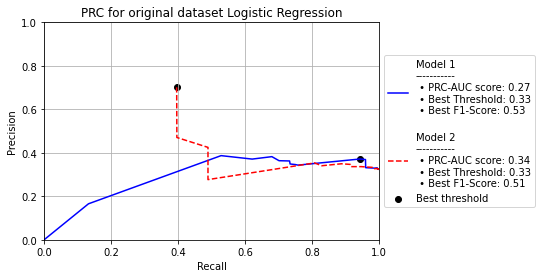

Best Threshold=0.573007, F1-Score=0.711 for model 1
Best Threshold=0.414333, F1-Score=0.711 for model 2


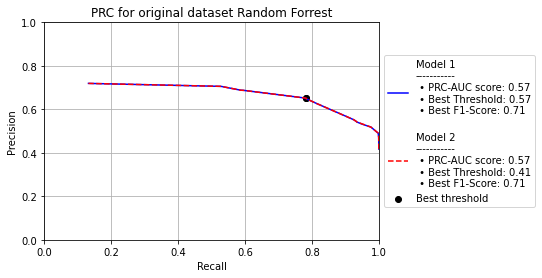

Best Threshold=0.572259, F1-Score=0.711 for model 1
Best Threshold=0.572284, F1-Score=0.711 for model 2


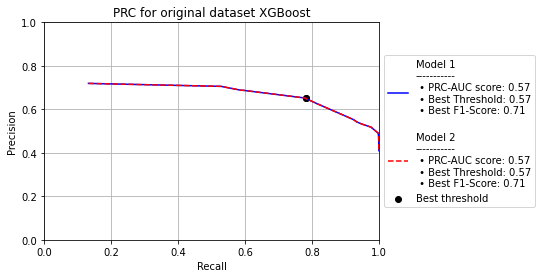

Original_Logistic_Regression_Best_Threshold model 1

Scores for model 1
------------------
Roc_Auc Score: 0.5122686030813542
Average Precision-Recall Score: 0.34818608545717045
PRC-AUC for model 1: 0.27235467767164345
Accuracy: 0.466
Precision score for model 1:  0.3716435185185185
Recall score for model 1:  0.9441340782122905
F1 score for model 1:  0.5333444066107466
Classification Report:

              precision    recall  f1-score   support

           0       0.90      0.24      0.38      7128
           1       0.37      0.94      0.53      3401

    accuracy                           0.47     10529
   macro avg       0.64      0.59      0.46     10529
weighted avg       0.73      0.47      0.43     10529


Scores for model 2
------------------
Roc_Auc Score: 0.5872292256750259
Average Precision-Recall Score: 0.4896238755409967
PRC-AUC for model 2: 0.336888084941793
Precision score for model 2:  0.7011972930765227
Recall score for model 2:  0.39605998235812995
F1 score for model 

TRAIN: [    0     1     2 ... 40604 40605 40606] | TEST: [31048 31049 31050 ... 42113 42114 42115]

Model Score: 0.31773925433388744

Average Precision-Recall Score: 0.3141925721753552
PRC-AUC Score: 0.6493693776595448
Precision:  0.3130456472935894
Recall:  0.913391557496361
F1:  0.4662827419654468
Classification Report:

              precision    recall  f1-score   support

           0       0.41      0.03      0.05      2837
           1       0.31      0.91      0.47      1374

    accuracy                           0.32      4211
   macro avg       0.36      0.47      0.26      4211
weighted avg       0.38      0.32      0.19      4211

Accuracy: 0.318
Original_XGB_Classifier_skf model 1
TRAIN: [    0     1     2 ... 40604 40605 40606] | TEST: [31048 31049 31050 ... 42113 42114 42115]

Model Score: 0.31773925433388744

Average Precision-Recall Score: 0.3141925721753552
PRC-AUC Score: 0.21550171779905217
Precision:  0.3130456472935894
Recall:  0.913391557496361
F1:  0.46628274196

TRAIN: [    0     1     2 ... 40604 40605 40606] | TEST: [31048 31049 31050 ... 42113 42114 42115]

Model Score: 0.33270007124198525

Average Precision-Recall Score: 0.3252486552356556
PRC-AUC Score: 0.21550171779905217
Precision:  0.3252190847127556
Recall:  0.9723435225618632
F1:  0.4874133527909523
Classification Report:

              precision    recall  f1-score   support

           0       0.63      0.02      0.04      2837
           1       0.33      0.97      0.49      1374

    accuracy                           0.33      4211
   macro avg       0.48      0.50      0.27      4211
weighted avg       0.53      0.33      0.19      4211

Accuracy: 0.333
Row 14 model 2

Model Score: 0.21840718051004415

Average Precision-Recall Score: 0.7815928194899558
PRC-AUC Score: 0.9285476553051919
Precision:  0.0
Recall:  0.0
F1:  0.0
Classification Report:

              precision    recall  f1-score   support

           0       0.22      1.00      0.36      1533
           1       0.00 

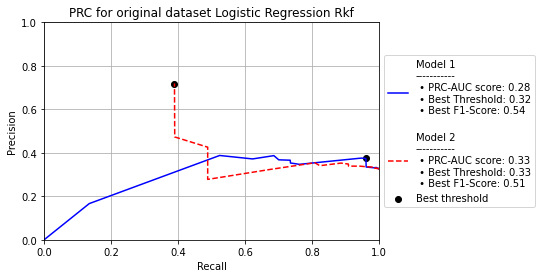

Best Threshold=0.392999, F1-Score=0.719 for model 1
Best Threshold=0.384814, F1-Score=0.719 for model 2


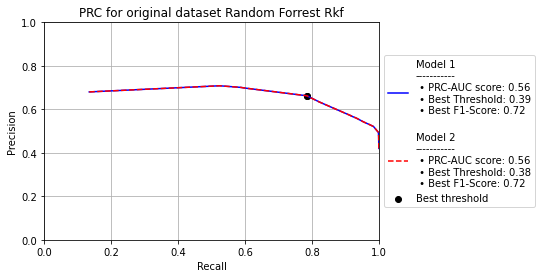

Best Threshold=0.385237, F1-Score=0.719 for model 1
Best Threshold=0.385861, F1-Score=0.719 for model 2


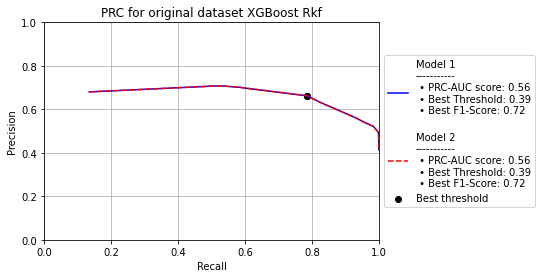

Best Threshold=0.330176, F1-Score=0.729 for model 1
Best Threshold=0.327441, F1-Score=0.524 for model 2


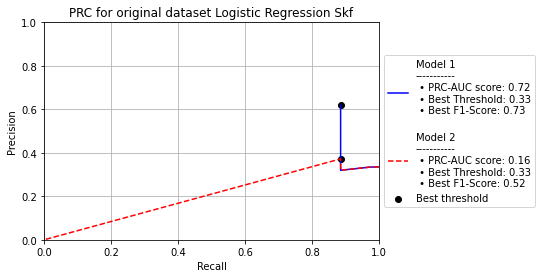

Best Threshold=1.000000, F1-Score=0.611 for model 1
Best Threshold=1.000000, F1-Score=0.611 for model 2


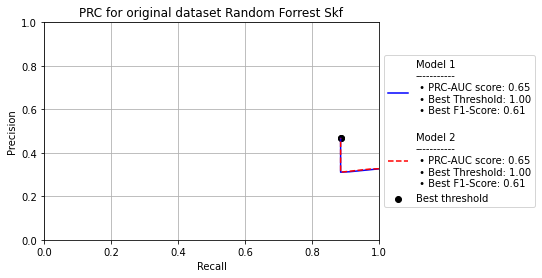

Best Threshold=0.999251, F1-Score=0.628 for model 1
Best Threshold=0.999808, F1-Score=0.628 for model 2


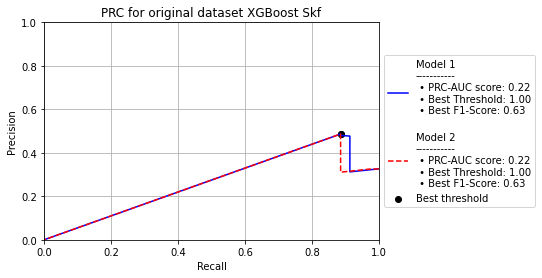

Best Threshold=0.232351, F1-Score=0.883 for model 1
Best Threshold=0.225444, F1-Score=0.883 for model 2


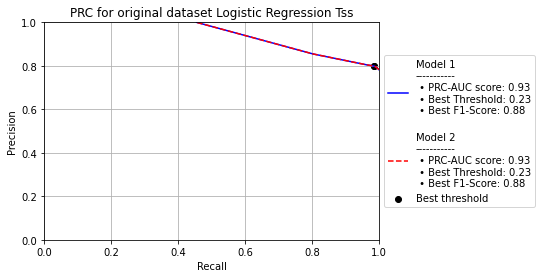

Best Threshold=0.000000, F1-Score=0.877 for model 1
Best Threshold=0.202936, F1-Score=0.883 for model 2


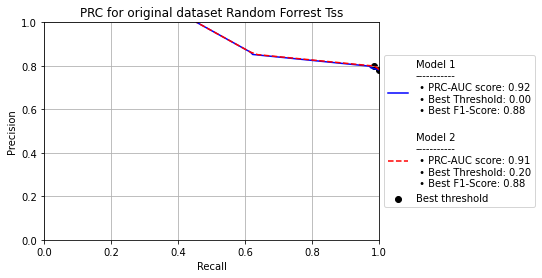

Best Threshold=0.000083, F1-Score=0.877 for model 1
Best Threshold=0.002181, F1-Score=0.879 for model 2


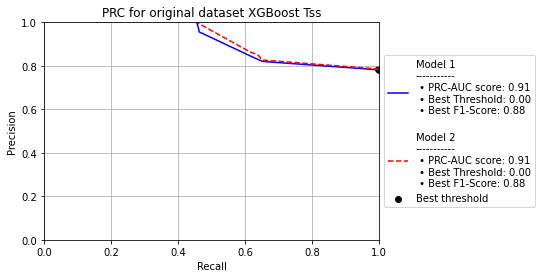

0    28370
1    13746
Name: Bug, dtype: int64
Row 18 model 1

Scores for model 1
------------------
Roc_Auc Score: 0.511886678918844
Average Precision-Recall Score: 0.3551001338661938
PRC-AUC for model 1: 0.29826714606807697
Accuracy: 0.670
Precision score for model 1:  0.0
Recall score for model 1:  0.0
F1 score for model 1:  0.0
Classification Report:

              precision    recall  f1-score   support

           0       0.67      1.00      0.80      7054
           1       0.00      0.00      0.00      3475

    accuracy                           0.67     10529
   macro avg       0.33      0.50      0.40     10529
weighted avg       0.45      0.67      0.54     10529


Scores for model 2
------------------
Roc_Auc Score: 0.5812652650774192
Average Precision-Recall Score: 0.4972409861882082
PRC-AUC for model 2: 0.5470354743915135
Precision score for model 2:  0.0
Recall score for model 2:  0.0
F1 score for model 2:  0.0
Classification Report:

              precision    recall  f

TRAIN: [    0     1     3 ... 27489 27490 27491] | TEST: [    2    22    30 ... 27416 27422 27460]

Model Score: 0.4867224445252819

Average Precision-Recall Score: 0.5147778500896426
PRC-AUC Score: 0.7571844307020734
Precision:  0.5483870967741935
Recall:  0.012022630834512023
F1:  0.023529411764705882
Classification Report:

              precision    recall  f1-score   support

           0       0.49      0.99      0.65      1335
           1       0.55      0.01      0.02      1414

    accuracy                           0.49      2749
   macro avg       0.52      0.50      0.34      2749
weighted avg       0.52      0.49      0.33      2749

Accuracy: 0.487
TRAIN: [    0     1     3 ... 27489 27490 27491] | TEST: [    2    22    30 ... 27416 27422 27460]

Model Score: 0.5070934885412878

Average Precision-Recall Score: 0.5172840440429973
PRC-AUC Score: 0.5204530574213273
Precision:  0.519653564290473
Recall:  0.5516265912305516
F1:  0.5351629502572898
Classification Report:

    

TRAIN: [    0     1     3 ... 27489 27490 27491] | TEST: [    2    22    30 ... 27416 27422 27460]

Model Score: 0.5070934885412878

Average Precision-Recall Score: 0.5172840440429973
PRC-AUC Score: 0.520627857485247
Precision:  0.519653564290473
Recall:  0.5516265912305516
F1:  0.5351629502572898
Classification Report:

              precision    recall  f1-score   support

           0       0.49      0.46      0.48      1335
           1       0.52      0.55      0.54      1414

    accuracy                           0.51      2749
   macro avg       0.51      0.51      0.51      2749
weighted avg       0.51      0.51      0.51      2749

Accuracy: 0.507
TRAIN: [    0     1     2 ... 26114 26115 26116] | TEST: [12372 12373 12374 ... 27489 27490 27491]

Model Score: 0.5121862495452892

Average Precision-Recall Score: 0.5063041215506354
PRC-AUC Score: 0.6924465574339659
Precision:  0.5074955908289241
Recall:  0.8370909090909091
F1:  0.6318967883612409
Classification Report:

         

Average Precision-Recall Score: 0.5168434698144424
PRC-AUC for model 1: 0.4257874202120617
Accuracy: 0.502
Precision score for model 1:  0.5015161131090896
Recall score for model 1:  1.0
F1 score for model 1:  0.6680129620062931
Classification Report:

              precision    recall  f1-score   support

           0       1.00      0.00      0.00      7073
           1       0.50      1.00      0.67      7112

    accuracy                           0.50     14185
   macro avg       0.75      0.50      0.33     14185
weighted avg       0.75      0.50      0.34     14185


Scores for model 2
------------------
Roc_Auc Score: 0.5721211022540604
Average Precision-Recall Score: 0.6392818248805072
PRC-AUC for model 2: 0.657910622280719
Precision score for model 2:  0.5019054340155258
Recall score for model 2:  1.0
F1 score for model 2:  0.6683582370078001
Classification Report:

              precision    recall  f1-score   support

           0       1.00      0.00      0.00      7073
  

TRAIN: [    0     1     2 ... 53900 53901 53902] | TEST: [31048 31049 31050 ... 56737 56738 56739]

Model Score: 0.38297497356362353

Average Precision-Recall Score: 0.44926728429420204
PRC-AUC Score: 0.37984364102646473
Precision:  0.43352022426912296
Recall:  0.7631300669721537
F1:  0.5529306601966544
Classification Report:

              precision    recall  f1-score   support

           0       0.01      0.00      0.00      2837
           1       0.43      0.76      0.55      2837

    accuracy                           0.38      5674
   macro avg       0.22      0.38      0.28      5674
weighted avg       0.22      0.38      0.28      5674

Accuracy: 0.383

Model Score: 0.0

Average Precision-Recall Score: 1.0
PRC-AUC Score: 1.0
Precision:  0.0
Recall:  0.0
F1:  0.0
Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       0.0
           1       0.00      0.00      0.00    9456.0

    accuracy                


Model Score: 0.0

Average Precision-Recall Score: 1.0
PRC-AUC Score: 1.0
Precision:  0.0
Recall:  0.0
F1:  0.0
Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       0.0
           1       0.00      0.00      0.00    9456.0

    accuracy                           0.00    9456.0
   macro avg       0.00      0.00      0.00    9456.0
weighted avg       0.00      0.00      0.00    9456.0

Accuracy: 0.000

Model Score: 0.7645939086294417

Average Precision-Recall Score: 1.0
PRC-AUC Score: 1.0
Precision:  1.0
Recall:  0.7645939086294417
F1:  0.8665947500898958
Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.76      0.87      9456

    accuracy                           0.76      9456
   macro avg       0.50      0.38      0.43      9456
weighted avg       1.00      0.76      0.87      9456

Accuracy: 0.7

Row 59 model 1

Scores for model 1
------------------
Roc_Auc Score: 0.8601115440074075
Average Precision-Recall Score: 0.7979338574289805
PRC-AUC for model 1: 0.7980775910430891
Accuracy: 0.787
Precision score for model 1:  0.7973130841121495
Recall score for model 1:  0.7696645052156752
F1 score for model 1:  0.7832448716109596
Classification Report:

              precision    recall  f1-score   support

           0       0.78      0.80      0.79      7091
           1       0.80      0.77      0.78      7094

    accuracy                           0.79     14185
   macro avg       0.79      0.79      0.79     14185
weighted avg       0.79      0.79      0.79     14185


Scores for model 2
------------------
Roc_Auc Score: 0.8601120012315631
Average Precision-Recall Score: 0.7979339958221132
PRC-AUC for model 2: 0.7980775910430891
Precision score for model 2:  0.7973130841121495
Recall score for model 2:  0.7696645052156752
F1 score for model 2:  0.7832448716109596
Classification R


Model Score: 0.7726311336717429

Average Precision-Recall Score: 1.0
PRC-AUC Score: 1.0
Precision:  1.0
Recall:  0.7726311336717429
F1:  0.8717336833313447
Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.77      0.87      9456

    accuracy                           0.77      9456
   macro avg       0.50      0.39      0.44      9456
weighted avg       1.00      0.77      0.87      9456

Accuracy: 0.773
TRAIN: [    0     2     3 ... 56736 56737 56738] | TEST: [    1    21    31 ... 56725 56730 56739]

Model Score: 0.5534014804370814

Average Precision-Recall Score: 0.5316503370197828
PRC-AUC Score: 0.663135715353789
Precision:  0.5349276274386406
Recall:  0.88943146145797
F1:  0.6680639245480744
Classification Report:

              precision    recall  f1-score   support

           0       0.65      0.21      0.32      2807
           1       0.53      0.89      0.67  

In [23]:
# Create a dataframe of all of the unique commits (i.e. links) between developers and the corresponding folders

start = 0

if os.path.exists('out.csv'):
    final_result_df = pd.read_csv('out.csv', index_col=0)
    print(final_result_df)
    for index, row in final_result_df.iterrows():
        print()
        if math.isnan(row['XGB_precision_1']):
            break
        start += 1
else:
    final_result_df = pd.DataFrame({'XGB_precision_1':[None]*14, 
                                'XGB_precision_2':[None]*14,
                                'XGB_recall_1':[None]*14, 
                                'XGB_recall_2':[None]*14,
                                'XGB_f1_1':[None]*14, 
                                'XGB_f1_2':[None]*14,
                                'XGB_PRC_AUC_1':[None]*14,
                                'XGB_PRC_AUC_2':[None]*14,
                                'LR_precision_1':[None]*14, 
                                'LR_precision_2':[None]*14, 
                                'LR_recall_1':[None]*14, 
                                'LR_recall_2':[None]*14, 
                                'LR_f1_1':[None]*14, 
                                'LR_f1_2':[None]*14, 
                                'LR_PRC_AUC_1':[None]*14, 
                                'LR_PRC_AUC_2':[None]*14,
                                'RF_precision_1':[None]*14, 
                                'RF_precision_2':[None]*14,
                                'RF_recall_1':[None]*14, 
                                'RF_recall_2':[None]*14,
                                'RF_f1_1':[None]*14, 
                                'RF_f1_2':[None]*14,
                                'RF_PRC_AUC_1':[None]*14, 
                                'RF_PRC_AUC_2':[None]*14})

rankings = {'XGB':[], 'Logistic_Regression':[], 'Random_Forest':[]}

files = ['ActiveMQ', 'Ant', 'Camel', 'Derby', 'Geronimo', 'Hadoop', 'HBase', 'Ivy', 'JCR', 'JMeter', 'LOG4J2', 'Lucene', 'Mahout', 'OpenJPA']

for file_index in range(start, len(files)):
    print(math.isnan(final_result_df.iloc[file_index]['XGB_precision_1']))
    if math.isnan(final_result_df.iloc[file_index]['XGB_precision_1']):
        pass
    else:
        continue
    graph_df = pd.read_csv(f"../Neo4j_output/Jit_Reliability_Output/{files[file_index]}.csv")
    print(f"Performing analysis for: {files[file_index]}")
    print(graph_df.loc[graph_df['Bug'] == "INTRODUCED_NEW_BUG"])
    new_columns = {}

    # Generate binary classification for our dataframe based on if a developer 
    # introduced a bug or not with the corresponding commit
    for index in graph_df.index:
        if graph_df.loc[index, "Bug"] != "INTRODUCED_NEW_BUG":
            graph_df.loc[index, "Bug"] = 0
        else:
            graph_df.loc[index, "Bug"] = 1

        # separate each node2vec embedding into it's own unique label
        embeddings = literal_eval(graph_df.loc[index, 'n2vEmbedding'])
        for i, embedding in enumerate(embeddings):
            if f"emb_{i}" not in new_columns:
                new_columns[f"emb_{i}"] = []
                new_columns[f"emb_{i}"].append(embedding)
            else:
                new_columns[f"emb_{i}"].append(embedding)

    # delete the n2vEmbedding label, as the list has now been separated into their own unique labels 
    del graph_df['n2vEmbedding']
    temp_df = pd.DataFrame.from_dict(new_columns)
    graph_df = graph_df.join(temp_df)
    
    # Normalize the dataframe
    subset = graph_df.select_dtypes('number')
    graph_df[subset.columns] = subset.div(subset.sum(axis=1), axis=0)
    #graph_df = graph_df[~graph_df.isin([np.nan, np.inf, -np.inf]).any(1)]
    print(graph_df)
    
    x = graph_df["Name"]
    y = graph_df["Bug"].astype('int')

    lr_model1 = LogisticRegression(solver='liblinear', random_state=0)
    lr_model2 = LogisticRegression(solver='liblinear', random_state=0)
    rf_model1 = RandomForestClassifier(n_estimators=120)
    rf_model2 = RandomForestClassifier(n_estimators=120)
    xgb_model1 = XGBClassifier(verbosity = 0)
    xgb_model2 = XGBClassifier(verbosity = 0)

    '''
    train_test_split params
    -----------------------
    graph_df: Graph dataset
    test_size: float value between 0.0 and 1.0 representing the precentage of data to be put into the test dataset
    random_state = used to create reproducible, or deterministic results.
    '''
    try:
        train, test = train_test_split(graph_df, test_size=0.25, random_state = 5)
    except Exception as e:
        print(e)
        continue
    train = train.reset_index()
    test = test.reset_index()

    # Labels used for model 1
    labels1 = ['PageRank', 'Betweenness', 'Closeness', 'Harmonic', 'Degree']

    # Labels used for model 2
    labels2 = set(list(graph_df.columns))
    labels2.difference_update(['index', 'Bug', 'Name', 'File', 'PageRank', 'Betweenness', 'Closeness', 'Harmonic', 'Degree'])

    x1_train = train[labels1]
    x2_train = train[labels2]
    y_train = train["Bug"]
    x1_test = test[labels1]
    x2_test = test[labels2]
    y_test = test["Bug"]
    y_train = y_train.astype('int')
    y_test = y_test.astype('int')

    lr_model1.fit(x1_train, y_train)
    lr_model2.fit(x2_train, y_train)
    rf_model1.fit(x1_train, y_train)
    rf_model2.fit(x2_train, y_train)
    xgb_model1.fit(x1_train, y_train)
    xgb_model2.fit(x2_train, y_train)

    lr_predictions1 = lr_model1.predict(x1_test)
    lr_predictions2 = lr_model2.predict(x2_test)
    lr_prediction_probs1 = lr_model1.predict_proba(x1_test)
    lr_prediction_probs2 = lr_model2.predict_proba(x2_test)

    rf_predictions1 = rf_model1.predict(x1_test)
    rf_predictions2 = rf_model2.predict(x2_test)
    rf_prediction_probs1 = rf_model1.predict_proba(x1_test)
    rf_prediction_probs2 = rf_model2.predict_proba(x2_test)

    xgb_predictions1 = xgb_model1.predict(x1_test)
    xgb_predictions2 = xgb_model2.predict(x2_test)
    xgb_prediction_probs1 = xgb_model1.predict_proba(x1_test)
    xgb_prediction_probs2 = xgb_model2.predict_proba(x2_test)

    results_data = [[None for j in range(15)] for i in range(72)]

    # Score returns the mean accuracy on the given test data and labels for the provided model.
    print("Original_Logistic_Regression model 1")
    acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2, prec_1, prec_2, rec_1, rec_2, f1_1, f1_2 = Compare_Model_Scores(x1_test, x2_test, y_test, lr_predictions1, lr_predictions2, lr_prediction_probs1, lr_prediction_probs2, lr_model1, lr_model2)
    results_data[0][0] = "Original_Logistic_Regression"
    results_data[0][1] = lr_model1.score(x1_test, y_test)
    results_data[0][2] = lr_model2.score(x2_test, y_test)
    results_data[0][3] = acc1
    results_data[0][4] = acc2
    results_data[0][5] = prc_val1
    results_data[0][6] = prc_val2
    results_data[0][7] = pr_auc1
    results_data[0][8] = pr_auc2
    results_data[0][9] = prec_1
    results_data[0][10] = prec_2
    results_data[0][11] = rec_1
    results_data[0][12] = rec_2
    results_data[0][13] = f1_1
    results_data[0][14] = f1_2

    print("Original_Random_Forrest model 1")
    acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2, prec_1, prec_2, rec_1, rec_2, f1_1, f1_2 = Compare_Model_Scores(x1_test, x2_test, y_test, rf_predictions1, rf_predictions2, rf_prediction_probs1, rf_prediction_probs2, rf_model1, rf_model2)
    results_data[1][0] = "Original_Random_Forrest"
    results_data[1][1] = rf_model1.score(x1_test, y_test)
    results_data[1][2] = rf_model2.score(x2_test, y_test)
    results_data[1][3] = acc1
    results_data[1][4] = acc2
    results_data[1][5] = prc_val1
    results_data[1][6] = prc_val2
    results_data[1][7] = pr_auc1
    results_data[1][8] = pr_auc2
    results_data[1][9] = prec_1
    results_data[1][10] = prec_2
    results_data[1][11] = rec_1
    results_data[1][12] = rec_2
    results_data[1][13] = f1_1
    results_data[1][14] = f1_2

    print("Original_XGB model 1")
    acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2, prec_1, prec_2, rec_1, rec_2, f1_1, f1_2 = Compare_Model_Scores(x1_test, x2_test, y_test, xgb_predictions1, xgb_predictions2, xgb_prediction_probs1, xgb_prediction_probs2, xgb_model1, xgb_model2)
    results_data[2][0] = "Original_XGB_Classifier"
    results_data[2][1] = xgb_model1.score(x1_test, y_test)
    results_data[2][2] = xgb_model2.score(x2_test, y_test)
    results_data[2][3] = acc1
    results_data[2][4] = acc2
    results_data[2][5] = prc_val1
    results_data[2][6] = prc_val2
    results_data[2][7] = pr_auc1
    results_data[2][8] = pr_auc2
    results_data[2][9] = prec_1
    results_data[2][10] = prec_2
    results_data[2][11] = rec_1
    results_data[2][12] = rec_2
    results_data[2][13] = f1_1
    results_data[2][14] = f1_2

    lr_best_threshold1, lr_best_threshold2, lr_og_fig = plot_thresholds(lr_model1, lr_model2, x1_test, y_test, x2_test, y_test, lr_prediction_probs1, lr_prediction_probs2, "original dataset Logistic Regression")
    rf_best_threshold1, rf_best_threshold2, rf_og_fig = plot_thresholds(rf_model1, rf_model2, x1_test, y_test, x2_test, y_test, rf_prediction_probs1, rf_prediction_probs2, "original dataset Random Forrest")
    xgb_best_threshold1, xgb_best_threshold2, xgb_og_fig = plot_thresholds(xgb_model1, xgb_model2, x1_test, y_test, x2_test, y_test, xgb_prediction_probs1, xgb_prediction_probs2, "original dataset XGBoost")

    lr_prediction_bestthresh1 = (lr_model1.predict_proba(x1_test)[:,1] >= lr_best_threshold1).astype(int)
    lr_prediction_bestthresh2 = (lr_model2.predict_proba(x2_test)[:,1] >= lr_best_threshold2).astype(int)
    print("Original_Logistic_Regression_Best_Threshold model 1")
    acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2, prec_1, prec_2, rec_1, rec_2, f1_1, f1_2 = Compare_Model_Scores_Best_Threshold(x1_test, x2_test, y_test, lr_prediction_bestthresh1, lr_prediction_bestthresh2, lr_prediction_probs1, lr_prediction_probs2, lr_model1, lr_model2)

    results_data[3][0] = "Original_Logistic_Regression_Best_Threshold"
    results_data[3][1] = lr_model1.score(x1_test, y_test)
    results_data[3][2] = lr_model2.score(x2_test, y_test)
    results_data[3][3] = acc1
    results_data[3][4] = acc2
    results_data[3][5] = prc_val1
    results_data[3][6] = prc_val2
    results_data[3][7] = pr_auc1
    results_data[3][8] = pr_auc2
    results_data[3][9] = prec_1
    results_data[3][10] = prec_2
    results_data[3][11] = rec_1
    results_data[3][12] = rec_2
    results_data[3][13] = f1_1
    results_data[3][14] = f1_2

    rf_prediction_bestthresh1 = (rf_model1.predict_proba(x1_test)[:,1] >= rf_best_threshold1).astype(int)
    rf_prediction_bestthresh2 = (rf_model2.predict_proba(x2_test)[:,1] >= rf_best_threshold2).astype(int)
    print("Original_Random_Forrest_Best_Threshold model 1")
    acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2, prec_1, prec_2, rec_1, rec_2, f1_1, f1_2 = Compare_Model_Scores_Best_Threshold(x1_test, x2_test, y_test, rf_prediction_bestthresh1, rf_prediction_bestthresh2, rf_prediction_probs1, rf_prediction_probs2, rf_model1, rf_model2)
    
    results_data[4][0] = "Original_Random_Forrest_Best_Threshold"
    results_data[4][1] = rf_model1.score(x1_test, y_test)
    results_data[4][2] = rf_model2.score(x2_test, y_test)
    results_data[4][3] = acc1
    results_data[4][4] = acc2
    results_data[4][5] = prc_val1
    results_data[4][6] = prc_val2
    results_data[4][7] = pr_auc1
    results_data[4][8] = pr_auc2
    results_data[4][9] = prec_1
    results_data[4][10] = prec_2
    results_data[4][11] = rec_1
    results_data[4][12] = rec_2
    results_data[4][13] = f1_1
    results_data[4][14] = f1_2

    xgb_prediction_bestthresh1 = (xgb_model1.predict_proba(x1_test)[:,1] >= xgb_best_threshold1).astype(int)
    xgb_prediction_bestthresh2 = (xgb_model2.predict_proba(x2_test)[:,1] >= xgb_best_threshold2).astype(int)
    print("Original_XGBoost_Classifier_Best_Threshold model 1")
    acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2, prec_1, prec_2, rec_1, rec_2, f1_1, f1_2 = Compare_Model_Scores_Best_Threshold(x1_test, x2_test, y_test, xgb_prediction_bestthresh1, xgb_prediction_bestthresh2, xgb_prediction_probs1, xgb_prediction_probs2, xgb_model1, xgb_model2)
    
    results_data[5][0] = "Original_XGBoost_Classifier_Best_Threshold"
    results_data[5][1] = xgb_model1.score(x1_test, y_test)
    results_data[5][2] = xgb_model2.score(x2_test, y_test)
    results_data[5][3] = acc1
    results_data[5][4] = acc2
    results_data[5][5] = prc_val1
    results_data[5][6] = prc_val2
    results_data[5][7] = pr_auc1
    results_data[5][8] = pr_auc2
    results_data[5][9] = prec_1
    results_data[5][10] = prec_2
    results_data[5][11] = rec_1
    results_data[5][12] = rec_2
    results_data[5][13] = f1_1
    results_data[5][14] = f1_2

    x1 = graph_df[labels1]
    x2 = graph_df[labels2]
    y = graph_df['Bug'].astype('int')

    print("Original_XGBoost_Classifier_Best_Threshold model 1")
    model_score, acc, prc_val, y1_lr_test_rkf, pr_auc, lr_rkf_prediction_probs1, precision, recall, f1 = Rkf(lr_model1, x1, y)
    
    results_data[6][0] = "Original_Logistic_Regression_rkf"
    results_data[6][1] = model_score
    results_data[6][3] = acc
    results_data[6][5] = prc_val
    results_data[6][7] = pr_auc
    results_data[6][9] = precision
    results_data[6][11] = recall
    results_data[6][13] = f1
    print("---------------------")
    print("With best threshold")
    
    print("Original_Logistic_Regression_rkf_Best_Threshold model 1")
    model_score, acc, prc_val, y1_lr_test_rkf_best, pr_auc, lr_rkf_best_prediction_probs1, precision, recall, f1 = Rkf(lr_model1, x1, y, lr_best_threshold1)
    results_data[7][0] = "Original_Logistic_Regression_rkf_Best_Threshold"
    results_data[7][1] = model_score
    results_data[7][3] = acc
    results_data[7][5] = prc_val
    results_data[7][7] = pr_auc
    results_data[7][9] = precision
    results_data[7][11] = recall
    results_data[7][13] = f1

    # Rkf_short(lr_model1, x1, y)
    print("Original_Random_Forrest_rkf model 1")
    model_score, acc, prc_val, y1_rf_test_rkf, pr_auc, rf_rkf_prediction_probs1, precision, recall, f1 = Rkf(rf_model1, x1, y)
    results_data[8][0] = "Original_Random_Forrest_rkf"
    results_data[8][1] = model_score
    results_data[8][3] = acc
    results_data[8][5] = prc_val
    results_data[8][7] = pr_auc
    results_data[8][9] = precision
    results_data[8][11] = recall
    results_data[8][13] = f1

    print("Original_XGB_Classifier_rkf model 1")
    model_score, acc, prc_val, y1_xgb_test_rkf, pr_auc, xgb_rkf_prediction_probs1, precision, recall, f1 = Rkf(xgb_model1, x1, y)
    results_data[9][0] = "Original_XGB_Classifier_rkf"
    results_data[9][1] = model_score
    results_data[9][3] = acc
    results_data[9][5] = prc_val
    results_data[9][7] = pr_auc
    results_data[9][9] = precision
    results_data[9][11] = recall
    results_data[9][13] = f1

    print("Original_Logistic_Regression_skf model 1")
    model_score, acc, prc_val, y1_lr_test_skf, pr_auc, lr_skf_prediction_probs1, precision, recall, f1 = Skf(lr_model1, x1, y)
    results_data[10][0] = "Original_Logistic_Regression_skf"
    results_data[10][1] = model_score
    results_data[10][3] = acc
    results_data[10][5] = prc_val
    results_data[10][7] = pr_auc
    results_data[10][9] = precision
    results_data[10][11] = recall
    results_data[10][13] = f1

    print("Original_Logistic_Regression_skf_Best_Threshold model 1")
    model_score, acc, prc_val, y1_lr_test_rkf_best, pr_auc, lr_skf_best_prediction_probs1, precision, recall, f1 = Skf(lr_model1, x1, y, lr_best_threshold1)
    results_data[11][0] = "Original_Logistic_Regression_skf_Best_Threshold"
    results_data[11][1] = model_score
    results_data[11][3] = acc
    results_data[11][5] = prc_val
    results_data[11][7] = pr_auc
    results_data[11][9] = precision
    results_data[11][11] = recall
    results_data[11][13] = f1

    print("Original_Random_Forrest_skf model 1")
    # Skf_short(lr_model1, x1, y)
    model_score, acc, prc_val, y1_rf_test_skf, pr_auc, rf_skf_prediction_probs1, precision, recall, f1 = Skf(rf_model1, x1, y)
    results_data[12][0] = "Original_Random_Forrest_skf"
    results_data[12][1] = model_score
    results_data[12][3] = acc
    results_data[12][5] = prc_val
    results_data[12][7] = pr_auc
    results_data[12][9] = precision
    results_data[12][11] = recall
    results_data[12][13] = f1

    print("Original_XGB_Classifier_skf model 1")
    model_score, acc, prc_val, y1_xgb_test_skf, pr_auc, xgb_skf_prediction_probs1, precision, recall, f1 = Skf(xgb_model1, x1, y)
    results_data[13][0] = "Original_XGB_Classifier_skf"
    results_data[13][1] = model_score
    results_data[13][3] = acc
    results_data[13][5] = prc_val
    results_data[13][7] = pr_auc
    results_data[13][9] = precision
    results_data[13][11] = recall
    results_data[13][13] = f1

    print("Original_Logistic_Regression_tss model 1")
    model_score, acc, prc_val, y1_lr_test_tss, pr_auc, lr_tss_prediction_probs1, precision, recall, f1 = Tss(lr_model1, x1, y)
    results_data[14][0] = "Original_Logistic_Regression_tss"
    results_data[14][1] = model_score
    results_data[14][3] = acc
    results_data[14][5] = prc_val
    results_data[14][7] = pr_auc
    results_data[14][9] = precision
    results_data[14][11] = recall
    results_data[14][13] = f1

    print("Original_Logistic_Regression_tss_Best_Threshold model 1")
    model_score, acc, prc_val, y1_lr_test_tss_best, pr_auc, lr_tss_best_prediction_probs1, precision, recall, f1 = Tss(lr_model1, x1, y, lr_best_threshold1)
    results_data[15][0] = "Original_Logistic_Regression_tss_Best_Threshold"
    results_data[15][1] = model_score
    results_data[15][3] = acc
    results_data[15][5] = prc_val
    results_data[15][7] = pr_auc
    results_data[15][9] = precision
    results_data[15][11] = recall
    results_data[15][13] = f1

    # Skf_short(lr_model1, x1, y)
    print("Original_Random_Forrest_tss model 1")
    model_score, acc, prc_val, y1_rf_test_tss, pr_auc, rf_tss_prediction_probs1, precision, recall, f1 = Tss(rf_model1, x1, y)
    results_data[16][0] = "Original_Random_Forrest_tss"
    results_data[16][1] = model_score
    results_data[16][3] = acc
    results_data[16][5] = prc_val
    results_data[16][7] = pr_auc
    results_data[16][9] = precision
    results_data[16][11] = recall
    results_data[16][13] = f1

    print("Original_XGB_Classifier_tss model 1")
    model_score, acc, prc_val, y1_xgb_test_tss, pr_auc, xgb_tss_prediction_probs1, precision, recall, f1 = Tss(xgb_model1, x1, y)
    results_data[17][0] = "Original_XGB_Classifier_tss"
    results_data[17][1] = model_score
    results_data[17][3] = acc
    results_data[17][5] = prc_val
    results_data[17][7] = pr_auc
    results_data[17][9] = precision
    results_data[17][11] = recall
    results_data[17][13] = f1

    # ---- Data for Model 2 ----
    print("Row 6 model 2")
    model_score, acc, prc_val, y2_lr_test_rkf, pr_auc, lr_rkf_prediction_probs2, precision, recall, f1 = Rkf(lr_model2, x2, y)
    results_data[6][2] = model_score
    results_data[6][4] = acc
    results_data[6][6] = prc_val
    results_data[6][8] = pr_auc
    results_data[6][10] = precision
    results_data[6][12] = recall
    results_data[6][14] = f1

    print("Row 7 model 2")
    model_score, acc, prc_val, y2_lr_test_rkf_best, pr_auc, lr_rkf_best_prediction_probs2, precision, recall, f1 = Rkf(lr_model2, x2, y, lr_best_threshold2)
    results_data[7][2] = model_score
    results_data[7][4] = acc
    results_data[7][6] = prc_val
    results_data[7][8] = pr_auc
    results_data[7][10] = precision
    results_data[7][12] = recall
    results_data[7][14] = f1

    # Rkf_short(lr_model2, x2, y)

    print("Row 8 model 2")
    model_score, acc, prc_val, y2_rf_test_rkf, pr_auc, rf_rkf_prediction_probs2, precision, recall, f1 = Rkf(rf_model2, x2, y)
    results_data[8][2] = model_score
    results_data[8][4] = acc
    results_data[8][6] = prc_val
    results_data[8][8] = pr_auc
    results_data[8][10] = precision
    results_data[8][12] = recall
    results_data[8][14] = f1

    print("Row 9 model 2")
    model_score, acc, prc_val, y2_xgb_test_rkf, pr_auc, xgb_rkf_prediction_probs2, precision, recall, f1 = Rkf(xgb_model2, x2, y)
    results_data[9][2] = model_score
    results_data[9][4] = acc
    results_data[9][6] = prc_val
    results_data[9][8] = pr_auc
    results_data[9][10] = precision
    results_data[9][12] = recall
    results_data[9][14] = f1

    print("Row 10 model 2")
    model_score, acc, prc_val, y2_lr_test_skf, pr_auc, lr_skf_prediction_probs2, precision, recall, f1 = Skf(lr_model2, x2, y)
    results_data[10][2] = model_score
    results_data[10][4] = acc
    results_data[10][6] = prc_val
    results_data[10][8] = pr_auc
    results_data[10][10] = precision
    results_data[10][12] = recall
    results_data[10][14] = f1

    print("Row 11 model 2")
    model_score, acc, prc_val, y2_lr_test_skf_best, pr_auc, lr_skf_best_prediction_probs2, precision, recall, f1 = Skf(lr_model2, x2, y, lr_best_threshold2)
    results_data[11][2] = model_score
    results_data[11][4] = acc
    results_data[11][6] = prc_val
    results_data[11][8] = pr_auc
    results_data[11][10] = precision
    results_data[11][12] = recall
    results_data[11][14] = f1

    print("Row 12 model 2")
    # Skf_short(lr_model2, x2, y)
    model_score, acc, prc_val, y2_rf_test_skf, pr_auc, rf_skf_prediction_probs2, precision, recall, f1 = Skf(rf_model2, x2, y)
    results_data[12][2] = model_score
    results_data[12][4] = acc
    results_data[12][6] = prc_val
    results_data[12][8] = pr_auc
    results_data[12][10] = precision
    results_data[12][12] = recall
    results_data[12][14] = f1

    print("Row 13 model 2")
    model_score, acc, prc_val, y2_xgb_test_skf, pr_auc, xgb_skf_prediction_probs2, precision, recall, f1 = Skf(xgb_model2, x2, y)
    results_data[13][2] = model_score
    results_data[13][4] = acc
    results_data[13][6] = prc_val
    results_data[13][8] = pr_auc
    results_data[13][10] = precision
    results_data[13][12] = recall
    results_data[13][14] = f1

    print("Row 14 model 2")
    model_score, acc, prc_val, y2_lr_test_tss, pr_auc, lr_tss_prediction_probs2, precision, recall, f1 = Tss(lr_model2, x2, y)
    results_data[14][2] = model_score
    results_data[14][4] = acc
    results_data[14][6] = prc_val
    results_data[14][8] = pr_auc
    results_data[14][10] = precision
    results_data[14][12] = recall
    results_data[14][14] = f1

    print("Row 15 model 2")
    model_score, acc, prc_val, y2_lr_test_tss_best, pr_auc, lr_tss_best_prediction_probs2, precision, recall, f1 = Tss(lr_model2, x2, y, lr_best_threshold2)
    results_data[15][2] = model_score
    results_data[15][4] = acc
    results_data[15][6] = prc_val
    results_data[15][8] = pr_auc
    results_data[15][10] = precision
    results_data[15][12] = recall
    results_data[15][14] = f1

    print("Row 16 model 2")
    # Skf_short(lr_model2, x2, y)
    model_score, acc, prc_val, y2_rf_test_tss, pr_auc, rf_tss_prediction_probs2, precision, recall, f1 = Tss(rf_model2, x2, y)
    results_data[16][2] = model_score
    results_data[16][4] = acc
    results_data[16][6] = prc_val
    results_data[16][8] = pr_auc
    results_data[16][10] = precision
    results_data[16][12] = recall
    results_data[16][14] = f1

    print("Row 17 model 2")
    model_score, acc, prc_val, y2_xgb_test_tss, pr_auc, xgb_tss_prediction_probs2, precision, recall, f1 = Tss(xgb_model2, x2, y)
    results_data[17][2] = model_score
    results_data[17][4] = acc
    results_data[17][6] = prc_val
    results_data[17][8] = pr_auc
    results_data[17][10] = precision
    results_data[17][12] = recall
    results_data[17][14] = f1

    lr_rkf_best_threshold1, lr_rkf_best_threshold2, lr_rkf_og_fig = plot_thresholds(lr_model1, lr_model2, x1_test, y1_lr_test_rkf, x2_test, y2_lr_test_rkf, lr_rkf_prediction_probs1, lr_rkf_prediction_probs2, "original dataset Logistic Regression Rkf")
    rf_rkf_best_threshold1, rf_rkf_best_threshold2, rf_rkf_og_fig = plot_thresholds(rf_model1, rf_model2, x1_test, y1_rf_test_rkf, x2_test, y2_rf_test_rkf, rf_rkf_prediction_probs1, rf_rkf_prediction_probs2, "original dataset Random Forrest Rkf")
    xgb_rkf_best_threshold1, xgb_rkf_best_threshold2, xgb_rkf_og_fig = plot_thresholds(xgb_model1, xgb_model2, x1_test, y1_xgb_test_rkf, x2_test, y2_xgb_test_rkf, xgb_rkf_prediction_probs1, xgb_rkf_prediction_probs2, "original dataset XGBoost Rkf")

    lr_skf_best_threshold1, lr_skf_best_threshold2, lr_skf_og_fig = plot_thresholds(lr_model1, lr_model2, x1_test, y1_lr_test_skf, x2_test, y2_lr_test_skf, lr_skf_prediction_probs1, lr_skf_prediction_probs2, "original dataset Logistic Regression Skf")
    rf_skf_best_threshold1, rf_skf_best_threshold2, rf_skf_og_fig = plot_thresholds(rf_model1, rf_model2, x1_test, y1_rf_test_skf, x2_test, y2_rf_test_skf, rf_skf_prediction_probs1, rf_skf_prediction_probs2, "original dataset Random Forrest Skf")
    xgb_skf_best_threshold1, xgb_skf_best_threshold2, xgb_skf_og_fig = plot_thresholds(xgb_model1, xgb_model2, x1_test, y1_xgb_test_skf, x2_test, y2_xgb_test_skf, xgb_skf_prediction_probs1, xgb_skf_prediction_probs2, "original dataset XGBoost Skf")

    lr_tss_best_threshold1, lr_tss_best_threshold2, lr_tss_og_fig = plot_thresholds(lr_model1, lr_model2, x1_test, y1_lr_test_tss, x2_test, y2_lr_test_tss, lr_tss_prediction_probs1, lr_tss_prediction_probs2, "original dataset Logistic Regression Tss")
    rf_tss_best_threshold1, rf_tss_best_threshold2, rf_tss_og_fig = plot_thresholds(rf_model1, rf_model2, x1_test, y1_rf_test_tss, x2_test, y2_rf_test_tss, rf_tss_prediction_probs1, rf_tss_prediction_probs2, "original dataset Random Forrest Tss")
    xgb_tss_best_threshold1, xgb_tss_best_threshold2, xgb_tss_og_fig = plot_thresholds(xgb_model1, xgb_model2, x1_test, y1_xgb_test_tss, x2_test, y2_xgb_test_tss, xgb_tss_prediction_probs1, xgb_tss_prediction_probs2, "original dataset XGBoost Tss")

    # Perform undersampling
    rus = RandomUnderSampler(sampling_strategy='auto', random_state=42)
    
    bug_df = graph_df.loc[graph_df['Bug'] == 1]
    non_bug_df = graph_df.loc[graph_df['Bug'] == 0]
    normalized_under_df = pd.concat([bug_df, non_bug_df])
    normalized_under_df = normalized_under_df.reset_index()
    print(normalized_under_df['Bug'].value_counts())

    usx1 = normalized_under_df[labels1]
    usx2 = normalized_under_df[labels2]
    usy = normalized_under_df["Bug"].astype('int')
    usy = usy.sample(frac=1).reset_index(drop=True) # shuffle dataset
    usy1 = usy
    usy2 = usy
    
    usx1, usy1 = rus.fit_resample(usx1, usy1)
    usx2, usy2 = rus.fit_resample(usx2, usy2)

    train, test = train_test_split(normalized_under_df, test_size=0.25, random_state = 5)

    labels1 = ['PageRank', 'Betweenness', 'Closeness', 'Harmonic', 'Degree']
    labels2 = set(list(normalized_under_df.columns))
    labels2.difference_update(['index', 'Bug', 'Name', 'File', 'PageRank', 'Betweenness', 'Closeness', 'Harmonic', 'Degree'])

    x1_train = train[labels1]
    x2_train = train[labels2]
    y_train = train["Bug"].astype('int')
    x1_test = test[labels1]
    x2_test = test[labels2]
    y_test = test["Bug"].astype('int')

    lr_model1.fit(x1_train, y_train)
    lr_model2.fit(x2_train, y_train)
    rf_model1.fit(x1_train, y_train)
    rf_model2.fit(x2_train, y_train)
    xgb_model1.fit(x1_train, y_train)
    xgb_model2.fit(x2_train, y_train)

    lr_predictions1 = lr_model1.predict(x1_test)
    lr_predictions2 = lr_model2.predict(x2_test)
    lr_prediction_probs1 = lr_model1.predict_proba(x1_test)
    lr_prediction_probs2 = lr_model2.predict_proba(x2_test)

    rf_predictions1 = rf_model1.predict(x1_test)
    rf_predictions2 = rf_model2.predict(x2_test)
    rf_prediction_probs1 = rf_model1.predict_proba(x1_test)
    rf_prediction_probs2 = rf_model2.predict_proba(x2_test)

    xgb_predictions1 = xgb_model1.predict(x1_test)
    xgb_predictions2 = xgb_model2.predict(x2_test)
    xgb_prediction_probs1 = xgb_model1.predict_proba(x1_test)
    xgb_prediction_probs2 = xgb_model2.predict_proba(x2_test)

    # Score returns the mean accuracy on the given test data and labels for the provided model.
    results_data[18][0] = "Undersampled_Logistic_Regression"
    results_data[18][1] = lr_model1.score(x1_test, y_test)
    results_data[18][2] = lr_model2.score(x2_test, y_test)

    results_data[19][0] = "Undersampled_Random_Forrest"
    results_data[19][1] = rf_model1.score(x1_test, y_test)
    results_data[19][2] = rf_model2.score(x2_test, y_test)

    results_data[20][0] = "Undersampled_XGB_Classifier"
    results_data[20][1] = xgb_model1.score(x1_test, y_test)
    results_data[20][2] = xgb_model2.score(x2_test, y_test)

    print("Row 18 model 1")
    acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2, prec_1, prec_2, rec_1, rec_2, f1_1, f1_2 = Compare_Model_Scores(x1_test, x2_test, y_test, lr_predictions1, lr_predictions2, lr_prediction_probs1, lr_prediction_probs2, lr_model1, lr_model2)
    results_data[18][3] = acc1
    results_data[18][4] = acc2
    results_data[18][5] = prc_val1
    results_data[18][6] = prc_val2
    results_data[18][7] = pr_auc1
    results_data[18][8] = pr_auc2
    results_data[18][9] = prec_1
    results_data[18][10] = prec_2
    results_data[18][11] = rec_1
    results_data[18][12] = rec_2
    results_data[18][13] = f1_1
    results_data[18][14] = f1_2

    print("Row 19 model 1")
    acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2, prec_1, prec_2, rec_1, rec_2, f1_1, f1_2 = Compare_Model_Scores(x1_test, x2_test, y_test, rf_predictions1, rf_predictions2, rf_prediction_probs1, rf_prediction_probs2, rf_model1, rf_model2)
    results_data[19][3] = acc1
    results_data[19][4] = acc2
    results_data[19][5] = prc_val1
    results_data[19][6] = prc_val2
    results_data[19][7] = pr_auc1
    results_data[19][8] = pr_auc2
    results_data[19][9] = prec_1
    results_data[19][10] = prec_2
    results_data[19][11] = rec_1
    results_data[19][12] = rec_2
    results_data[19][13] = f1_1
    results_data[19][14] = f1_2

    print("Row 20 model 1")
    acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2, prec_1, prec_2, rec_1, rec_2, f1_1, f1_2 = Compare_Model_Scores(x1_test, x2_test, y_test, xgb_predictions1, xgb_predictions2, xgb_prediction_probs1, xgb_prediction_probs2, xgb_model1, xgb_model2)
    results_data[20][3] = acc1
    results_data[20][4] = acc2
    results_data[20][5] = prc_val1
    results_data[20][6] = prc_val2
    results_data[20][7] = pr_auc1
    results_data[20][8] = pr_auc2
    results_data[20][9] = prec_1
    results_data[20][10] = prec_2
    results_data[20][11] = rec_1
    results_data[20][12] = rec_2
    results_data[20][13] = f1_1
    results_data[20][14] = f1_2

    lr_prediction_bestthresh1 = (lr_model1.predict_proba(x1_test)[:,1] >= lr_best_threshold1).astype(int)
    lr_prediction_bestthresh2 = (lr_model2.predict_proba(x2_test)[:,1] >= lr_best_threshold2).astype(int)
    acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2, prec_1, prec_2, rec_1, rec_2, f1_1, f1_2 = Compare_Model_Scores_Best_Threshold(x1_test, x2_test, y_test, lr_prediction_bestthresh1, lr_prediction_bestthresh2, lr_prediction_probs1, lr_prediction_probs2, lr_model1, lr_model2)
    results_data[21][0] = "Undersampled_Logistic_Regression_Best_Threshold"
    results_data[21][1] = lr_model1.score(x1_test, y_test)
    results_data[21][2] = lr_model2.score(x2_test, y_test)
    results_data[21][3] = acc1
    results_data[21][4] = acc2
    results_data[21][5] = prc_val1
    results_data[21][6] = prc_val2
    results_data[21][7] = pr_auc1
    results_data[21][8] = pr_auc2
    results_data[21][9] = prec_1
    results_data[21][10] = prec_2
    results_data[21][11] = rec_1
    results_data[21][12] = rec_2
    results_data[21][13] = f1_1
    results_data[21][14] = f1_2

    rf_prediction_bestthresh1 = (rf_model1.predict_proba(x1_test)[:,1] >= rf_best_threshold1).astype(int)
    rf_prediction_bestthresh2 = (rf_model2.predict_proba(x2_test)[:,1] >= rf_best_threshold2).astype(int)
    acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2, prec_1, prec_2, rec_1, rec_2, f1_1, f1_2 = Compare_Model_Scores_Best_Threshold(x1_test, x2_test, y_test, rf_prediction_bestthresh1, rf_prediction_bestthresh2, rf_prediction_probs1, rf_prediction_probs2, rf_model1, rf_model2)
    results_data[22][0] = "Undersampled_Random_Forrest_Best_Threshold"
    results_data[22][1] = rf_model1.score(x1_test, y_test)
    results_data[22][2] = rf_model2.score(x2_test, y_test)
    results_data[22][3] = acc1
    results_data[22][4] = acc2
    results_data[22][5] = prc_val1
    results_data[22][6] = prc_val2
    results_data[22][7] = pr_auc1
    results_data[22][8] = pr_auc2
    results_data[22][9] = prec_1
    results_data[22][10] = prec_2
    results_data[22][11] = rec_1
    results_data[22][12] = rec_2
    results_data[22][13] = f1_1
    results_data[22][14] = f1_2

    xgb_prediction_bestthresh1 = (xgb_model1.predict_proba(x1_test)[:,1] >= xgb_best_threshold1).astype(int)
    xgb_prediction_bestthresh2 = (xgb_model2.predict_proba(x2_test)[:,1] >= xgb_best_threshold2).astype(int)
    print("Row 23 model 1")
    acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2, prec_1, prec_2, rec_1, rec_2, f1_1, f1_2 = Compare_Model_Scores_Best_Threshold(x1_test, x2_test, y_test, xgb_prediction_bestthresh1, xgb_prediction_bestthresh2, xgb_prediction_probs1, xgb_prediction_probs2, xgb_model1, xgb_model2)
    results_data[23][0] = "Undersampled_XGB_Classifier_Best_Threshold"
    results_data[23][1] = xgb_model1.score(x1_test, y_test)
    results_data[23][2] = xgb_model2.score(x2_test, y_test)
    results_data[23][3] = acc1
    results_data[23][4] = acc2
    results_data[23][5] = prc_val1
    results_data[23][6] = prc_val2
    results_data[23][7] = pr_auc1
    results_data[23][8] = pr_auc2
    results_data[23][9] = prec_1
    results_data[23][10] = prec_2
    results_data[23][11] = rec_1
    results_data[23][12] = rec_2
    results_data[23][13] = f1_1
    results_data[23][14] = f1_2

    model_score, acc, prc_val, y1_lr_test_rkf, pr_auc, lr_rkf_prediction_probs1, precision, recall, f1 = Rkf(lr_model1, usx1, usy1)
    results_data[24][0] = "Undersampled_Logistic_Regression_rkf"
    results_data[24][1] = model_score
    results_data[24][3] = acc
    results_data[24][5] = prc_val
    results_data[24][7] = pr_auc
    results_data[24][9] = precision
    results_data[24][11] = recall
    results_data[24][13] = f1

    model_score, acc, prc_val, y1_lr_test_rkf_best, pr_auc, lr_rkf_best_prediction_probs1, precision, recall, f1 = Rkf(lr_model1, usx1, usy1, lr_best_threshold1)
    results_data[25][0] = "Undersampled_Logistic_Regression_rkf_Best_Threshold"
    results_data[25][1] = model_score
    results_data[25][3] = acc
    results_data[25][5] = prc_val
    results_data[25][7] = pr_auc
    results_data[25][9] = precision
    results_data[25][11] = recall
    results_data[25][13] = f1

    #Rkf_short(lr_model1, usx1, usy)
    model_score, acc, prc_val, y1_rf_test_rkf, pr_auc, rf_rkf_prediction_probs1, precision, recall, f1 = Rkf(rf_model1, usx1, usy1)
    results_data[26][0] = "Undersampled_Random_Forrest_rkf"
    results_data[26][1] = model_score
    results_data[26][3] = acc
    results_data[26][5] = prc_val
    results_data[26][7] = pr_auc
    results_data[26][9] = precision
    results_data[26][11] = recall
    results_data[26][13] = f1

    print("Row 27 model 1")
    model_score, acc, prc_val, y1_xgb_test_rkf, pr_auc, xgb_rkf_prediction_probs1, precision, recall, f1 = Rkf(xgb_model1, usx1, usy1)
    results_data[27][0] = "Undersampled_XGB_Classifier_rkf"
    results_data[27][1] = model_score
    results_data[27][3] = acc
    results_data[27][5] = prc_val
    results_data[27][7] = pr_auc
    results_data[27][9] = precision
    results_data[27][11] = recall
    results_data[27][13] = f1

    model_score, acc, prc_val, y1_lr_test_skf, pr_auc, lr_skf_prediction_probs1, precision, recall, f1 = Skf(lr_model1, usx1, usy1)
    results_data[28][0] = "Undersampled_Logistic_Regression_skf"
    results_data[28][1] = model_score
    results_data[28][3] = acc
    results_data[28][5] = prc_val
    results_data[28][7] = pr_auc
    results_data[28][9] = precision
    results_data[28][11] = recall
    results_data[28][13] = f1

    model_score, acc, prc_val, y1_lr_test_skf_best, pr_auc, lr_skf_best_prediction_probs1, precision, recall, f1 = Skf(lr_model1, usx1, usy1, lr_best_threshold1)
    results_data[29][0] = "Undersampled_Logistic_Regression_skf_Best_Threshold"
    results_data[29][1] = model_score
    results_data[29][3] = acc
    results_data[29][5] = prc_val
    results_data[29][7] = pr_auc
    results_data[29][9] = precision
    results_data[29][11] = recall
    results_data[29][13] = f1

    # Skf_short(lr_model1, usx1, usy)

    model_score, acc, prc_val, y1_rf_test_skf, pr_auc, rf_skf_prediction_probs1, precision, recall, f1 = Skf(rf_model1, usx1, usy1)
    results_data[30][0] = "Undersampled_Random_Forrest_skf"
    results_data[30][1] = model_score
    results_data[30][3] = acc
    results_data[30][5] = prc_val
    results_data[30][7] = pr_auc
    results_data[30][9] = precision
    results_data[30][11] = recall
    results_data[30][13] = f1

    print("Row 31 model 1")
    model_score, acc, prc_val, y1_xgb_test_skf, pr_auc, xgb_skf_prediction_probs1, precision, recall, f1 = Skf(xgb_model1, usx1, usy1)
    results_data[31][0] = "Undersampled_XGB_Classifier_skf"
    results_data[31][1] = model_score
    results_data[31][3] = acc
    results_data[31][5] = prc_val
    results_data[31][7] = pr_auc
    results_data[31][9] = precision
    results_data[31][11] = recall
    results_data[31][13] = f1

    model_score, acc, prc_val, y1_lr_test_tss, pr_auc, lr_tss_prediction_probs1, precision, recall, f1 = Tss(lr_model1, usx1, usy1)
    results_data[32][0] = "Undersampled_Logistic_Regression_tss"
    results_data[32][1] = model_score
    results_data[32][3] = acc
    results_data[32][5] = prc_val
    results_data[32][7] = pr_auc
    results_data[32][9] = precision
    results_data[32][11] = recall
    results_data[32][13] = f1

    model_score, acc, prc_val, y1_lr_test_tss_best, pr_auc, lr_tss_best_prediction_probs1, precision, recall, f1 = Tss(lr_model1, usx1, usy1, lr_best_threshold1)
    results_data[33][0] = "Undersampled_Logistic_Regression_tss_Best_Threshold"
    results_data[33][1] = model_score
    results_data[33][3] = acc
    results_data[33][5] = prc_val
    results_data[33][7] = pr_auc
    results_data[33][9] = precision
    results_data[33][11] = recall
    results_data[33][13] = f1

    # Skf_short(lr_model1, usx1, usy)
    model_score, acc, prc_val, y1_rf_test_tss, pr_auc, rf_tss_prediction_probs1, precision, recall, f1 = Tss(rf_model1, usx1, usy1)
    results_data[34][0] = "Undersampled_Random_Forrest_tss"
    results_data[34][1] = model_score
    results_data[34][3] = acc
    results_data[34][5] = prc_val
    results_data[34][7] = pr_auc
    results_data[34][9] = precision
    results_data[34][11] = recall
    results_data[34][13] = f1

    print("Row 35 model 1")
    model_score, acc, prc_val, y1_xgb_test_tss, pr_auc, xgb_tss_prediction_probs1, precision, recall, f1 = Tss(xgb_model1, usx1, usy1)
    results_data[35][0] = "Undersampled_XGB_Classifier_tss"
    results_data[35][1] = model_score
    results_data[35][3] = acc
    results_data[35][5] = prc_val
    results_data[35][7] = pr_auc
    results_data[35][9] = precision
    results_data[35][11] = recall
    results_data[35][13] = f1

    model_score, acc, prc_val, y2_lr_test_rkf, pr_auc, lr_rkf_prediction_probs2, precision, recall, f1 = Rkf(lr_model2, usx2, usy2)
    results_data[24][2] = model_score
    results_data[24][4] = acc
    results_data[24][6] = prc_val
    results_data[24][8] = pr_auc
    results_data[24][10] = precision
    results_data[24][12] = recall
    results_data[24][14] = f1

    model_score, acc, prc_val, y2_lr_test_rkf_best, pr_auc, lr_rkf_best_prediction_probs2, precision, recall, f1 = Rkf(lr_model2, usx2, usy2, lr_best_threshold2)
    results_data[25][2] = model_score
    results_data[25][4] = acc
    results_data[25][6] = prc_val
    results_data[25][8] = pr_auc
    results_data[25][10] = precision
    results_data[25][12] = recall
    results_data[25][14] = f1

    # Rkf_short(lr_model2, usx2, usy)
    model_score, acc, prc_val, y2_rf_test_rkf, pr_auc, rf_rkf_prediction_probs2, precision, recall, f1 = Rkf(rf_model2, usx2, usy2)
    results_data[26][2] = model_score
    results_data[26][4] = acc
    results_data[26][6] = prc_val
    results_data[26][8] = pr_auc
    results_data[26][10] = precision
    results_data[26][12] = recall
    results_data[26][14] = f1

    print("Row 27 model 2")
    model_score, acc, prc_val, y2_xgb_test_rkf, pr_auc, xgb_rkf_prediction_probs2, precision, recall, f1 = Rkf(xgb_model2, usx2, usy2)
    results_data[27][2] = model_score
    results_data[27][4] = acc
    results_data[27][6] = prc_val
    results_data[27][8] = pr_auc
    results_data[27][10] = precision
    results_data[27][12] = recall
    results_data[27][14] = f1

    model_score, acc, prc_val, y2_lr_test_skf, pr_auc, lr_skf_prediction_probs2, precision, recall, f1 = Skf(lr_model2, usx2, usy2)
    results_data[28][2] = model_score
    results_data[28][4] = acc
    results_data[28][6] = prc_val
    results_data[28][8] = pr_auc
    results_data[28][10] = precision
    results_data[28][12] = recall
    results_data[28][14] = f1

    model_score, acc, prc_val, y2_lr_test_skf_best, pr_auc, lr_skf_best_prediction_probs2, precision, recall, f1 = Skf(lr_model2, usx2, usy2, lr_best_threshold2)
    results_data[29][2] = model_score
    results_data[29][4] = acc
    results_data[29][6] = prc_val
    results_data[29][8] = pr_auc
    results_data[29][10] = precision
    results_data[29][12] = recall
    results_data[29][14] = f1

    # Skf_short(lr_model2, usx2, usy)
    model_score, acc, prc_val, y2_rf_test_skf, pr_auc, rf_skf_prediction_probs2, precision, recall, f1 = Skf(rf_model2, usx2, usy2)
    results_data[30][2] = model_score
    results_data[30][4] = acc
    results_data[30][6] = prc_val
    results_data[30][8] = pr_auc
    results_data[30][10] = precision
    results_data[30][12] = recall
    results_data[30][14] = f1

    print("Row 31 model 2")
    model_score, acc, prc_val, y2_xgb_test_skf, pr_auc, xgb_skf_prediction_probs2, precision, recall, f1 = Skf(xgb_model2, usx2, usy2)
    results_data[31][2] = model_score
    results_data[31][4] = acc
    results_data[31][6] = prc_val
    results_data[31][8] = pr_auc
    results_data[31][10] = precision
    results_data[31][12] = recall
    results_data[31][14] = f1

    model_score, acc, prc_val, y2_lr_test_tss, pr_auc, lr_tss_prediction_probs2, precision, recall, f1 = Tss(lr_model2, usx2, usy)
    results_data[32][2] = model_score
    results_data[32][4] = acc
    results_data[32][6] = prc_val
    results_data[32][8] = pr_auc
    results_data[32][10] = precision
    results_data[32][12] = recall
    results_data[32][14] = f1

    model_score, acc, prc_val, y2_lr_test_tss_best, pr_auc, lr_tss_best_prediction_probs2, precision, recall, f1 = Tss(lr_model2, usx2, usy2, lr_best_threshold2)
    results_data[33][2] = model_score
    results_data[33][4] = acc
    results_data[33][6] = prc_val
    results_data[33][8] = pr_auc
    results_data[33][10] = precision
    results_data[33][12] = recall
    results_data[33][14] = f1

    # Skf_short(lr_model2, usx2, usy)
    model_score, acc, prc_val, y2_rf_test_tss, pr_auc, rf_tss_prediction_probs2, precision, recall, f1 = Tss(rf_model2, usx2, usy2)
    results_data[34][2] = model_score
    results_data[34][4] = acc
    results_data[34][6] = prc_val
    results_data[34][8] = pr_auc
    results_data[34][10] = precision
    results_data[34][12] = recall
    results_data[34][14] = f1

    print("Row 35 model 2")
    model_score, acc, prc_val, y2_xgb_test_tss, pr_auc, xgb_tss_prediction_probs2, precision, recall, f1 = Tss(xgb_model2, usx2, usy2)
    results_data[35][2] = model_score
    results_data[35][4] = acc
    results_data[35][6] = prc_val
    results_data[35][8] = pr_auc
    results_data[35][10] = precision
    results_data[35][12] = recall
    results_data[35][14] = f1

    # Oversampling
    x1 = graph_df[labels1]
    x2 = graph_df[labels2]
    y = graph_df["Bug"].astype('int')
    # For oversampling we will use SMOTE (Synthetic Minority Over-sampling Technique)
    # Resample the minority class. You can change the strategy to 'auto' if you are not sure.
    sm = SMOTE(sampling_strategy='auto', k_neighbors=5, random_state=42)

    # Fit the model to generate the data for Model 1.
    oversampled_X1, oversampled_Y1 = sm.fit_resample(x1, y)

    # Fit the model to generate the data for Model 2.
    oversampled_X2, oversampled_Y2 = sm.fit_resample(x2, y)

    osx1 = oversampled_X1
    osx2 = oversampled_X2
    osy1 = oversampled_Y1
    osy2 = oversampled_Y2

    x1_train, x1_test, y1_train, y1_test = train_test_split(osx1, osy1, test_size=0.25, random_state = 5)
    #x1_train, y1_train = sm.fit_resample(x1_train, y1_train)
    x2_train, x2_test, y2_train, y2_test = train_test_split(osx2, osy2, test_size=0.25, random_state = 5)
    #x2_train, y2_train = sm.fit_resample(x2_train, y2_train)
    lr_model1.fit(x1_train, y1_train)
    lr_model2.fit(x2_train, y2_train)
    rf_model1.fit(x1_train, y1_train)
    rf_model2.fit(x2_train, y2_train)
    xgb_model1.fit(x1_train, y1_train)
    xgb_model2.fit(x2_train, y2_train)

    lr_predictions1 = lr_model1.predict(x1_test)
    lr_predictions2 = lr_model2.predict(x2_test)
    lr_prediction_probs1 = lr_model1.predict_proba(x1_test)
    lr_prediction_probs2 = lr_model2.predict_proba(x2_test)

    rf_predictions1 = rf_model1.predict(x1_test)
    rf_predictions2 = rf_model2.predict(x2_test)
    rf_prediction_probs1 = rf_model1.predict_proba(x1_test)
    rf_prediction_probs2 = rf_model2.predict_proba(x2_test)

    xgb_predictions1 = xgb_model1.predict(x1_test)
    xgb_predictions2 = xgb_model2.predict(x2_test)
    xgb_prediction_probs1 = xgb_model1.predict_proba(x1_test)
    xgb_prediction_probs2 = xgb_model2.predict_proba(x2_test)

    # Score returns the mean accuracy on the given test data and labels for the provided model.
    results_data[36][0] = "Oversampled_Logistic_Regression"
    results_data[36][1] = lr_model1.score(x1_test, y1_test)
    results_data[36][2] = lr_model2.score(x2_test, y2_test)

    results_data[37][0] = "Oversampled_Random_Forrest"
    results_data[37][1] = rf_model1.score(x1_test, y1_test)
    results_data[37][2] = rf_model2.score(x2_test, y2_test)

    results_data[38][0] = "Oversampled_XGB_Classifier"
    results_data[38][1] = xgb_model1.score(x1_test, y1_test)
    results_data[38][2] = xgb_model2.score(x2_test, y2_test)

    acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2, prec_1, prec_2, rec_1, rec_2, f1_1, f1_2 = Compare_Model_Scores(x1_test, x2_test, y1_test, lr_predictions1, lr_predictions2, lr_prediction_probs1, lr_prediction_probs2, lr_model1, lr_model2)
    results_data[36][3] = acc1
    results_data[36][4] = acc2
    results_data[36][5] = prc_val1
    results_data[36][6] = prc_val2
    results_data[36][7] = pr_auc1
    results_data[36][8] = pr_auc2
    results_data[36][9] = prec_1
    results_data[36][10] = prec_2
    results_data[36][11] = rec_1
    results_data[36][12] = rec_2
    results_data[36][13] = f1_1
    results_data[36][14] = f1_2

    acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2, prec_1, prec_2, rec_1, rec_2, f1_1, f1_2 = Compare_Model_Scores(x1_test, x2_test, y1_test, rf_predictions1, rf_predictions2, rf_prediction_probs1, rf_prediction_probs2, rf_model1, rf_model2)
    results_data[37][3] = acc1
    results_data[37][4] = acc2
    results_data[37][5] = prc_val1
    results_data[37][6] = prc_val2
    results_data[37][7] = pr_auc1
    results_data[37][8] = pr_auc2
    results_data[37][9] = prec_1
    results_data[37][10] = prec_2
    results_data[37][11] = rec_1
    results_data[37][12] = rec_2
    results_data[37][13] = f1_1
    results_data[37][14] = f1_2

    print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
    print("Row 38 model 1")
    acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2, prec_1, prec_2, rec_1, rec_2, f1_1, f1_2 = Compare_Model_Scores(x1_test, x2_test, y1_test, xgb_predictions1, xgb_predictions2, xgb_prediction_probs1, xgb_prediction_probs2, xgb_model1, xgb_model2)
    results_data[38][3] = acc1
    results_data[38][4] = acc2
    results_data[38][5] = prc_val1
    results_data[38][6] = prc_val2
    results_data[38][7] = pr_auc1
    results_data[38][8] = pr_auc2
    results_data[38][9] = prec_1
    results_data[38][10] = prec_2
    results_data[38][11] = rec_1
    results_data[38][12] = rec_2
    results_data[38][13] = f1_1
    results_data[38][14] = f1_2

    lr_prediction_bestthresh1 = (lr_model1.predict_proba(x1_test)[:,1] >= lr_best_threshold1).astype(int)
    lr_prediction_bestthresh2 = (lr_model2.predict_proba(x2_test)[:,1] >= lr_best_threshold2).astype(int)
    acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2, prec_1, prec_2, rec_1, rec_2, f1_1, f1_2 = Compare_Model_Scores_Best_Threshold(x1_test, x2_test, y1_test, lr_prediction_bestthresh1, lr_prediction_bestthresh2, lr_prediction_probs1, lr_prediction_probs2, lr_model1, lr_model2)
    results_data[39][0] = "Oversampled_Logistic_Regression_Best_Threshold"
    results_data[39][1] = lr_model1.score(x1_test, y1_test)
    results_data[39][2] = lr_model2.score(x2_test, y2_test)
    results_data[39][3] = acc1
    results_data[39][4] = acc2
    results_data[39][5] = prc_val1
    results_data[39][6] = prc_val2
    results_data[39][7] = pr_auc1
    results_data[39][8] = pr_auc2
    results_data[39][9] = prec_1
    results_data[39][10] = prec_2
    results_data[39][11] = rec_1
    results_data[39][12] = rec_2
    results_data[39][13] = f1_1
    results_data[39][14] = f1_2

    rf_prediction_bestthresh1 = (rf_model1.predict_proba(x1_test)[:,1] >= rf_best_threshold1).astype(int)
    rf_prediction_bestthresh2 = (rf_model2.predict_proba(x2_test)[:,1] >= rf_best_threshold2).astype(int)
    acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2, prec_1, prec_2, rec_1, rec_2, f1_1, f1_2 = Compare_Model_Scores_Best_Threshold(x1_test, x2_test, y1_test, rf_prediction_bestthresh1, rf_prediction_bestthresh2, rf_prediction_probs1, rf_prediction_probs2, rf_model1, rf_model2)
    results_data[40][0] = "Oversampled_Logistic_Regression_Best_Threshold"
    results_data[40][1] = rf_model1.score(x1_test, y1_test)
    results_data[40][2] = rf_model2.score(x2_test, y2_test)
    results_data[40][3] = acc1
    results_data[40][4] = acc2
    results_data[40][5] = prc_val1
    results_data[40][6] = prc_val2
    results_data[40][7] = pr_auc1
    results_data[40][8] = pr_auc2
    results_data[40][9] = prec_1
    results_data[40][10] = prec_2
    results_data[40][11] = rec_1
    results_data[40][12] = rec_2
    results_data[40][13] = f1_1
    results_data[40][14] = f1_2

    xgb_prediction_bestthresh1 = (xgb_model1.predict_proba(x1_test)[:,1] >= xgb_best_threshold1).astype(int)
    xgb_prediction_bestthresh2 = (xgb_model2.predict_proba(x2_test)[:,1] >= xgb_best_threshold2).astype(int)
    acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2, prec_1, prec_2, rec_1, rec_2, f1_1, f1_2 = Compare_Model_Scores_Best_Threshold(x1_test, x2_test, y1_test, xgb_prediction_bestthresh1, xgb_prediction_bestthresh2, xgb_prediction_probs1, xgb_prediction_probs2, xgb_model1, xgb_model2)
    results_data[41][0] = "Oversampled_Logistic_Regression_Best_Threshold"
    results_data[41][1] = xgb_model1.score(x1_test, y1_test)
    results_data[41][2] = xgb_model2.score(x2_test, y2_test)
    results_data[41][3] = acc1
    results_data[41][4] = acc2
    results_data[41][5] = prc_val1
    results_data[41][6] = prc_val2
    results_data[41][7] = pr_auc1
    results_data[41][8] = pr_auc2
    results_data[41][9] = prec_1
    results_data[41][10] = prec_2
    results_data[41][11] = rec_1
    results_data[41][12] = rec_2
    results_data[41][13] = f1_1
    results_data[41][14] = f1_2

    model_score, acc, prc_val, y1_lr_test_rkf, pr_auc, lr_rkf_prediction_probs1, precision, recall, f1 = Rkf(lr_model1, osx1, osy1)
    results_data[42][0] = "Oversampled_Logistic_Regression_rkf"
    results_data[42][1] = model_score
    results_data[42][3] = acc
    results_data[42][5] = prc_val
    results_data[42][7] = pr_auc
    results_data[42][9] = precision
    results_data[42][11] = recall
    results_data[42][13] = f1

    model_score, acc, prc_val, y1_lr_test_rkf_best, pr_auc, lr_rkf_best_prediction_probs1, precision, recall, f1 = Rkf(lr_model1, osx1, osy1, lr_best_threshold1)
    results_data[43][0] = "Oversampled_Logistic_Regression_rkf_Best_Threshold"
    results_data[43][1] = model_score
    results_data[43][3] = acc
    results_data[43][5] = prc_val
    results_data[43][7] = pr_auc
    results_data[43][9] = precision
    results_data[43][11] = recall
    results_data[43][13] = f1

    # Rkf_short(lr_model1, osx1, osy1)
    model_score, acc, prc_val, y1_rf_test_rkf, pr_auc, rf_rkf_prediction_probs1, precision, recall, f1 = Rkf(rf_model1, osx1, osy1)
    results_data[44][0] = "Oversampled_Random_Forrest_rkf"
    results_data[44][1] = model_score
    results_data[44][3] = acc
    results_data[44][5] = prc_val
    results_data[44][7] = pr_auc
    results_data[44][9] = precision
    results_data[44][11] = recall
    results_data[44][13] = f1

    print("Row 45 model 1")
    model_score, acc, prc_val, y1_xgb_test_rkf, pr_auc, xgb_rkf_prediction_probs1, precision, recall, f1 = Rkf(xgb_model1, osx1, osy1)
    results_data[45][0] = "Oversampled_XGB_Classifier_rkf"
    results_data[45][1] = model_score
    results_data[45][3] = acc
    results_data[45][5] = prc_val
    results_data[45][7] = pr_auc
    results_data[45][9] = precision
    results_data[45][11] = recall
    results_data[45][13] = f1

    model_score, acc, prc_val, y1_lr_test_skf, pr_auc, lr_skf_prediction_probs1, precision, recall, f1 = Skf(lr_model1, osx1, osy1)
    results_data[46][0] = "Oversampled_Logistic_Regression_skf"
    results_data[46][1] = model_score
    results_data[46][3] = acc
    results_data[46][5] = prc_val
    results_data[46][7] = pr_auc
    results_data[46][9] = precision
    results_data[46][11] = recall
    results_data[46][13] = f1

    model_score, acc, prc_val, y1_lr_test_skf_best, pr_auc, lr_skf_best_prediction_probs1, precision, recall, f1 = Skf(lr_model1, osx1, osy1, lr_best_threshold1)
    results_data[47][0] = "Oversampled_Logistic_Regression_skf_Best_Threshold"
    results_data[47][1] = model_score
    results_data[47][3] = acc
    results_data[47][5] = prc_val
    results_data[47][7] = pr_auc
    results_data[47][9] = precision
    results_data[47][11] = recall
    results_data[47][13] = f1

    # Skf_short(lr_model1, osx1, osy1)
    model_score, acc, prc_val, y1_rf_test_skf, pr_auc, rf_skf_prediction_probs1, precision, recall, f1 = Skf(rf_model1, osx1, osy1)
    results_data[48][0] = "Oversampled_Random_Forrest_skf"
    results_data[48][1] = model_score
    results_data[48][3] = acc
    results_data[48][5] = prc_val
    results_data[48][7] = pr_auc
    results_data[48][9] = precision
    results_data[48][11] = recall
    results_data[48][13] = f1

    print("Row 49 model 1")
    model_score, acc, prc_val, y1_xgb_test_skf, pr_auc, xgb_skf_prediction_probs1, precision, recall, f1 = Skf(xgb_model1, osx1, osy1)
    results_data[49][0] = "Oversampled_XGB_Classifier_skf"
    results_data[49][1] = model_score
    results_data[49][3] = acc
    results_data[49][5] = prc_val
    results_data[49][7] = pr_auc
    results_data[49][9] = precision
    results_data[49][11] = recall
    results_data[49][13] = f1

    model_score, acc, prc_val, y1_lr_test_tss, pr_auc, lr_tss_prediction_probs1, precision, recall, f1 = Tss(lr_model1, osx1, osy1)
    results_data[50][0] = "Oversampled_Logistic_Regression_tss"
    results_data[50][1] = model_score
    results_data[50][3] = acc
    results_data[50][5] = prc_val
    results_data[50][7] = pr_auc
    results_data[50][9] = precision
    results_data[50][11] = recall
    results_data[50][13] = f1

    model_score, acc, prc_val, y1_lr_test_tss_best, pr_auc, lr_tss_best_prediction_probs1, precision, recall, f1 = Tss(lr_model1, osx1, osy1, lr_best_threshold1)
    results_data[51][0] = "Oversampled_Logistic_Regression_tss_Best_Threshold"
    results_data[51][1] = model_score
    results_data[51][3] = acc
    results_data[51][5] = prc_val
    results_data[51][7] = pr_auc
    results_data[51][9] = precision
    results_data[51][11] = recall
    results_data[51][13] = f1

    # Tss_short(lr_model1, osx1, osy1)
    model_score, acc, prc_val, y1_rf_test_tss, pr_auc, rf_tss_prediction_probs1, precision, recall, f1 = Tss(rf_model1, osx1, osy1)
    results_data[52][0] = "Oversampled_Random_Forrest_tss"
    results_data[52][1] = model_score
    results_data[52][3] = acc
    results_data[52][5] = prc_val
    results_data[52][7] = pr_auc
    results_data[52][9] = precision
    results_data[52][11] = recall
    results_data[52][13] = f1

    print("Row 53 model 1")
    model_score, acc, prc_val, y1_xgb_test_tss, pr_auc, xgb_tss_prediction_probs1, precision, recall, f1 = Tss(xgb_model1, osx1, osy1)
    results_data[53][0] = "Oversampled_XGB_Classifier_tss"
    results_data[53][1] = model_score
    results_data[53][3] = acc
    results_data[53][5] = prc_val
    results_data[53][7] = pr_auc
    results_data[53][9] = precision
    results_data[53][11] = recall
    results_data[53][13] = f1

    model_score, acc, prc_val, y2_lr_test_rkf, pr_auc, lr_rkf_prediction_probs2, precision, recall, f1 = Rkf(lr_model2, osx2, osy2)
    results_data[42][2] = model_score
    results_data[42][4] = acc
    results_data[42][6] = prc_val
    results_data[42][8] = pr_auc
    results_data[42][10] = precision
    results_data[42][12] = recall
    results_data[42][14] = f1

    model_score, acc, prc_val, y2_lr_test_rkf_best, pr_auc, lr_rkf_best_prediction_probs2, precision, recall, f1 = Rkf(lr_model2, osx2, osy2, lr_best_threshold2)
    results_data[43][2] = model_score
    results_data[43][4] = acc
    results_data[43][6] = prc_val
    results_data[43][8] = pr_auc
    results_data[43][10] = precision
    results_data[43][12] = recall
    results_data[43][14] = f1

    # Rkf_short(lr_model2, osx2, osy2)
    model_score, acc, prc_val, y2_rf_test_rkf, pr_auc, rf_rkf_prediction_probs2, precision, recall, f1 = Rkf(rf_model2, osx2, osy2)
    results_data[44][2] = model_score
    results_data[44][4] = acc
    results_data[44][6] = prc_val
    results_data[44][8] = pr_auc
    results_data[44][10] = precision
    results_data[44][12] = recall
    results_data[44][14] = f1

    print("Row 45 model 2")
    model_score, acc, prc_val, y2_xgb_test_rkf, pr_auc, xgb_rkf_prediction_probs2, precision, recall, f1 = Rkf(xgb_model2, osx2, osy2)
    results_data[45][2] = model_score
    results_data[45][4] = acc
    results_data[45][6] = prc_val
    results_data[45][8] = pr_auc
    results_data[45][10] = precision
    results_data[45][12] = recall
    results_data[45][14] = f1

    model_score, acc, prc_val, y2_lr_test_skf, pr_auc, lr_skf_prediction_probs2, precision, recall, f1 = Skf(lr_model2, osx2, osy2)
    results_data[46][2] = model_score
    results_data[46][4] = acc
    results_data[46][6] = prc_val
    results_data[46][8] = pr_auc
    results_data[46][10] = precision
    results_data[46][12] = recall
    results_data[46][14] = f1

    model_score, acc, prc_val, y2_lr_test_skf_best, pr_auc, lr_skf_best_prediction_probs2, precision, recall, f1 = Skf(lr_model2, osx2, osy2, lr_best_threshold2)
    results_data[47][2] = model_score
    results_data[47][4] = acc
    results_data[47][6] = prc_val
    results_data[47][8] = pr_auc
    results_data[47][10] = precision
    results_data[47][12] = recall
    results_data[47][14] = f1

    # Skf_short(lr_model2, osx2, osy2)
    model_score, acc, prc_val, y2_rf_test_skf, pr_auc, rf_skf_prediction_probs2, precision, recall, f1 = Skf(rf_model2, osx2, osy2)
    results_data[48][2] = model_score
    results_data[48][4] = acc
    results_data[48][6] = prc_val
    results_data[48][8] = pr_auc
    results_data[48][10] = precision
    results_data[48][12] = recall
    results_data[48][14] = f1

    print("Row 49 model 2")
    model_score, acc, prc_val, y2_xgb_test_skf, pr_auc, xgb_skf_prediction_probs2, precision, recall, f1 = Skf(xgb_model1, osx1, osy1)
    results_data[49][2] = model_score
    results_data[49][4] = acc
    results_data[49][6] = prc_val
    results_data[49][8] = pr_auc
    results_data[49][10] = precision
    results_data[49][12] = recall
    results_data[49][14] = f1

    model_score, acc, prc_val, y2_lr_test_tss, pr_auc, lr_tss_prediction_probs2, precision, recall, f1 = Tss(lr_model2, osx2, osy2)
    results_data[50][2] = model_score
    results_data[50][4] = acc
    results_data[50][6] = prc_val
    results_data[50][8] = pr_auc
    results_data[50][10] = precision
    results_data[50][12] = recall
    results_data[50][14] = f1

    model_score, acc, prc_val, y2_lr_test_tss_best, pr_auc, lr_tss_best_prediction_probs2, precision, recall, f1 = Tss(lr_model2, osx2, osy2, lr_best_threshold2)
    results_data[51][2] = model_score
    results_data[51][4] = acc
    results_data[51][6] = prc_val
    results_data[51][8] = pr_auc
    results_data[51][10] = precision
    results_data[51][12] = recall
    results_data[51][14] = f1

    # Tss_short(lr_model2, osx2, osy2)
    model_score, acc, prc_val, y2_rf_test_tss, pr_auc, rf_tss_prediction_probs2, precision, recall, f1 = Tss(rf_model2, osx2, osy2)
    results_data[52][2] = model_score
    results_data[52][4] = acc
    results_data[52][6] = prc_val
    results_data[52][8] = pr_auc
    results_data[52][10] = precision
    results_data[52][12] = recall
    results_data[52][14] = f1

    print("Row 53 model 2")
    model_score, acc, prc_val, y2_xgb_test_tss, pr_auc, xgb_tss_prediction_probs2, precision, recall, f1 = Tss(xgb_model2, osx2, osy2)
    results_data[53][2] = model_score
    results_data[53][4] = acc
    results_data[53][6] = prc_val
    results_data[53][8] = pr_auc
    results_data[53][10] = precision
    results_data[53][12] = recall
    results_data[53][14] = f1

    # OSUS
    x1 = graph_df[labels1]
    x2 = graph_df[labels2]
    y = graph_df["Bug"].astype('int')

    sm = SMOTE(sampling_strategy='auto', k_neighbors=5, random_state=42)

    # Fit the model to generate the data for Model 1.
    oversampled_X1, oversampled_Y1 = sm.fit_resample(x1, y)

    # Fit the model to generate the data for Model 2.
    oversampled_X2, oversampled_Y2 = sm.fit_resample(x2, y)

    osx1 = oversampled_X1
    osx2 = oversampled_X2
    osy1 = oversampled_Y1
    osy2 = oversampled_Y2

    rus = RandomUnderSampler(sampling_strategy='auto', random_state=42)

    balanced_x1, balanced_y1, = rus.fit_resample(osx1, osy1)
    balanced_x2, balanced_y2, = rus.fit_resample(osx2, osy2)
    
    x1_train, x1_test, y1_train, y1_test = train_test_split(balanced_x1, balanced_y1, test_size=0.25, random_state = 5)
    #x1_train, y1_train = sm.fit_resample(x1_train, y1_train)
    x2_train, x2_test, y2_train, y2_test = train_test_split(balanced_x2, balanced_y2, test_size=0.25, random_state = 5)
    #x2_train, y2_train = sm.fit_resample(x2_train, y2_train)
    lr_model1.fit(x1_train, y1_train)
    lr_model2.fit(x2_train, y2_train)
    rf_model1.fit(x1_train, y1_train)
    rf_model2.fit(x2_train, y2_train)
    xgb_model1.fit(x1_train, y1_train)
    xgb_model2.fit(x2_train, y2_train)

    lr_predictions1 = lr_model1.predict(x1_test)
    lr_predictions2 = lr_model2.predict(x2_test)
    lr_prediction_probs1 = lr_model1.predict_proba(x1_test)
    lr_prediction_probs2 = lr_model2.predict_proba(x2_test)

    rf_predictions1 = rf_model1.predict(x1_test)
    rf_predictions2 = rf_model2.predict(x2_test)
    rf_prediction_probs1 = rf_model1.predict_proba(x1_test)
    rf_prediction_probs2 = rf_model2.predict_proba(x2_test)

    xgb_predictions1 = xgb_model1.predict(x1_test)
    xgb_predictions2 = xgb_model2.predict(x2_test)
    xgb_prediction_probs1 = xgb_model1.predict_proba(x1_test)
    xgb_prediction_probs2 = xgb_model2.predict_proba(x2_test)

    # Score returns the mean accuracy on the given test data and labels for the provided model.
    results_data[54][0] = "OSUS_Combination_Logistic_Regression"
    results_data[54][1] = lr_model1.score(x1_test, y1_test)
    results_data[54][2] = lr_model2.score(x2_test, y2_test)

    results_data[55][0] = "OSUS_Combination_Random_Forrest"
    results_data[55][1] = rf_model1.score(x1_test, y1_test)
    results_data[55][2] = rf_model2.score(x2_test, y2_test)

    results_data[56][0] = "OSUS_Combination_XGB_Classifier"
    results_data[56][1] = xgb_model1.score(x1_test, y1_test)
    results_data[56][2] = xgb_model2.score(x2_test, y2_test)

    acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2, prec_1, prec_2, rec_1, rec_2, f1_1, f1_2 = Compare_Model_Scores(x1_test, x2_test, y1_test, lr_predictions1, lr_predictions2, lr_prediction_probs1, lr_prediction_probs2, lr_model1, lr_model2)
    results_data[54][3] = acc1
    results_data[54][4] = acc2
    results_data[54][5] = prc_val1
    results_data[54][6] = prc_val2
    results_data[54][7] = pr_auc1
    results_data[54][8] = pr_auc2
    results_data[54][9] = prec_1
    results_data[54][10] = prec_2
    results_data[54][11] = rec_1
    results_data[54][12] = rec_2
    results_data[54][13] = f1_1
    results_data[54][14] = f1_2

    acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2, prec_1, prec_2, rec_1, rec_2, f1_1, f1_2 = Compare_Model_Scores(x1_test, x2_test, y1_test, rf_predictions1, rf_predictions2, rf_prediction_probs1, rf_prediction_probs2, rf_model1, rf_model2)
    results_data[55][3] = acc1
    results_data[55][4] = acc2
    results_data[55][5] = prc_val1
    results_data[55][6] = prc_val2
    results_data[55][7] = pr_auc1
    results_data[55][8] = pr_auc2
    results_data[55][9] = prec_1
    results_data[55][10] = prec_2
    results_data[55][11] = rec_1
    results_data[55][12] = rec_2
    results_data[55][13] = f1_1
    results_data[55][14] = f1_2

    print("Row 56 model 1")
    acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2, prec_1, prec_2, rec_1, rec_2, f1_1, f1_2 = Compare_Model_Scores(x1_test, x2_test, y1_test, xgb_predictions1, xgb_predictions2, xgb_prediction_probs1, xgb_prediction_probs2, xgb_model1, xgb_model2)
    results_data[56][3] = acc1
    results_data[56][4] = acc2
    results_data[56][5] = prc_val1
    results_data[56][6] = prc_val2
    results_data[56][7] = pr_auc1
    results_data[56][8] = pr_auc2
    results_data[56][9] = prec_1
    results_data[56][10] = prec_2
    results_data[56][11] = rec_1
    results_data[56][12] = rec_2
    results_data[56][13] = f1_1
    results_data[56][14] = f1_2

    lr_prediction_bestthresh1 = (lr_model1.predict_proba(x1_test)[:,1] >= lr_best_threshold1).astype(int)
    lr_prediction_bestthresh2 = (lr_model2.predict_proba(x2_test)[:,1] >= lr_best_threshold2).astype(int)
    acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2, prec_1, prec_2, rec_1, rec_2, f1_1, f1_2 = Compare_Model_Scores_Best_Threshold(x1_test, x2_test, y1_test, lr_prediction_bestthresh1, lr_prediction_bestthresh2, lr_prediction_probs1, lr_prediction_probs2, lr_model1, lr_model2)
    results_data[57][0] = "OSUS_Logistic_Regression_Best_Threshold"
    results_data[57][1] = lr_model1.score(x1_test, y1_test)
    results_data[57][2] = lr_model2.score(x2_test, y2_test)
    results_data[57][3] = acc1
    results_data[57][4] = acc2
    results_data[57][5] = prc_val1
    results_data[57][6] = prc_val2
    results_data[57][7] = pr_auc1
    results_data[57][8] = pr_auc2
    results_data[57][9] = prec_1
    results_data[57][10] = prec_2
    results_data[57][11] = rec_1
    results_data[57][12] = rec_2
    results_data[57][13] = f1_1
    results_data[57][14] = f1_2

    rf_prediction_bestthresh1 = (rf_model1.predict_proba(x1_test)[:,1] >= rf_best_threshold1).astype(int)
    rf_prediction_bestthresh2 = (rf_model2.predict_proba(x2_test)[:,1] >= rf_best_threshold2).astype(int)
    acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2, prec_1, prec_2, rec_1, rec_2, f1_1, f1_2 = Compare_Model_Scores_Best_Threshold(x1_test, x2_test, y1_test, rf_prediction_bestthresh1, rf_prediction_bestthresh2, rf_prediction_probs1, rf_prediction_probs2, rf_model1, rf_model2)
    results_data[58][0] = "OSUS_Random_Forrest_Best_Threshold"
    results_data[58][1] = rf_model1.score(x1_test, y1_test)
    results_data[58][2] = rf_model2.score(x2_test, y2_test)
    results_data[58][3] = acc1
    results_data[58][4] = acc2
    results_data[58][5] = prc_val1
    results_data[58][6] = prc_val2
    results_data[58][7] = pr_auc1
    results_data[58][8] = pr_auc2
    results_data[58][9] = prec_1
    results_data[58][10] = prec_2
    results_data[58][11] = rec_1
    results_data[58][12] = rec_2
    results_data[58][13] = f1_1
    results_data[58][14] = f1_2

    xgb_prediction_bestthresh1 = (xgb_model1.predict_proba(x1_test)[:,1] >= xgb_best_threshold1).astype(int)
    xgb_prediction_bestthresh2 = (xgb_model2.predict_proba(x2_test)[:,1] >= xgb_best_threshold2).astype(int)
    print("Row 59 model 1")
    acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2, prec_1, prec_2, rec_1, rec_2, f1_1, f1_2 = Compare_Model_Scores_Best_Threshold(x1_test, x2_test, y1_test, xgb_prediction_bestthresh1, xgb_prediction_bestthresh2, xgb_prediction_probs1, xgb_prediction_probs2, xgb_model1, xgb_model2)
    results_data[59][0] = "OSUS_XGBoost_Classifier_Best_Threshold"
    results_data[59][1] = xgb_model1.score(x1_test, y1_test)
    results_data[59][2] = xgb_model2.score(x2_test, y2_test)
    results_data[59][3] = acc1
    results_data[59][4] = acc2
    results_data[59][5] = prc_val1
    results_data[59][6] = prc_val2
    results_data[59][7] = pr_auc1
    results_data[59][8] = pr_auc2
    results_data[59][9] = prec_1
    results_data[59][10] = prec_2
    results_data[59][11] = rec_1
    results_data[59][12] = rec_2
    results_data[59][13] = f1_1
    results_data[59][14] = f1_2

    model_score, acc, prc_val, y1_lr_test_rkf, pr_auc, lr_rkf_prediction_probs1, precision, recall, f1 = Rkf(lr_model1, balanced_x1, balanced_y1)
    results_data[60][0] = "OSUS_Combination_Logistic_Regression_rkf"
    results_data[60][1] = model_score
    results_data[60][3] = acc
    results_data[60][5] = prc_val
    results_data[60][7] = pr_auc
    results_data[60][9] = precision
    results_data[60][11] = recall
    results_data[60][13] = f1

    model_score, acc, prc_val, y1_lr_test_rkf_best, pr_auc, lr_rkf_best_prediction_probs1, precision, recall, f1 = Rkf(lr_model1, balanced_x1, balanced_y1, lr_best_threshold1)
    results_data[61][0] = "OSUS_Combination_Logistic_Regression_rkf_Best_Threshold"
    results_data[61][1] = model_score
    results_data[61][3] = acc
    results_data[61][5] = prc_val
    results_data[61][7] = pr_auc
    results_data[61][9] = precision
    results_data[61][11] = recall
    results_data[61][13] = f1

    # Rkf_short(lr_model1, balanced_x1, balanced_y1)
    model_score, acc, prc_val, y1_rf_test_rkf, pr_auc, rf_rkf_prediction_probs1, precision, recall, f1 = Rkf(rf_model1, balanced_x1, balanced_y1)
    results_data[62][0] = "OSUS_Combination_Random_Forrest_rkf"
    results_data[62][1] = model_score
    results_data[62][3] = acc
    results_data[62][5] = prc_val
    results_data[62][7] = pr_auc
    results_data[62][9] = precision
    results_data[62][11] = recall
    results_data[62][13] = f1

    print("Row 63 model 1")
    model_score, acc, prc_val, y1_xgb_test_rkf, pr_auc, xgb_rkf_prediction_probs1, precision, recall, f1 = Rkf(xgb_model1, balanced_x1, balanced_y1)
    results_data[63][0] = "OSUS_Combination_XGB_Classifier_rkf"
    results_data[63][1] = model_score
    results_data[63][3] = acc
    results_data[63][5] = prc_val
    results_data[63][7] = pr_auc
    results_data[63][9] = precision
    results_data[63][11] = recall
    results_data[63][13] = f1

    model_score, acc, prc_val, y1_lr_test_skf, pr_auc, lr_skf_prediction_probs1, precision, recall, f1 = Skf(lr_model1, balanced_x1, balanced_y1)
    results_data[64][0] = "OSUS_Combination_Logistic_Regression_skf"
    results_data[64][1] = model_score
    results_data[64][3] = acc
    results_data[64][5] = prc_val
    results_data[64][7] = pr_auc
    results_data[64][9] = precision
    results_data[64][11] = recall
    results_data[64][13] = f1

    model_score, acc, prc_val, y1_lr_test_skf_best, pr_auc, lr_skf_best_prediction_probs1, precision, recall, f1 = Skf(lr_model1, balanced_x1, balanced_y1, lr_best_threshold1)
    results_data[65][0] = "OSUS_Combination_Logistic_Regression_skf_Best_Threshold"
    results_data[65][1] = model_score
    results_data[65][3] = acc
    results_data[65][5] = prc_val
    results_data[65][7] = pr_auc
    results_data[65][9] = precision
    results_data[65][11] = recall
    results_data[65][13] = f1

    # Skf_short(lr_model1, balanced_x1, balanced_y1)
    model_score, acc, prc_val, y1_rf_test_skf, pr_auc, rf_skf_prediction_probs1, precision, recall, f1 = Skf(rf_model1, balanced_x1, balanced_y1)
    results_data[66][0] = "OSUS_Combination_Random_Forrest_skf"
    results_data[66][1] = model_score
    results_data[66][3] = acc
    results_data[66][5] = prc_val
    results_data[66][7] = pr_auc
    results_data[66][9] = precision
    results_data[66][11] = recall
    results_data[66][13] = f1

    print("Row 67 model 1")
    model_score, acc, prc_val, y1_xgb_test_skf, pr_auc, xgb_skf_prediction_probs1, precision, recall, f1 = Skf(xgb_model1, balanced_x1, balanced_y1)
    results_data[67][0] = "OSUS_Combination_XGB_Classifier_skf"
    results_data[67][1] = model_score
    results_data[67][3] = acc
    results_data[67][5] = prc_val
    results_data[67][7] = pr_auc
    results_data[67][9] = precision
    results_data[67][11] = recall
    results_data[67][13] = f1

    model_score, acc, prc_val, y1_lr_test_tss, pr_auc, lr_tss_prediction_probs1, precision, recall, f1 = Tss(lr_model1, balanced_x1, balanced_y1)
    results_data[68][0] = "OSUS_Combination_Logistic_Regression_tss"
    results_data[68][1] = model_score
    results_data[68][3] = acc
    results_data[68][5] = prc_val
    results_data[68][7] = pr_auc
    results_data[68][9] = precision
    results_data[68][11] = recall
    results_data[68][13] = f1

    model_score, acc, prc_val, y1_lr_test_tss_best, pr_auc, lr_tss_best_prediction_probs1, precision, recall, f1 = Tss(lr_model1, balanced_x1, balanced_y1, lr_best_threshold1)
    results_data[69][0] = "OSUS_Combination_Logistic_Regression_tss_Best_Threshold"
    results_data[69][1] = model_score
    results_data[69][3] = acc
    results_data[69][5] = prc_val
    results_data[69][7] = pr_auc
    results_data[69][9] = precision
    results_data[69][11] = recall
    results_data[69][13] = f1

    # Tss_short(lr_model1, balanced_x1, balanced_y1)
    model_score, acc, prc_val, y1_rf_test_tss, pr_auc, rf_tss_prediction_probs1, precision, recall, f1 = Skf(rf_model1, balanced_x1, balanced_y1)
    results_data[70][0] = "OSUS_Combination_Random_Forrest_tss"
    results_data[70][1] = model_score
    results_data[70][3] = acc
    results_data[70][5] = prc_val
    results_data[70][7] = pr_auc
    results_data[70][9] = precision
    results_data[70][11] = recall
    results_data[70][13] = f1

    print("Row 71 model 1")
    model_score, acc, prc_val, y1_xgb_test_tss, pr_auc, xgb_tss_prediction_probs1, precision, recall, f1 = Tss(xgb_model1, balanced_x1, balanced_y1)
    results_data[71][0] = "OSUS_Combination_XGB_Classifier_tss"
    results_data[71][1] = model_score
    results_data[71][3] = acc
    results_data[71][5] = prc_val
    results_data[71][7] = pr_auc
    results_data[71][9] = precision
    results_data[71][11] = recall
    results_data[71][13] = f1

    model_score, acc, prc_val, y2_lr_test_rkf, pr_auc, lr_rkf_prediction_probs2, precision, recall, f1 = Rkf(lr_model2, balanced_x2, balanced_y2)
    results_data[60][2] = model_score
    results_data[60][4] = acc
    results_data[60][6] = prc_val
    results_data[60][8] = pr_auc
    results_data[60][10] = precision
    results_data[60][12] = recall
    results_data[60][14] = f1

    model_score, acc, prc_val, y2_lr_test_rkf_best, pr_auc, lr_rkf_best_prediction_probs2, precision, recall, f1 = Rkf(lr_model2, balanced_x2, balanced_y2, lr_best_threshold2)
    results_data[61][2] = model_score
    results_data[61][4] = acc
    results_data[61][6] = prc_val
    results_data[61][8] = pr_auc
    results_data[61][10] = precision
    results_data[61][12] = recall
    results_data[61][14] = f1

    # Rkf_short(lr_model2, balanced_x2, balanced_y2)
    model_score, acc, prc_val, y2_rf_test_rkf, pr_auc, rf_rkf_prediction_probs2, precision, recall, f1 = Rkf(rf_model2, balanced_x2, balanced_y2)
    results_data[62][2] = model_score
    results_data[62][4] = acc
    results_data[62][6] = prc_val
    results_data[62][8] = pr_auc
    results_data[62][10] = precision
    results_data[62][12] = recall
    results_data[62][14] = f1

    print("Row 63 model 2")
    model_score, acc, prc_val, y2_xgb_test_rkf, pr_auc, xgb_rkf_prediction_probs2, precision, recall, f1 = Rkf(xgb_model2, balanced_x2, balanced_y2)
    results_data[63][2] = model_score
    results_data[63][4] = acc
    results_data[63][6] = prc_val
    results_data[63][8] = pr_auc
    results_data[63][10] = precision
    results_data[63][12] = recall
    results_data[63][14] = f1

    model_score, acc, prc_val, y2_lr_test_skf, pr_auc, lr_skf_prediction_probs2, precision, recall, f1 = Skf(lr_model2, balanced_x2, balanced_y2)
    results_data[64][2] = model_score
    results_data[64][4] = acc
    results_data[64][6] = prc_val
    results_data[64][8] = pr_auc
    results_data[64][10] = precision
    results_data[64][12] = recall
    results_data[64][14] = f1

    model_score, acc, prc_val, y2_lr_test_skf_best, pr_auc, lr_skf_best_prediction_probs2, precision, recall, f1 = Skf(lr_model2, balanced_x2, balanced_y2, lr_best_threshold2)
    results_data[65][2] = model_score
    results_data[65][4] = acc
    results_data[65][6] = prc_val
    results_data[65][8] = pr_auc
    results_data[65][10] = precision
    results_data[65][12] = recall
    results_data[65][14] = f1

    # Skf_short(lr_model2, balanced_x2, balanced_y2)
    model_score, acc, prc_val, y2_rf_test_skf, pr_auc, rf_skf_prediction_probs2, precision, recall, f1 = Skf(rf_model2, balanced_x2, balanced_y2)
    results_data[66][2] = model_score
    results_data[66][4] = acc
    results_data[66][6] = prc_val
    results_data[66][8] = pr_auc
    results_data[66][10] = precision
    results_data[66][12] = recall
    results_data[66][14] = f1

    print("Row 67 model 2")
    model_score, acc, prc_val, y2_xgb_test_skf, pr_auc, xgb_skf_prediction_probs2, precision, recall, f1 = Skf(xgb_model2, balanced_x2, balanced_y2)
    results_data[67][2] = model_score
    results_data[67][4] = acc
    results_data[67][6] = prc_val
    results_data[67][8] = pr_auc
    results_data[67][10] = precision
    results_data[67][12] = recall
    results_data[67][14] = f1

    model_score, acc, prc_val, y2_lr_test_tss, pr_auc, lr_tss_prediction_probs2, precision, recall, f1 = Tss(lr_model2, balanced_x2, balanced_y2)
    results_data[68][2] = model_score
    results_data[68][4] = acc
    results_data[68][6] = prc_val
    results_data[68][8] = pr_auc
    results_data[68][10] = precision
    results_data[68][12] = recall
    results_data[68][14] = f1
    print("---------------------")
    print("With best threshold")
    model_score, acc, prc_val, y2_lr_test_tss_best, pr_auc, lr_tss_best_prediction_probs2, precision, recall, f1 = Tss(lr_model2, balanced_x2, balanced_y2, lr_best_threshold2)
    results_data[69][2] = model_score
    results_data[69][4] = acc
    results_data[69][6] = prc_val
    results_data[69][8] = pr_auc
    results_data[69][10] = precision
    results_data[69][12] = recall
    results_data[69][14] = f1

    # Tss_short(lr_model2, balanced_x2, balanced_y2)
    model_score, acc, prc_val, y2_rf_test_tss, pr_auc, rf_tss_prediction_probs2, precision, recall, f1 = Skf(rf_model2, balanced_x2, balanced_y2)
    results_data[70][2] = model_score
    results_data[70][4] = acc
    results_data[70][6] = prc_val
    results_data[70][8] = pr_auc
    results_data[70][10] = precision
    results_data[70][12] = recall
    results_data[70][14] = f1

    print("Row 71 model 2")
    model_score, acc, prc_val, y2_xgb_test_tss, pr_auc, xgb_tss_prediction_probs2, precision, recall, f1 = Tss(xgb_model2, balanced_x2, balanced_y2)
    results_data[71][2] = model_score
    results_data[71][4] = acc
    results_data[71][6] = prc_val
    results_data[71][8] = pr_auc
    results_data[71][10] = precision
    results_data[71][12] = recall
    results_data[71][14] = f1

    results_df = pd.DataFrame(results_data, columns = ['Test', 'Model1 score', 'Model2 score', 'Model1 accuracy', 'Model2 accuracy', 'Model1 avg. PR score', 'Model2 avg. PR score', 'Model1 PRC-AUC Score', 'Model2 PRC-AUC Score', 'Model1 Precision Score', 'Model2 Precision Score', 'Model1 Recall Score', 'Model2 Recall Score', 'Model1 F1 Score', 'Model2 F1 Score'])
    model1_results_df = results_df[['Test', 'Model1 score', 'Model1 accuracy', 'Model1 avg. PR score', 'Model1 PRC-AUC Score', 'Model1 Precision Score', 'Model1 Recall Score', 'Model1 F1 Score']]
    model2_results_df = results_df[['Test', 'Model2 score', 'Model2 accuracy', 'Model2 avg. PR score', 'Model2 PRC-AUC Score', 'Model2 Precision Score', 'Model2 Recall Score', 'Model2 F1 Score']]

    print(results_df)

    model1_results_df = model1_results_df[~model1_results_df.Test.str.contains("tss", na=False)].sort_values(by=['Model1 PRC-AUC Score', 'Model1 score'], ascending=False)
    model2_results_df = model2_results_df[~model2_results_df.Test.str.contains("tss", na=False)].sort_values(by=['Model2 PRC-AUC Score'], ascending=False)

    print(model1_results_df)
    print(model2_results_df)
    
    found_lr = False
    found_xgb = False
    found_rf = False
    
    for index, row in model1_results_df.iterrows():
        if found_lr == True and found_xgb == True and found_rf == True:
            break
        if 'Logistic_Regression' in row['Test'] and found_lr == False and row['Model1 PRC-AUC Score'] != 1.0:
            found_lr = True
            final_result_df.loc[file_index, 'LR_precision_1'] = row['Model1 Precision Score']
            final_result_df.loc[file_index, 'LR_recall_1'] = row['Model1 Recall Score']
            final_result_df.loc[file_index, 'LR_f1_1'] = row['Model1 F1 Score']
            final_result_df.loc[file_index, 'LR_PRC_AUC_1'] = row['Model1 PRC-AUC Score']
        elif 'Random_Forrest' in row['Test'] and found_rf == False and row['Model1 PRC-AUC Score'] != 1.0:
            found_rf = True
            final_result_df.loc[file_index, 'RF_precision_1'] = row['Model1 Precision Score']
            final_result_df.loc[file_index, 'RF_recall_1'] = row['Model1 Recall Score']
            final_result_df.loc[file_index, 'RF_f1_1'] = row['Model1 F1 Score']
            final_result_df.loc[file_index, 'RF_PRC_AUC_1'] = row['Model1 PRC-AUC Score']
        elif 'XGB' in row['Test'] and found_xgb == False and row['Model1 PRC-AUC Score'] != 1.0:
            found_xgb = True
            final_result_df.loc[file_index, 'XGB_precision_1'] = row['Model1 Precision Score']
            final_result_df.loc[file_index, 'XGB_recall_1'] = row['Model1 Recall Score']
            final_result_df.loc[file_index, 'XGB_f1_1'] = row['Model1 F1 Score']
            final_result_df.loc[file_index, 'XGB_PRC_AUC_1'] = row['Model1 PRC-AUC Score']
      
    found_lr = False
    found_xgb = False
    found_rf = False
    
    for index, row in model2_results_df.iterrows():
        if found_lr == True and found_xgb == True and found_rf == True:
            break
        if 'Logistic_Regression' in row['Test'] and found_lr == False and row['Model2 PRC-AUC Score'] != 1.0:
            found_lr = True
            final_result_df.loc[file_index, 'LR_precision_2'] = row['Model2 Precision Score']
            final_result_df.loc[file_index, 'LR_recall_2'] = row['Model2 Recall Score']
            final_result_df.loc[file_index, 'LR_f1_2'] = row['Model2 F1 Score']
            final_result_df.loc[file_index, 'LR_PRC_AUC_2'] = row['Model2 PRC-AUC Score']
        elif 'Random_Forrest' in row['Test'] and found_rf == False and row['Model2 PRC-AUC Score'] != 1.0:
            found_rf = True
            final_result_df.loc[file_index, 'RF_precision_2'] = row['Model2 Precision Score']
            final_result_df.loc[file_index, 'RF_recall_2'] = row['Model2 Recall Score']
            final_result_df.loc[file_index, 'RF_f1_2'] = row['Model2 F1 Score']
            final_result_df.loc[file_index, 'RF_PRC_AUC_2'] = row['Model2 PRC-AUC Score']
        elif 'XGB' in row['Test'] and found_xgb == False and row['Model2 PRC-AUC Score'] != 1.0:
            found_xgb = True
            final_result_df.loc[file_index, 'XGB_precision_2'] = row['Model2 Precision Score']
            final_result_df.loc[file_index, 'XGB_recall_2'] = row['Model2 Recall Score']
            final_result_df.loc[file_index, 'XGB_f1_2'] = row['Model2 F1 Score']
            final_result_df.loc[file_index, 'XGB_PRC_AUC_2'] = row['Model2 PRC-AUC Score']
    
    final_result_df.to_csv('out.csv')
    

In [24]:
final_result_df

,XGB_precision_1,XGB_precision_2,XGB_recall_1,XGB_recall_2,XGB_f1_1,XGB_f1_2,XGB_PRC_AUC_1,XGB_PRC_AUC_2,LR_precision_1,LR_precision_2,...,LR_PRC_AUC_1,LR_PRC_AUC_2,RF_precision_1,RF_precision_2,RF_recall_1,RF_recall_2,RF_f1_1,RF_f1_2,RF_PRC_AUC_1,RF_PRC_AUC_2
0,0.709659,0.709659,0.734340,0.734340,0.721789,0.721789,0.780815,0.780809,0.717172,0.709477,...,0.774528,0.760838,0.709659,0.709659,0.734340,0.734340,0.721789,0.721789,0.780839,0.780797
1,0.615680,0.615696,0.905202,0.905266,0.732884,0.732916,0.735917,0.735913,0.524424,0.615268,...,0.751924,0.787301,0.615713,0.615746,0.905329,0.905456,0.732949,0.733014,0.735940,0.735946
2,0.765923,0.766037,0.605349,0.605367,0.676234,0.676291,0.793514,0.793259,0.589898,0.589898,...,0.774621,0.774530,0.766087,0.766124,0.605536,0.605414,0.676415,0.676354,0.793190,0.793200
3,0.699043,0.698705,0.658528,0.658528,0.678181,0.678022,0.772607,0.772536,0.000000,0.000000,...,0.753013,0.753049,0.699043,0.698705,0.658528,0.658528,0.678181,0.678022,0.772558,0.772465
4,0.630116,0.630116,0.656201,0.656201,0.642894,0.642894,0.689665,0.689669,0.502275,0.504206,...,0.753024,0.753024,0.627961,0.630116,0.662829,0.656201,0.644924,0.642894,0.689665,0.688999
5,0.626955,0.628680,0.865232,0.859243,0.727069,0.726098,0.727597,0.727291,0.508502,0.508088,...,0.751801,0.751582,0.628705,0.626955,0.859835,0.865232,0.726326,0.727069,0.727457,0.727458
6,0.995389,0.995389,1.000000,1.000000,0.997689,0.997689,0.997695,0.997695,0.995320,0.995389,...,0.997660,0.997695,0.995389,0.995389,1.000000,1.000000,0.997689,0.997689,0.997695,0.997695
7,0.828154,0.828154,0.916772,0.916772,0.870213,0.870213,0.901978,0.901978,0.648961,0.587596,...,0.891605,0.896777,0.828154,0.828154,0.916772,0.916772,0.870213,0.870213,0.901978,0.901941
8,0.768702,0.768702,0.973736,0.973736,0.859156,0.859156,0.883533,0.883527,0.785433,0.768654,...,0.881253,0.882978,0.768702,0.768702,0.973736,0.973736,0.859156,0.859156,0.883423,0.883367
9,0.964876,0.944457,0.830597,0.830797,0.892715,0.883988,0.825217,0.921941,0.733828,0.964511,...,0.892049,0.911939,0.864375,0.841441,0.830797,0.827793,0.847253,0.834561,0.866849,0.858089


In [25]:
rank_column = [0]*14
final_result_df['XGB_precision_rank1'] = rank_column
final_result_df['XGB_recall_rank1'] = rank_column
final_result_df['XGB_f1_rank1'] = rank_column
final_result_df['XGB_PRC_AUC_rank1'] = rank_column
final_result_df['LR_precision_rank1'] = rank_column
final_result_df['LR_recall_rank1'] = rank_column
final_result_df['LR_f1_rank1'] = rank_column
final_result_df['LR_PRC_AUC_rank1'] = rank_column
final_result_df['RF_precision_rank1'] = rank_column
final_result_df['RF_recall_rank1'] = rank_column
final_result_df['RF_f1_rank1'] = rank_column
final_result_df['RF_PRC_AUC_rank1'] = rank_column

final_result_df['XGB_precision_rank2'] = rank_column
final_result_df['XGB_recall_rank2'] = rank_column
final_result_df['XGB_f1_rank2'] = rank_column
final_result_df['XGB_PRC_AUC_rank2'] = rank_column
final_result_df['LR_precision_rank2'] = rank_column
final_result_df['LR_recall_rank2'] = rank_column
final_result_df['LR_f1_rank2'] = rank_column
final_result_df['LR_PRC_AUC_rank2'] = rank_column
final_result_df['RF_precision_rank2'] = rank_column
final_result_df['RF_recall_rank2'] = rank_column
final_result_df['RF_f1_rank2'] = rank_column
final_result_df['RF_PRC_AUC_rank2'] = rank_column

print(final_result_df['XGB_precision_rank1'])
for index, row in final_result_df.iterrows():
    precision_items = [('XGB_precision_rank1', row['XGB_precision_1']), ('LR_precision_rank1', row['LR_precision_1']), ('RF_precision_rank1', row['RF_precision_1'])]
    recall_items = [('XGB_recall_rank1', row['XGB_recall_1']), ('LR_recall_rank1', row['LR_recall_1']), ('RF_recall_rank1', row['RF_recall_1'])]
    f1_items = [('XGB_f1_rank1', row['XGB_f1_1']), ('LR_f1_rank1', row['LR_f1_1']), ('RF_f1_rank1', row['RF_f1_1'])]
    prc_items = [('XGB_PRC_AUC_rank1', row['XGB_PRC_AUC_1']), ('LR_PRC_AUC_rank1', row['LR_PRC_AUC_1']), ('RF_PRC_AUC_rank1', row['RF_PRC_AUC_1'])]
    
    sorted_result = sorted(precision_items, key=lambda tup: tup[1], reverse=True)
    print(sorted_result)
    rank = 1
    for column, _ in sorted_result:
        final_result_df.loc[index, column] = rank
        rank += 1
     
    sorted_result = sorted(recall_items, key=lambda tup: tup[1], reverse=True)
    rank = 1
    for column, _ in sorted_result:
        final_result_df.loc[index, column] = rank
        rank += 1
        
    sorted_result = sorted(f1_items, key=lambda tup: tup[1], reverse=True)
    rank = 1
    for column, _ in sorted_result:
        final_result_df.loc[index, column] = rank
        rank += 1
        
    sorted_result = sorted(prc_items, key=lambda tup: tup[1], reverse=True)
    rank = 1
    for column, _ in sorted_result:
        final_result_df.loc[index, column] = rank
        rank += 1
    
    precision_items = [('XGB_precision_rank2', row['XGB_precision_2']), ('LR_precision_rank2', row['LR_precision_2']), ('RF_precision_rank2', row['RF_precision_2'])]
    recall_items = [('XGB_recall_rank2', row['XGB_recall_2']), ('LR_recall_rank2', row['LR_recall_2']), ('RF_recall_rank2', row['RF_recall_2'])]
    f1_items = [('XGB_f1_rank2', row['XGB_f1_2']), ('LR_f1_rank2', row['LR_f1_2']), ('RF_f1_rank2', row['RF_f1_2'])]
    prc_items = [('XGB_PRC_AUC_rank2', row['XGB_PRC_AUC_2']), ('LR_PRC_AUC_rank2', row['LR_PRC_AUC_2']), ('RF_PRC_AUC_rank2', row['RF_PRC_AUC_2'])]
    
    sorted_result = sorted(precision_items, key=lambda tup: tup[1], reverse=True)
    rank = 1
    for column, _ in sorted_result:
        final_result_df.loc[index, column] = rank
        rank += 1
        
    sorted_result = sorted(recall_items, key=lambda tup: tup[1], reverse=True)
    rank = 1
    for column, _ in sorted_result:
        final_result_df.loc[index, column] = rank
        rank += 1
        
    sorted_result = sorted(f1_items, key=lambda tup: tup[1], reverse=True)
    rank = 1
    for column, _ in sorted_result:
        final_result_df.loc[index, column] = rank
        rank += 1
        
    sorted_result = sorted(prc_items, key=lambda tup: tup[1], reverse=True)
    rank = 1
    for column, _ in sorted_result:
        final_result_df.loc[index, column] = rank
        rank += 1
print(final_result_df['XGB_precision_rank1'])

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
Name: XGB_precision_rank1, dtype: int64
[('LR_precision_rank1', 0.7171717171717171), ('XGB_precision_rank1', 0.7096591978911693), ('RF_precision_rank1', 0.7096591978911693)]
[('RF_precision_rank1', 0.6157128081365282), ('XGB_precision_rank1', 0.6156796827859667), ('LR_precision_rank1', 0.5244244806288602)]
[('RF_precision_rank1', 0.7660873482549317), ('XGB_precision_rank1', 0.7659228872237503), ('LR_precision_rank1', 0.5898983772401639)]
[('XGB_precision_rank1', 0.699043236042146), ('RF_precision_rank1', 0.699043236042146), ('LR_precision_rank1', 0.0)]
[('XGB_precision_rank1', 0.6301155714365474), ('RF_precision_rank1', 0.6279607799933898), ('LR_precision_rank1', 0.5022751895991333)]
[('RF_precision_rank1', 0.6287051482059283), ('XGB_precision_rank1', 0.6269548032307957), ('LR_precision_rank1', 0.5085020242914979)]
[('XGB_precision_rank1', 0.9953890006706908), ('RF_precision_

In [26]:
final_result_df

,XGB_precision_1,XGB_precision_2,XGB_recall_1,XGB_recall_2,XGB_f1_1,XGB_f1_2,XGB_PRC_AUC_1,XGB_PRC_AUC_2,LR_precision_1,LR_precision_2,...,XGB_f1_rank2,XGB_PRC_AUC_rank2,LR_precision_rank2,LR_recall_rank2,LR_f1_rank2,LR_PRC_AUC_rank2,RF_precision_rank2,RF_recall_rank2,RF_f1_rank2,RF_PRC_AUC_rank2
0,0.709659,0.709659,0.734340,0.734340,0.721789,0.721789,0.780815,0.780809,0.717172,0.709477,...,1,1,3,3,3,3,2,2,2,2
1,0.615680,0.615696,0.905202,0.905266,0.732884,0.732916,0.735917,0.735913,0.524424,0.615268,...,2,3,3,3,3,1,1,1,1,2
2,0.765923,0.766037,0.605349,0.605367,0.676234,0.676291,0.793514,0.793259,0.589898,0.589898,...,3,1,3,1,1,3,1,2,2,2
3,0.699043,0.698705,0.658528,0.658528,0.678181,0.678022,0.772607,0.772536,0.000000,0.000000,...,1,1,3,3,3,3,2,2,2,2
4,0.630116,0.630116,0.656201,0.656201,0.642894,0.642894,0.689665,0.689669,0.502275,0.504206,...,1,2,3,3,3,1,2,2,2,3
5,0.626955,0.628680,0.865232,0.859243,0.727069,0.726098,0.727597,0.727291,0.508502,0.508088,...,2,3,3,3,3,1,2,1,1,2
6,0.995389,0.995389,1.000000,1.000000,0.997689,0.997689,0.997695,0.997695,0.995320,0.995389,...,1,2,2,2,2,1,3,3,3,3
7,0.828154,0.828154,0.916772,0.916772,0.870213,0.870213,0.901978,0.901978,0.648961,0.587596,...,1,1,3,1,3,3,2,3,2,2
8,0.768702,0.768702,0.973736,0.973736,0.859156,0.859156,0.883533,0.883527,0.785433,0.768654,...,1,1,3,3,3,3,2,2,2,2
9,0.964876,0.944457,0.830597,0.830797,0.892715,0.883988,0.825217,0.921941,0.733828,0.964511,...,2,1,1,3,1,2,3,2,3,3


In [27]:
results_mean = final_result_df.mean()
print(results_mean)

XGB_precision_1        0.743144
XGB_precision_2        0.741792
XGB_recall_1           0.823899
XGB_recall_2           0.823481
XGB_f1_1               0.775516
XGB_f1_2               0.774814
XGB_PRC_AUC_1          0.799277
XGB_PRC_AUC_2          0.806137
LR_precision_1         0.605001
LR_precision_2         0.640731
LR_recall_1            0.600575
LR_recall_2            0.777290
LR_f1_1                0.587072
LR_f1_2                0.695035
LR_PRC_AUC_1           0.807408
LR_PRC_AUC_2           0.815148
RF_precision_1         0.735938
RF_precision_2         0.734321
RF_recall_1            0.824100
RF_recall_2            0.823723
RF_f1_1                0.772398
RF_f1_2                0.771369
RF_PRC_AUC_1           0.802210
RF_PRC_AUC_2           0.801510
XGB_precision_rank1    1.428571
XGB_recall_rank1       1.500000
XGB_f1_rank1           1.357143
XGB_PRC_AUC_rank1      1.642857
LR_precision_rank1     2.571429
LR_recall_rank1        2.642857
LR_f1_rank1            2.857143
LR_PRC_A

In [28]:
results_mean.to_csv('75_25_results.csv')

In [29]:
test = pd.read_csv('75_25_results.csv')
print(test)

             Unnamed: 0         0
0       XGB_precision_1  0.743144
1       XGB_precision_2  0.741792
2          XGB_recall_1  0.823899
3          XGB_recall_2  0.823481
4              XGB_f1_1  0.775516
5              XGB_f1_2  0.774814
6         XGB_PRC_AUC_1  0.799277
7         XGB_PRC_AUC_2  0.806137
8        LR_precision_1  0.605001
9        LR_precision_2  0.640731
10          LR_recall_1  0.600575
11          LR_recall_2  0.777290
12              LR_f1_1  0.587072
13              LR_f1_2  0.695035
14         LR_PRC_AUC_1  0.807408
15         LR_PRC_AUC_2  0.815148
16       RF_precision_1  0.735938
17       RF_precision_2  0.734321
18          RF_recall_1  0.824100
19          RF_recall_2  0.823723
20              RF_f1_1  0.772398
21              RF_f1_2  0.771369
22         RF_PRC_AUC_1  0.802210
23         RF_PRC_AUC_2  0.801510
24  XGB_precision_rank1  1.428571
25     XGB_recall_rank1  1.500000
26         XGB_f1_rank1  1.357143
27    XGB_PRC_AUC_rank1  1.642857
28   LR_precis